# iNeRF

In [1]:
# commenting out the following because I intend to run this notebook from another notebook.
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
import os

ROOT_DIR = os.getcwd()
sys.path.insert(0, os.path.join(ROOT_DIR, "src"))

import json
import util
import torch
import numpy as np
from model import make_model
from render import NeRFRenderer
import torchvision.transforms as T
import tqdm
import imageio
import cv2
import mediapy as media
import matplotlib.pyplot as plt
from PIL import Image

## Config

- `input`: the path of the source image for pixelNeRF.
- `target`: the path of the target whose pose we want to estimate.
- `output`: the directory to save rendered output.

In [3]:
config = {
    'input': './input/1.png',
    'target': './input/2.png',
    'output': './pose_estimation'
}

## Visualize the input data

We show both the source image and the target image. Our goal is to 1) use pixelNeRF to generate a NeRF based on the source image and 2) estimate the relative pose between them.

Source,Target

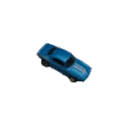
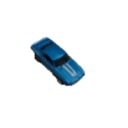

In [4]:
input_image_np = np.array(Image.open(config['input']).convert("RGB"))
target_image_np = np.array(Image.open(config['target']).convert("RGB"))

media.show_images({
    'Source':  input_image_np,
    'Target': target_image_np
})

## PixelNeRF

Load the pixelNeRF. Make sure the `./checkpoints/srn_car/pixel_nerf_latest` exist.

In [24]:
def extra_args(parser):
    parser.add_argument(
        "--input",
        "-I",
        type=str,
        help="Input image to condition on.",
    )
    parser.add_argument(
        "--target",
        "-T",
        type=str,
        help="Target image to estimate the pose.",
    )
    parser.add_argument(
        "--output",
        "-O",
        type=str,
        default=os.path.join(ROOT_DIR, "pose_estimation"),
        help="Output directory",
    )
    parser.add_argument("--size", type=int, default=128, help="Input image maxdim")
    parser.add_argument(
        "--out_size",
        type=str,
        default="128",
        help="Output image size, either 1 or 2 number (w h)",
    )

    parser.add_argument("--focal", type=float, default=131.25, help="Focal length")
    parser.add_argument("--radius", type=float, default=1.3, help="Camera distance")
    parser.add_argument("--z_near", type=float, default=0.8)
    parser.add_argument("--z_far", type=float, default=1.8)
    parser.add_argument(
        "--elevation",
        "-e",
        type=float,
        default=0.0,
        help="Elevation angle (negative is above)",
    )
    parser.add_argument(
        "--num_views",
        type=int,
        default=1,
        help="Number of video frames (rotated views)",
    )
    parser.add_argument("--fps", type=int, default=15, help="FPS of video")
    parser.add_argument("--gif", action="store_true", help="Store gif instead of mp4")
    parser.add_argument(
        "--no_vid",
        action="store_true",
        help="Do not store video (only image frames will be written)",
    )
    parser.add_argument("--lrate", type=float, default=1e-2)
    parser.add_argument("--n_steps", type=int, default=500, help="Number of steps for pose optimization.")
    return parser

display(extra_args)

args, conf = util.args.parse_args(
    extra_args, default_expname="srn_car", default_data_format="srn", jupyter=True
)
args.resume = True
os.makedirs(args.output, exist_ok=True)

device = util.get_cuda(args.gpu_id[0])

z_near, z_far = args.z_near, args.z_far
focal = torch.tensor(args.focal, dtype=torch.float32, device=device)

in_sz = args.size
sz = list(map(int, args.out_size.split()))
if len(sz) == 1:
    H = W = sz[0]
else:
    assert len(sz) == 2
    W, H = sz
display('###now defining net')
net = make_model(conf["model"]).to(device=device).load_weights(args)

# Create the renderer.
renderer = NeRFRenderer.from_conf(
    conf["renderer"], eval_batch_size=args.ray_batch_size
).to(device=device)
render_par = renderer.bind_parallel(net, args.gpu_id, simple_output=True)

<function __main__.extra_args(parser)>

inside parse_args
in src/util/args.py, case is jupyter
args.conf is: None
args.conf is: conf/exp/srn.conf
args.conf is: conf/exp/srn.conf
args.conf is: conf/exp/srn.conf
EXPERIMENT NAME: srn_car
* Config file: conf/exp/srn.conf
* Dataset format: srn
* Dataset location: data


'###now defining net'

Using torchvision resnet34 encoder
Load checkpoints/srn_car/pixel_nerf_latest


In [25]:
device

device(type='cpu')

In [26]:
net

PixelNeRFNet(
  (encoder): SpatialEncoder(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1):

## iNeRF

In [28]:
image_to_tensor = util.get_image_to_tensor_balanced()

# Encoding the input image.
print(f"Input image: {config['input']}")
input_image = Image.fromarray(input_image_np)
input_image = T.Resize(in_sz)(input_image)
input_image = image_to_tensor(input_image).to(device=device)
input_pose = torch.eye(4)
input_pose[2, -1] = args.radius

print(f"Target image: {config['target']}")
target_image = Image.fromarray(target_image_np)
target_image = T.Resize(in_sz)(target_image)
target_image_flatten = np.reshape(target_image, [-1, 3]) / 255.0
target_image_flatten = torch.from_numpy(target_image_flatten).float().to(device=device)

cam_pose = torch.clone(input_pose.detach()).unsqueeze(0)
cam_pose.requires_grad = True

print("Input pose:")
print(f"{input_pose}")
print("Init pose:")
print(f"{cam_pose[0]}")

# Create optimizer.
optimizer = torch.optim.Adam(params=[cam_pose], lr=args.lrate)
n_steps = 100 + 1

# Loss.
mse_loss = torch.nn.MSELoss()

# Sampling.
n_rays = 1024
sampling = 'center'

# Pose optimization.
predicted_poses = []
fine_patches = []
gt_patches = []

for i_step in range(n_steps):
    # Encode.
    print('now encoding step {}'.format(i_step))
    net.encode(
        input_image.unsqueeze(0), input_pose.unsqueeze(0).to(device=device), focal,
    )

    render_rays = util.gen_rays(cam_pose, W, H, focal, z_near, z_far)
    render_rays_flatten = render_rays.view(-1, 8)
    assert render_rays_flatten.shape[0] == H*W
    if sampling == 'random':
        idxs_sampled = torch.randint(0, H*W, (n_rays,))
    elif sampling == 'center':
        frac = 0.5
        mask = torch.zeros((H, W))
        h_low = int(0.5*(1-frac)*H)
        h_high = int(0.5*(1+frac)*H)
        w_low = int(0.5*(1-frac)*W)
        w_high = int(0.5*(1+frac)*W)
        mask[h_low:h_high, w_low:w_high] = 1
        mask = mask.reshape(H*W)

        idxs_masked = torch.where(mask>0)[0]
        idxs_sampled = idxs_masked[torch.randint(0, idxs_masked.shape[0], (n_rays,))]
    elif sampling == 'patch':
        frac = 0.25
        mask = torch.zeros((H, W))
        h_low = int(0.5*(1-frac)*H)
        h_high = int(0.5*(1+frac)*H)
        w_low = int(0.5*(1-frac)*W)
        w_high = int(0.5*(1+frac)*W)
        mask[h_low:h_high, w_low:w_high] = 1
        mask = mask.reshape(H*W)

        idxs_sampled = torch.where(mask>0)[0]

    render_rays_sampled = render_rays_flatten[idxs_sampled].to(device=device)

    rgb, _ = render_par(render_rays_sampled[None])
    loss = mse_loss(rgb, target_image_flatten[idxs_sampled][None])

    optimizer.zero_grad()
    loss.backward()

    if i_step % 10 == 0:        
        predicted_poses.append(torch.clone(cam_pose[0]).detach().numpy())
        fine_patches.append(torch.clone(rgb[0]).detach().cpu().numpy().reshape(32, 32, 3))
        gt_patches.append(torch.clone(target_image_flatten[idxs_sampled]).detach().cpu().numpy().reshape(32, 32, 3))

#         pose_pred = predicted_poses[-1].copy()
#         pose_pred[2, -1] -= args.radius
#         pose_pred = pose_input @ pose_pred
#         error_R, error_t = compute_pose_error(pose_pred, pose_target)
        print(f"Step {i_step}, loss: {loss}")
        
    optimizer.step()

Input image: ./input/1.png
Target image: ./input/2.png
Input pose:
tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 1.3000],
        [0.0000, 0.0000, 0.0000, 1.0000]])
Init pose:
tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 1.3000],
        [0.0000, 0.0000, 0.0000, 1.0000]], grad_fn=<SelectBackward>)
now encoding step 0
Step 0, loss: 0.09849551320075989
now encoding step 1
now encoding step 2
now encoding step 3
now encoding step 4
now encoding step 5
now encoding step 6
now encoding step 7
now encoding step 8
now encoding step 9
now encoding step 10
Step 10, loss: 0.029552899301052094
now encoding step 11
now encoding step 12
now encoding step 13
now encoding step 14
now encoding step 15
now encoding step 16
now encoding step 17
now encoding step 18
now encoding step 19
now encoding step 20
Step 20, loss: 0.01976449228823185
now encoding step 21
n

## Render the results

In [32]:
def create_image(patch):
    image = np.zeros((128, 128, 3))
    image[48:80, 48:80, :] = patch
    image = (image * 255.0).astype(np.uint8)
    return image

# Rendering.
overlay_frames = []
n_poses = len(predicted_poses)
render_poses = torch.from_numpy(np.array(predicted_poses))
render_rays = util.gen_rays(render_poses, W, H, focal, z_near, z_far).to(device=device)
with torch.no_grad():
    print("Rendering", n_poses * H * W, "rays")
    all_rgb_fine = []
    for rays in tqdm.tqdm(torch.split(render_rays.view(-1, 8), 80, dim=0)):#originally, 80000
        print('rendering...')
        rgb, _depth = render_par(rays[None])
        all_rgb_fine.append(rgb[0])
    _depth = None
    rgb_fine = torch.cat(all_rgb_fine)
    frames = (rgb_fine.view(n_poses, H, W, 3).cpu().numpy() * 255).astype(
        np.uint8
    )
    target_image = (target_image_flatten.cpu().numpy().reshape([H, W, 3]) * 255.0).astype(np.uint8)
    target_images = np.stack([np.array(target_image)]*n_poses, 0)
    
    im_name = os.path.basename(os.path.splitext(config['input'])[0])

    frames_dir_name = os.path.join(config['output'], im_name + "_frames")
    os.makedirs(frames_dir_name, exist_ok=True)

    for i in range(n_poses):
        if sampling == 'patch':
            pred_patch_path = os.path.join(config['output'], f'./pred_patch_{i}.png')
            pred_image = create_image(fine_patches[i])

            gt_patch_path = os.path.join(config['output'], f'./gt_patch_{i}.png')
            gt_image = create_image(gt_patches[i])
            overlay_frame = (pred_image*0.5).astype(np.uint8) + (gt_image*0.5).astype(np.uint8)
        else:
            overlay_frame = (frames[i]*0.5).astype(np.uint8) + (target_images[i]*0.5).astype(np.uint8)
        overlay_frames.append(overlay_frame)

Rendering 180224 rays


  0%|                                                                                                                                                                                                       | 0/2253 [00:00<?, ?it/s]

rendering...


  0%|                                                                                                                                                                                               | 1/2253 [00:00<22:02,  1.70it/s]

rendering...


  0%|▏                                                                                                                                                                                              | 2/2253 [00:01<20:40,  1.81it/s]

rendering...


  0%|▎                                                                                                                                                                                              | 3/2253 [00:01<19:53,  1.88it/s]

rendering...


  0%|▎                                                                                                                                                                                              | 4/2253 [00:02<19:40,  1.90it/s]

rendering...


  0%|▍                                                                                                                                                                                              | 5/2253 [00:02<19:41,  1.90it/s]

rendering...


  0%|▌                                                                                                                                                                                              | 6/2253 [00:03<19:48,  1.89it/s]

rendering...


  0%|▌                                                                                                                                                                                              | 7/2253 [00:03<19:59,  1.87it/s]

rendering...


  0%|▋                                                                                                                                                                                              | 8/2253 [00:04<20:08,  1.86it/s]

rendering...


  0%|▊                                                                                                                                                                                              | 9/2253 [00:04<20:08,  1.86it/s]

rendering...


  0%|▊                                                                                                                                                                                             | 10/2253 [00:05<20:10,  1.85it/s]

rendering...


  0%|▉                                                                                                                                                                                             | 11/2253 [00:05<20:02,  1.86it/s]

rendering...


  1%|█                                                                                                                                                                                             | 12/2253 [00:06<19:48,  1.89it/s]

rendering...


  1%|█                                                                                                                                                                                             | 13/2253 [00:06<19:58,  1.87it/s]

rendering...


  1%|█▏                                                                                                                                                                                            | 14/2253 [00:07<19:45,  1.89it/s]

rendering...


  1%|█▎                                                                                                                                                                                            | 15/2253 [00:07<19:34,  1.91it/s]

rendering...


  1%|█▎                                                                                                                                                                                            | 16/2253 [00:08<19:32,  1.91it/s]

rendering...


  1%|█▍                                                                                                                                                                                            | 17/2253 [00:09<19:17,  1.93it/s]

rendering...


  1%|█▌                                                                                                                                                                                            | 18/2253 [00:09<19:06,  1.95it/s]

rendering...


  1%|█▌                                                                                                                                                                                            | 19/2253 [00:10<18:55,  1.97it/s]

rendering...


  1%|█▋                                                                                                                                                                                            | 20/2253 [00:10<18:54,  1.97it/s]

rendering...


  1%|█▊                                                                                                                                                                                            | 21/2253 [00:11<18:54,  1.97it/s]

rendering...


  1%|█▊                                                                                                                                                                                            | 22/2253 [00:11<18:52,  1.97it/s]

rendering...


  1%|█▉                                                                                                                                                                                            | 23/2253 [00:12<18:56,  1.96it/s]

rendering...


  1%|██                                                                                                                                                                                            | 24/2253 [00:12<18:49,  1.97it/s]

rendering...


  1%|██                                                                                                                                                                                            | 25/2253 [00:13<19:08,  1.94it/s]

rendering...


  1%|██▏                                                                                                                                                                                           | 26/2253 [00:13<19:22,  1.92it/s]

rendering...


  1%|██▎                                                                                                                                                                                           | 27/2253 [00:14<19:36,  1.89it/s]

rendering...


  1%|██▎                                                                                                                                                                                           | 28/2253 [00:14<19:43,  1.88it/s]

rendering...


  1%|██▍                                                                                                                                                                                           | 29/2253 [00:15<19:38,  1.89it/s]

rendering...


  1%|██▌                                                                                                                                                                                           | 30/2253 [00:15<19:37,  1.89it/s]

rendering...


  1%|██▌                                                                                                                                                                                           | 31/2253 [00:16<19:44,  1.88it/s]

rendering...


  1%|██▋                                                                                                                                                                                           | 32/2253 [00:16<19:51,  1.86it/s]

rendering...


  1%|██▊                                                                                                                                                                                           | 33/2253 [00:17<19:35,  1.89it/s]

rendering...


  2%|██▊                                                                                                                                                                                           | 34/2253 [00:17<19:19,  1.91it/s]

rendering...


  2%|██▉                                                                                                                                                                                           | 35/2253 [00:18<19:14,  1.92it/s]

rendering...


  2%|███                                                                                                                                                                                           | 36/2253 [00:18<19:21,  1.91it/s]

rendering...


  2%|███                                                                                                                                                                                           | 37/2253 [00:19<19:16,  1.92it/s]

rendering...


  2%|███▏                                                                                                                                                                                          | 38/2253 [00:19<19:34,  1.89it/s]

rendering...


  2%|███▎                                                                                                                                                                                          | 39/2253 [00:20<19:40,  1.88it/s]

rendering...


  2%|███▎                                                                                                                                                                                          | 40/2253 [00:21<19:41,  1.87it/s]

rendering...


  2%|███▍                                                                                                                                                                                          | 41/2253 [00:21<19:41,  1.87it/s]

rendering...


  2%|███▌                                                                                                                                                                                          | 42/2253 [00:22<19:53,  1.85it/s]

rendering...


  2%|███▋                                                                                                                                                                                          | 43/2253 [00:22<19:47,  1.86it/s]

rendering...


  2%|███▋                                                                                                                                                                                          | 44/2253 [00:23<19:48,  1.86it/s]

rendering...


  2%|███▊                                                                                                                                                                                          | 45/2253 [00:23<19:44,  1.86it/s]

rendering...


  2%|███▉                                                                                                                                                                                          | 46/2253 [00:24<19:43,  1.87it/s]

rendering...


  2%|███▉                                                                                                                                                                                          | 47/2253 [00:24<19:47,  1.86it/s]

rendering...


  2%|████                                                                                                                                                                                          | 48/2253 [00:25<19:55,  1.84it/s]

rendering...


  2%|████▏                                                                                                                                                                                         | 49/2253 [00:25<19:52,  1.85it/s]

rendering...


  2%|████▏                                                                                                                                                                                         | 50/2253 [00:26<19:52,  1.85it/s]

rendering...


  2%|████▎                                                                                                                                                                                         | 51/2253 [00:27<20:00,  1.83it/s]

rendering...


  2%|████▍                                                                                                                                                                                         | 52/2253 [00:27<19:51,  1.85it/s]

rendering...


  2%|████▍                                                                                                                                                                                         | 53/2253 [00:28<19:38,  1.87it/s]

rendering...


  2%|████▌                                                                                                                                                                                         | 54/2253 [00:28<19:22,  1.89it/s]

rendering...


  2%|████▋                                                                                                                                                                                         | 55/2253 [00:29<19:06,  1.92it/s]

rendering...


  2%|████▋                                                                                                                                                                                         | 56/2253 [00:29<18:53,  1.94it/s]

rendering...


  3%|████▊                                                                                                                                                                                         | 57/2253 [00:30<18:49,  1.94it/s]

rendering...


  3%|████▉                                                                                                                                                                                         | 58/2253 [00:30<18:35,  1.97it/s]

rendering...


  3%|████▉                                                                                                                                                                                         | 59/2253 [00:31<18:31,  1.97it/s]

rendering...


  3%|█████                                                                                                                                                                                         | 60/2253 [00:31<18:56,  1.93it/s]

rendering...


  3%|█████▏                                                                                                                                                                                        | 61/2253 [00:32<19:08,  1.91it/s]

rendering...


  3%|█████▏                                                                                                                                                                                        | 62/2253 [00:32<19:30,  1.87it/s]

rendering...


  3%|█████▎                                                                                                                                                                                        | 63/2253 [00:33<19:37,  1.86it/s]

rendering...


  3%|█████▍                                                                                                                                                                                        | 64/2253 [00:33<19:31,  1.87it/s]

rendering...


  3%|█████▍                                                                                                                                                                                        | 65/2253 [00:34<19:39,  1.85it/s]

rendering...


  3%|█████▌                                                                                                                                                                                        | 66/2253 [00:34<19:44,  1.85it/s]

rendering...


  3%|█████▋                                                                                                                                                                                        | 67/2253 [00:35<19:35,  1.86it/s]

rendering...


  3%|█████▋                                                                                                                                                                                        | 68/2253 [00:35<19:31,  1.87it/s]

rendering...


  3%|█████▊                                                                                                                                                                                        | 69/2253 [00:36<19:32,  1.86it/s]

rendering...


  3%|█████▉                                                                                                                                                                                        | 70/2253 [00:37<19:31,  1.86it/s]

rendering...


  3%|█████▉                                                                                                                                                                                        | 71/2253 [00:37<19:20,  1.88it/s]

rendering...


  3%|██████                                                                                                                                                                                        | 72/2253 [00:38<18:59,  1.91it/s]

rendering...


  3%|██████▏                                                                                                                                                                                       | 73/2253 [00:38<18:52,  1.92it/s]

rendering...


  3%|██████▏                                                                                                                                                                                       | 74/2253 [00:39<18:56,  1.92it/s]

rendering...


  3%|██████▎                                                                                                                                                                                       | 75/2253 [00:39<18:41,  1.94it/s]

rendering...


  3%|██████▍                                                                                                                                                                                       | 76/2253 [00:40<18:31,  1.96it/s]

rendering...


  3%|██████▍                                                                                                                                                                                       | 77/2253 [00:40<18:38,  1.95it/s]

rendering...


  3%|██████▌                                                                                                                                                                                       | 78/2253 [00:41<18:35,  1.95it/s]

rendering...


  4%|██████▋                                                                                                                                                                                       | 79/2253 [00:41<18:40,  1.94it/s]

rendering...


  4%|██████▋                                                                                                                                                                                       | 80/2253 [00:42<18:35,  1.95it/s]

rendering...


  4%|██████▊                                                                                                                                                                                       | 81/2253 [00:42<18:32,  1.95it/s]

rendering...


  4%|██████▉                                                                                                                                                                                       | 82/2253 [00:43<18:48,  1.92it/s]

rendering...


  4%|██████▉                                                                                                                                                                                       | 83/2253 [00:43<18:39,  1.94it/s]

rendering...


  4%|███████                                                                                                                                                                                       | 84/2253 [00:44<18:31,  1.95it/s]

rendering...


  4%|███████▏                                                                                                                                                                                      | 85/2253 [00:44<18:36,  1.94it/s]

rendering...


  4%|███████▎                                                                                                                                                                                      | 86/2253 [00:45<18:53,  1.91it/s]

rendering...


  4%|███████▎                                                                                                                                                                                      | 87/2253 [00:45<18:40,  1.93it/s]

rendering...


  4%|███████▍                                                                                                                                                                                      | 88/2253 [00:46<18:29,  1.95it/s]

rendering...


  4%|███████▌                                                                                                                                                                                      | 89/2253 [00:46<18:34,  1.94it/s]

rendering...


  4%|███████▌                                                                                                                                                                                      | 90/2253 [00:47<18:36,  1.94it/s]

rendering...


  4%|███████▋                                                                                                                                                                                      | 91/2253 [00:47<18:43,  1.92it/s]

rendering...


  4%|███████▊                                                                                                                                                                                      | 92/2253 [00:48<18:53,  1.91it/s]

rendering...


  4%|███████▊                                                                                                                                                                                      | 93/2253 [00:48<19:01,  1.89it/s]

rendering...


  4%|███████▉                                                                                                                                                                                      | 94/2253 [00:49<19:20,  1.86it/s]

rendering...


  4%|████████                                                                                                                                                                                      | 95/2253 [00:50<19:19,  1.86it/s]

rendering...


  4%|████████                                                                                                                                                                                      | 96/2253 [00:50<19:10,  1.87it/s]

rendering...


  4%|████████▏                                                                                                                                                                                     | 97/2253 [00:51<19:10,  1.87it/s]

rendering...


  4%|████████▎                                                                                                                                                                                     | 98/2253 [00:51<19:02,  1.89it/s]

rendering...


  4%|████████▎                                                                                                                                                                                     | 99/2253 [00:52<18:52,  1.90it/s]

rendering...


  4%|████████▍                                                                                                                                                                                    | 100/2253 [00:52<19:02,  1.89it/s]

rendering...


  4%|████████▍                                                                                                                                                                                    | 101/2253 [00:53<18:54,  1.90it/s]

rendering...


  5%|████████▌                                                                                                                                                                                    | 102/2253 [00:53<19:00,  1.89it/s]

rendering...


  5%|████████▋                                                                                                                                                                                    | 103/2253 [00:54<19:06,  1.88it/s]

rendering...


  5%|████████▋                                                                                                                                                                                    | 104/2253 [00:54<18:52,  1.90it/s]

rendering...


  5%|████████▊                                                                                                                                                                                    | 105/2253 [00:55<18:58,  1.89it/s]

rendering...


  5%|████████▉                                                                                                                                                                                    | 106/2253 [00:55<19:06,  1.87it/s]

rendering...


  5%|████████▉                                                                                                                                                                                    | 107/2253 [00:56<19:05,  1.87it/s]

rendering...


  5%|█████████                                                                                                                                                                                    | 108/2253 [00:56<19:23,  1.84it/s]

rendering...


  5%|█████████▏                                                                                                                                                                                   | 109/2253 [00:57<19:16,  1.85it/s]

rendering...


  5%|█████████▏                                                                                                                                                                                   | 110/2253 [00:58<19:05,  1.87it/s]

rendering...


  5%|█████████▎                                                                                                                                                                                   | 111/2253 [00:58<18:56,  1.89it/s]

rendering...


  5%|█████████▍                                                                                                                                                                                   | 112/2253 [00:59<18:58,  1.88it/s]

rendering...


  5%|█████████▍                                                                                                                                                                                   | 113/2253 [00:59<18:56,  1.88it/s]

rendering...


  5%|█████████▌                                                                                                                                                                                   | 114/2253 [01:00<19:04,  1.87it/s]

rendering...


  5%|█████████▋                                                                                                                                                                                   | 115/2253 [01:00<19:02,  1.87it/s]

rendering...


  5%|█████████▋                                                                                                                                                                                   | 116/2253 [01:01<19:08,  1.86it/s]

rendering...


  5%|█████████▊                                                                                                                                                                                   | 117/2253 [01:01<19:09,  1.86it/s]

rendering...


  5%|█████████▉                                                                                                                                                                                   | 118/2253 [01:02<19:10,  1.86it/s]

rendering...


  5%|█████████▉                                                                                                                                                                                   | 119/2253 [01:02<19:05,  1.86it/s]

rendering...


  5%|██████████                                                                                                                                                                                   | 120/2253 [01:03<19:00,  1.87it/s]

rendering...


  5%|██████████▏                                                                                                                                                                                  | 121/2253 [01:03<18:51,  1.88it/s]

rendering...


  5%|██████████▏                                                                                                                                                                                  | 122/2253 [01:04<18:36,  1.91it/s]

rendering...


  5%|██████████▎                                                                                                                                                                                  | 123/2253 [01:04<18:29,  1.92it/s]

rendering...


  6%|██████████▍                                                                                                                                                                                  | 124/2253 [01:05<18:34,  1.91it/s]

rendering...


  6%|██████████▍                                                                                                                                                                                  | 125/2253 [01:05<18:29,  1.92it/s]

rendering...


  6%|██████████▌                                                                                                                                                                                  | 126/2253 [01:06<18:26,  1.92it/s]

rendering...


  6%|██████████▋                                                                                                                                                                                  | 127/2253 [01:06<18:15,  1.94it/s]

rendering...


  6%|██████████▋                                                                                                                                                                                  | 128/2253 [01:07<18:05,  1.96it/s]

rendering...


  6%|██████████▊                                                                                                                                                                                  | 129/2253 [01:07<18:07,  1.95it/s]

rendering...


  6%|██████████▉                                                                                                                                                                                  | 130/2253 [01:08<18:10,  1.95it/s]

rendering...


  6%|██████████▉                                                                                                                                                                                  | 131/2253 [01:09<18:02,  1.96it/s]

rendering...


  6%|███████████                                                                                                                                                                                  | 132/2253 [01:09<17:49,  1.98it/s]

rendering...


  6%|███████████▏                                                                                                                                                                                 | 133/2253 [01:09<17:48,  1.98it/s]

rendering...


  6%|███████████▏                                                                                                                                                                                 | 134/2253 [01:10<17:44,  1.99it/s]

rendering...


  6%|███████████▎                                                                                                                                                                                 | 135/2253 [01:10<17:44,  1.99it/s]

rendering...


  6%|███████████▍                                                                                                                                                                                 | 136/2253 [01:11<17:41,  1.99it/s]

rendering...


  6%|███████████▍                                                                                                                                                                                 | 137/2253 [01:11<17:38,  2.00it/s]

rendering...


  6%|███████████▌                                                                                                                                                                                 | 138/2253 [01:12<17:57,  1.96it/s]

rendering...


  6%|███████████▋                                                                                                                                                                                 | 139/2253 [01:13<17:59,  1.96it/s]

rendering...


  6%|███████████▋                                                                                                                                                                                 | 140/2253 [01:13<18:02,  1.95it/s]

rendering...


  6%|███████████▊                                                                                                                                                                                 | 141/2253 [01:14<18:01,  1.95it/s]

rendering...


  6%|███████████▉                                                                                                                                                                                 | 142/2253 [01:14<18:01,  1.95it/s]

rendering...


  6%|███████████▉                                                                                                                                                                                 | 143/2253 [01:15<18:10,  1.94it/s]

rendering...


  6%|████████████                                                                                                                                                                                 | 144/2253 [01:15<18:20,  1.92it/s]

rendering...


  6%|████████████▏                                                                                                                                                                                | 145/2253 [01:16<18:21,  1.91it/s]

rendering...


  6%|████████████▏                                                                                                                                                                                | 146/2253 [01:16<18:26,  1.90it/s]

rendering...


  7%|████████████▎                                                                                                                                                                                | 147/2253 [01:17<18:36,  1.89it/s]

rendering...


  7%|████████████▍                                                                                                                                                                                | 148/2253 [01:17<18:48,  1.86it/s]

rendering...


  7%|████████████▍                                                                                                                                                                                | 149/2253 [01:18<18:28,  1.90it/s]

rendering...


  7%|████████████▌                                                                                                                                                                                | 150/2253 [01:18<18:16,  1.92it/s]

rendering...


  7%|████████████▋                                                                                                                                                                                | 151/2253 [01:19<18:13,  1.92it/s]

rendering...


  7%|████████████▊                                                                                                                                                                                | 152/2253 [01:19<18:13,  1.92it/s]

rendering...


  7%|████████████▊                                                                                                                                                                                | 153/2253 [01:20<18:25,  1.90it/s]

rendering...


  7%|████████████▉                                                                                                                                                                                | 154/2253 [01:20<18:30,  1.89it/s]

rendering...


  7%|█████████████                                                                                                                                                                                | 155/2253 [01:21<18:19,  1.91it/s]

rendering...


  7%|█████████████                                                                                                                                                                                | 156/2253 [01:21<18:17,  1.91it/s]

rendering...


  7%|█████████████▏                                                                                                                                                                               | 157/2253 [01:22<18:11,  1.92it/s]

rendering...


  7%|█████████████▎                                                                                                                                                                               | 158/2253 [01:22<18:11,  1.92it/s]

rendering...


  7%|█████████████▎                                                                                                                                                                               | 159/2253 [01:23<18:14,  1.91it/s]

rendering...


  7%|█████████████▍                                                                                                                                                                               | 160/2253 [01:24<18:12,  1.92it/s]

rendering...


  7%|█████████████▌                                                                                                                                                                               | 161/2253 [01:24<18:03,  1.93it/s]

rendering...


  7%|█████████████▌                                                                                                                                                                               | 162/2253 [01:25<18:00,  1.94it/s]

rendering...


  7%|█████████████▋                                                                                                                                                                               | 163/2253 [01:25<18:04,  1.93it/s]

rendering...


  7%|█████████████▊                                                                                                                                                                               | 164/2253 [01:26<18:14,  1.91it/s]

rendering...


  7%|█████████████▊                                                                                                                                                                               | 165/2253 [01:26<18:10,  1.92it/s]

rendering...


  7%|█████████████▉                                                                                                                                                                               | 166/2253 [01:27<18:19,  1.90it/s]

rendering...


  7%|██████████████                                                                                                                                                                               | 167/2253 [01:27<18:07,  1.92it/s]

rendering...


  7%|██████████████                                                                                                                                                                               | 168/2253 [01:28<18:15,  1.90it/s]

rendering...


  8%|██████████████▏                                                                                                                                                                              | 169/2253 [01:28<18:22,  1.89it/s]

rendering...


  8%|██████████████▎                                                                                                                                                                              | 170/2253 [01:29<18:13,  1.91it/s]

rendering...


  8%|██████████████▎                                                                                                                                                                              | 171/2253 [01:29<18:08,  1.91it/s]

rendering...


  8%|██████████████▍                                                                                                                                                                              | 172/2253 [01:30<18:06,  1.92it/s]

rendering...


  8%|██████████████▌                                                                                                                                                                              | 173/2253 [01:30<18:13,  1.90it/s]

rendering...


  8%|██████████████▌                                                                                                                                                                              | 174/2253 [01:31<18:21,  1.89it/s]

rendering...


  8%|██████████████▋                                                                                                                                                                              | 175/2253 [01:31<18:11,  1.90it/s]

rendering...


  8%|██████████████▊                                                                                                                                                                              | 176/2253 [01:32<18:17,  1.89it/s]

rendering...


  8%|██████████████▊                                                                                                                                                                              | 177/2253 [01:32<18:15,  1.89it/s]

rendering...


  8%|██████████████▉                                                                                                                                                                              | 178/2253 [01:33<18:05,  1.91it/s]

rendering...


  8%|███████████████                                                                                                                                                                              | 179/2253 [01:33<18:07,  1.91it/s]

rendering...


  8%|███████████████                                                                                                                                                                              | 180/2253 [01:34<18:04,  1.91it/s]

rendering...


  8%|███████████████▏                                                                                                                                                                             | 181/2253 [01:35<18:05,  1.91it/s]

rendering...


  8%|███████████████▎                                                                                                                                                                             | 182/2253 [01:35<18:04,  1.91it/s]

rendering...


  8%|███████████████▎                                                                                                                                                                             | 183/2253 [01:36<18:00,  1.92it/s]

rendering...


  8%|███████████████▍                                                                                                                                                                             | 184/2253 [01:36<18:05,  1.91it/s]

rendering...


  8%|███████████████▌                                                                                                                                                                             | 185/2253 [01:37<18:01,  1.91it/s]

rendering...


  8%|███████████████▌                                                                                                                                                                             | 186/2253 [01:37<17:57,  1.92it/s]

rendering...


  8%|███████████████▋                                                                                                                                                                             | 187/2253 [01:38<17:50,  1.93it/s]

rendering...


  8%|███████████████▊                                                                                                                                                                             | 188/2253 [01:38<17:54,  1.92it/s]

rendering...


  8%|███████████████▊                                                                                                                                                                             | 189/2253 [01:39<18:11,  1.89it/s]

rendering...


  8%|███████████████▉                                                                                                                                                                             | 190/2253 [01:39<18:08,  1.89it/s]

rendering...


  8%|████████████████                                                                                                                                                                             | 191/2253 [01:40<18:08,  1.89it/s]

rendering...


  9%|████████████████                                                                                                                                                                             | 192/2253 [01:40<18:05,  1.90it/s]

rendering...


  9%|████████████████▏                                                                                                                                                                            | 193/2253 [01:41<18:03,  1.90it/s]

rendering...


  9%|████████████████▎                                                                                                                                                                            | 194/2253 [01:41<18:01,  1.90it/s]

rendering...


  9%|████████████████▎                                                                                                                                                                            | 195/2253 [01:42<17:49,  1.92it/s]

rendering...


  9%|████████████████▍                                                                                                                                                                            | 196/2253 [01:42<17:49,  1.92it/s]

rendering...


  9%|████████████████▌                                                                                                                                                                            | 197/2253 [01:43<17:53,  1.92it/s]

rendering...


  9%|████████████████▌                                                                                                                                                                            | 198/2253 [01:43<17:50,  1.92it/s]

rendering...


  9%|████████████████▋                                                                                                                                                                            | 199/2253 [01:44<17:40,  1.94it/s]

rendering...


  9%|████████████████▊                                                                                                                                                                            | 200/2253 [01:44<17:40,  1.94it/s]

rendering...


  9%|████████████████▊                                                                                                                                                                            | 201/2253 [01:45<17:43,  1.93it/s]

rendering...


  9%|████████████████▉                                                                                                                                                                            | 202/2253 [01:45<17:39,  1.93it/s]

rendering...


  9%|█████████████████                                                                                                                                                                            | 203/2253 [01:46<17:42,  1.93it/s]

rendering...


  9%|█████████████████                                                                                                                                                                            | 204/2253 [01:47<17:35,  1.94it/s]

rendering...


  9%|█████████████████▏                                                                                                                                                                           | 205/2253 [01:47<17:34,  1.94it/s]

rendering...


  9%|█████████████████▎                                                                                                                                                                           | 206/2253 [01:48<17:40,  1.93it/s]

rendering...


  9%|█████████████████▎                                                                                                                                                                           | 207/2253 [01:48<17:29,  1.95it/s]

rendering...


  9%|█████████████████▍                                                                                                                                                                           | 208/2253 [01:49<17:32,  1.94it/s]

rendering...


  9%|█████████████████▌                                                                                                                                                                           | 209/2253 [01:49<17:36,  1.93it/s]

rendering...


  9%|█████████████████▌                                                                                                                                                                           | 210/2253 [01:50<17:42,  1.92it/s]

rendering...


  9%|█████████████████▋                                                                                                                                                                           | 211/2253 [01:50<17:39,  1.93it/s]

rendering...


  9%|█████████████████▊                                                                                                                                                                           | 212/2253 [01:51<17:36,  1.93it/s]

rendering...


  9%|█████████████████▊                                                                                                                                                                           | 213/2253 [01:51<17:31,  1.94it/s]

rendering...


  9%|█████████████████▉                                                                                                                                                                           | 214/2253 [01:52<17:38,  1.93it/s]

rendering...


 10%|██████████████████                                                                                                                                                                           | 215/2253 [01:52<17:39,  1.92it/s]

rendering...


 10%|██████████████████                                                                                                                                                                           | 216/2253 [01:53<17:41,  1.92it/s]

rendering...


 10%|██████████████████▏                                                                                                                                                                          | 217/2253 [01:53<17:41,  1.92it/s]

rendering...


 10%|██████████████████▎                                                                                                                                                                          | 218/2253 [01:54<17:43,  1.91it/s]

rendering...


 10%|██████████████████▎                                                                                                                                                                          | 219/2253 [01:54<17:36,  1.93it/s]

rendering...


 10%|██████████████████▍                                                                                                                                                                          | 220/2253 [01:55<17:32,  1.93it/s]

rendering...


 10%|██████████████████▌                                                                                                                                                                          | 221/2253 [01:55<17:39,  1.92it/s]

rendering...


 10%|██████████████████▌                                                                                                                                                                          | 222/2253 [01:56<17:35,  1.92it/s]

rendering...


 10%|██████████████████▋                                                                                                                                                                          | 223/2253 [01:56<17:31,  1.93it/s]

rendering...


 10%|██████████████████▊                                                                                                                                                                          | 224/2253 [01:57<17:43,  1.91it/s]

rendering...


 10%|██████████████████▊                                                                                                                                                                          | 225/2253 [01:57<17:45,  1.90it/s]

rendering...


 10%|██████████████████▉                                                                                                                                                                          | 226/2253 [01:58<17:52,  1.89it/s]

rendering...


 10%|███████████████████                                                                                                                                                                          | 227/2253 [01:59<17:48,  1.90it/s]

rendering...


 10%|███████████████████▏                                                                                                                                                                         | 228/2253 [01:59<17:44,  1.90it/s]

rendering...


 10%|███████████████████▏                                                                                                                                                                         | 229/2253 [02:00<17:45,  1.90it/s]

rendering...


 10%|███████████████████▎                                                                                                                                                                         | 230/2253 [02:00<17:37,  1.91it/s]

rendering...


 10%|███████████████████▍                                                                                                                                                                         | 231/2253 [02:01<17:28,  1.93it/s]

rendering...


 10%|███████████████████▍                                                                                                                                                                         | 232/2253 [02:01<17:20,  1.94it/s]

rendering...


 10%|███████████████████▌                                                                                                                                                                         | 233/2253 [02:02<17:23,  1.94it/s]

rendering...


 10%|███████████████████▋                                                                                                                                                                         | 234/2253 [02:02<17:25,  1.93it/s]

rendering...


 10%|███████████████████▋                                                                                                                                                                         | 235/2253 [02:03<17:22,  1.94it/s]

rendering...


 10%|███████████████████▊                                                                                                                                                                         | 236/2253 [02:03<17:12,  1.95it/s]

rendering...


 11%|███████████████████▉                                                                                                                                                                         | 237/2253 [02:04<17:11,  1.95it/s]

rendering...


 11%|███████████████████▉                                                                                                                                                                         | 238/2253 [02:04<17:05,  1.96it/s]

rendering...


 11%|████████████████████                                                                                                                                                                         | 239/2253 [02:05<17:10,  1.95it/s]

rendering...


 11%|████████████████████▏                                                                                                                                                                        | 240/2253 [02:05<17:12,  1.95it/s]

rendering...


 11%|████████████████████▏                                                                                                                                                                        | 241/2253 [02:06<17:15,  1.94it/s]

rendering...


 11%|████████████████████▎                                                                                                                                                                        | 242/2253 [02:06<17:15,  1.94it/s]

rendering...


 11%|████████████████████▍                                                                                                                                                                        | 243/2253 [02:07<17:24,  1.92it/s]

rendering...


 11%|████████████████████▍                                                                                                                                                                        | 244/2253 [02:07<17:34,  1.90it/s]

rendering...


 11%|████████████████████▌                                                                                                                                                                        | 245/2253 [02:08<17:36,  1.90it/s]

rendering...


 11%|████████████████████▋                                                                                                                                                                        | 246/2253 [02:08<17:29,  1.91it/s]

rendering...


 11%|████████████████████▋                                                                                                                                                                        | 247/2253 [02:09<17:19,  1.93it/s]

rendering...


 11%|████████████████████▊                                                                                                                                                                        | 248/2253 [02:09<17:13,  1.94it/s]

rendering...


 11%|████████████████████▉                                                                                                                                                                        | 249/2253 [02:10<17:08,  1.95it/s]

rendering...


 11%|████████████████████▉                                                                                                                                                                        | 250/2253 [02:10<17:09,  1.95it/s]

rendering...


 11%|█████████████████████                                                                                                                                                                        | 251/2253 [02:11<17:12,  1.94it/s]

rendering...


 11%|█████████████████████▏                                                                                                                                                                       | 252/2253 [02:11<17:13,  1.94it/s]

rendering...


 11%|█████████████████████▏                                                                                                                                                                       | 253/2253 [02:12<17:09,  1.94it/s]

rendering...


 11%|█████████████████████▎                                                                                                                                                                       | 254/2253 [02:12<17:14,  1.93it/s]

rendering...


 11%|█████████████████████▍                                                                                                                                                                       | 255/2253 [02:13<17:22,  1.92it/s]

rendering...


 11%|█████████████████████▍                                                                                                                                                                       | 256/2253 [02:14<17:32,  1.90it/s]

rendering...


 11%|█████████████████████▌                                                                                                                                                                       | 257/2253 [02:14<17:38,  1.89it/s]

rendering...


 11%|█████████████████████▋                                                                                                                                                                       | 258/2253 [02:15<17:53,  1.86it/s]

rendering...


 11%|█████████████████████▋                                                                                                                                                                       | 259/2253 [02:15<17:40,  1.88it/s]

rendering...


 12%|█████████████████████▊                                                                                                                                                                       | 260/2253 [02:16<17:31,  1.89it/s]

rendering...


 12%|█████████████████████▉                                                                                                                                                                       | 261/2253 [02:16<17:28,  1.90it/s]

rendering...


 12%|█████████████████████▉                                                                                                                                                                       | 262/2253 [02:17<17:22,  1.91it/s]

rendering...


 12%|██████████████████████                                                                                                                                                                       | 263/2253 [02:17<17:19,  1.91it/s]

rendering...


 12%|██████████████████████▏                                                                                                                                                                      | 264/2253 [02:18<17:17,  1.92it/s]

rendering...


 12%|██████████████████████▏                                                                                                                                                                      | 265/2253 [02:18<17:25,  1.90it/s]

rendering...


 12%|██████████████████████▎                                                                                                                                                                      | 266/2253 [02:19<17:28,  1.90it/s]

rendering...


 12%|██████████████████████▍                                                                                                                                                                      | 267/2253 [02:19<17:37,  1.88it/s]

rendering...


 12%|██████████████████████▍                                                                                                                                                                      | 268/2253 [02:20<17:32,  1.89it/s]

rendering...


 12%|██████████████████████▌                                                                                                                                                                      | 269/2253 [02:20<17:29,  1.89it/s]

rendering...


 12%|██████████████████████▋                                                                                                                                                                      | 270/2253 [02:21<17:23,  1.90it/s]

rendering...


 12%|██████████████████████▋                                                                                                                                                                      | 271/2253 [02:21<17:14,  1.92it/s]

rendering...


 12%|██████████████████████▊                                                                                                                                                                      | 272/2253 [02:22<17:19,  1.91it/s]

rendering...


 12%|██████████████████████▉                                                                                                                                                                      | 273/2253 [02:22<17:22,  1.90it/s]

rendering...


 12%|██████████████████████▉                                                                                                                                                                      | 274/2253 [02:23<17:17,  1.91it/s]

rendering...


 12%|███████████████████████                                                                                                                                                                      | 275/2253 [02:24<17:09,  1.92it/s]

rendering...


 12%|███████████████████████▏                                                                                                                                                                     | 276/2253 [02:24<17:02,  1.93it/s]

rendering...


 12%|███████████████████████▏                                                                                                                                                                     | 277/2253 [02:25<17:04,  1.93it/s]

rendering...


 12%|███████████████████████▎                                                                                                                                                                     | 278/2253 [02:25<17:13,  1.91it/s]

rendering...


 12%|███████████████████████▍                                                                                                                                                                     | 279/2253 [02:26<17:03,  1.93it/s]

rendering...


 12%|███████████████████████▍                                                                                                                                                                     | 280/2253 [02:26<16:47,  1.96it/s]

rendering...


 12%|███████████████████████▌                                                                                                                                                                     | 281/2253 [02:27<16:42,  1.97it/s]

rendering...


 13%|███████████████████████▋                                                                                                                                                                     | 282/2253 [02:27<16:38,  1.97it/s]

rendering...


 13%|███████████████████████▋                                                                                                                                                                     | 283/2253 [02:28<16:32,  1.99it/s]

rendering...


 13%|███████████████████████▊                                                                                                                                                                     | 284/2253 [02:28<16:34,  1.98it/s]

rendering...


 13%|███████████████████████▉                                                                                                                                                                     | 285/2253 [02:29<16:31,  1.99it/s]

rendering...


 13%|███████████████████████▉                                                                                                                                                                     | 286/2253 [02:29<16:32,  1.98it/s]

rendering...


 13%|████████████████████████                                                                                                                                                                     | 287/2253 [02:30<16:25,  1.99it/s]

rendering...


 13%|████████████████████████▏                                                                                                                                                                    | 288/2253 [02:30<16:34,  1.98it/s]

rendering...


 13%|████████████████████████▏                                                                                                                                                                    | 289/2253 [02:31<16:36,  1.97it/s]

rendering...


 13%|████████████████████████▎                                                                                                                                                                    | 290/2253 [02:31<16:32,  1.98it/s]

rendering...


 13%|████████████████████████▍                                                                                                                                                                    | 291/2253 [02:32<16:52,  1.94it/s]

rendering...


 13%|████████████████████████▍                                                                                                                                                                    | 292/2253 [02:32<16:57,  1.93it/s]

rendering...


 13%|████████████████████████▌                                                                                                                                                                    | 293/2253 [02:33<16:55,  1.93it/s]

rendering...


 13%|████████████████████████▋                                                                                                                                                                    | 294/2253 [02:33<16:51,  1.94it/s]

rendering...


 13%|████████████████████████▋                                                                                                                                                                    | 295/2253 [02:34<16:53,  1.93it/s]

rendering...


 13%|████████████████████████▊                                                                                                                                                                    | 296/2253 [02:34<17:06,  1.91it/s]

rendering...


 13%|████████████████████████▉                                                                                                                                                                    | 297/2253 [02:35<17:16,  1.89it/s]

rendering...


 13%|████████████████████████▉                                                                                                                                                                    | 298/2253 [02:35<17:12,  1.89it/s]

rendering...


 13%|█████████████████████████                                                                                                                                                                    | 299/2253 [02:36<17:21,  1.88it/s]

rendering...


 13%|█████████████████████████▏                                                                                                                                                                   | 300/2253 [02:36<17:13,  1.89it/s]

rendering...


 13%|█████████████████████████▎                                                                                                                                                                   | 301/2253 [02:37<17:20,  1.88it/s]

rendering...


 13%|█████████████████████████▎                                                                                                                                                                   | 302/2253 [02:37<17:23,  1.87it/s]

rendering...


 13%|█████████████████████████▍                                                                                                                                                                   | 303/2253 [02:38<17:16,  1.88it/s]

rendering...


 13%|█████████████████████████▌                                                                                                                                                                   | 304/2253 [02:39<17:17,  1.88it/s]

rendering...


 14%|█████████████████████████▌                                                                                                                                                                   | 305/2253 [02:39<17:12,  1.89it/s]

rendering...


 14%|█████████████████████████▋                                                                                                                                                                   | 306/2253 [02:40<17:06,  1.90it/s]

rendering...


 14%|█████████████████████████▊                                                                                                                                                                   | 307/2253 [02:40<16:52,  1.92it/s]

rendering...


 14%|█████████████████████████▊                                                                                                                                                                   | 308/2253 [02:41<16:50,  1.92it/s]

rendering...


 14%|█████████████████████████▉                                                                                                                                                                   | 309/2253 [02:41<16:48,  1.93it/s]

rendering...


 14%|██████████████████████████                                                                                                                                                                   | 310/2253 [02:42<16:53,  1.92it/s]

rendering...


 14%|██████████████████████████                                                                                                                                                                   | 311/2253 [02:42<16:54,  1.91it/s]

rendering...


 14%|██████████████████████████▏                                                                                                                                                                  | 312/2253 [02:43<16:53,  1.92it/s]

rendering...


 14%|██████████████████████████▎                                                                                                                                                                  | 313/2253 [02:43<16:41,  1.94it/s]

rendering...


 14%|██████████████████████████▎                                                                                                                                                                  | 314/2253 [02:44<16:35,  1.95it/s]

rendering...


 14%|██████████████████████████▍                                                                                                                                                                  | 315/2253 [02:44<16:41,  1.94it/s]

rendering...


 14%|██████████████████████████▌                                                                                                                                                                  | 316/2253 [02:45<16:46,  1.92it/s]

rendering...


 14%|██████████████████████████▌                                                                                                                                                                  | 317/2253 [02:45<16:48,  1.92it/s]

rendering...


 14%|██████████████████████████▋                                                                                                                                                                  | 318/2253 [02:46<16:39,  1.94it/s]

rendering...


 14%|██████████████████████████▊                                                                                                                                                                  | 319/2253 [02:46<16:36,  1.94it/s]

rendering...


 14%|██████████████████████████▊                                                                                                                                                                  | 320/2253 [02:47<16:39,  1.93it/s]

rendering...


 14%|██████████████████████████▉                                                                                                                                                                  | 321/2253 [02:47<16:33,  1.94it/s]

rendering...


 14%|███████████████████████████                                                                                                                                                                  | 322/2253 [02:48<16:39,  1.93it/s]

rendering...


 14%|███████████████████████████                                                                                                                                                                  | 323/2253 [02:48<16:39,  1.93it/s]

rendering...


 14%|███████████████████████████▏                                                                                                                                                                 | 324/2253 [02:49<16:43,  1.92it/s]

rendering...


 14%|███████████████████████████▎                                                                                                                                                                 | 325/2253 [02:49<16:50,  1.91it/s]

rendering...


 14%|███████████████████████████▎                                                                                                                                                                 | 326/2253 [02:50<16:43,  1.92it/s]

rendering...


 15%|███████████████████████████▍                                                                                                                                                                 | 327/2253 [02:50<16:47,  1.91it/s]

rendering...


 15%|███████████████████████████▌                                                                                                                                                                 | 328/2253 [02:51<16:39,  1.93it/s]

rendering...


 15%|███████████████████████████▌                                                                                                                                                                 | 329/2253 [02:52<16:36,  1.93it/s]

rendering...


 15%|███████████████████████████▋                                                                                                                                                                 | 330/2253 [02:52<16:35,  1.93it/s]

rendering...


 15%|███████████████████████████▊                                                                                                                                                                 | 331/2253 [02:53<16:28,  1.95it/s]

rendering...


 15%|███████████████████████████▊                                                                                                                                                                 | 332/2253 [02:53<16:24,  1.95it/s]

rendering...


 15%|███████████████████████████▉                                                                                                                                                                 | 333/2253 [02:54<16:24,  1.95it/s]

rendering...


 15%|████████████████████████████                                                                                                                                                                 | 334/2253 [02:54<16:37,  1.92it/s]

rendering...


 15%|████████████████████████████                                                                                                                                                                 | 335/2253 [02:55<16:41,  1.92it/s]

rendering...


 15%|████████████████████████████▏                                                                                                                                                                | 336/2253 [02:55<16:42,  1.91it/s]

rendering...


 15%|████████████████████████████▎                                                                                                                                                                | 337/2253 [02:56<16:41,  1.91it/s]

rendering...


 15%|████████████████████████████▎                                                                                                                                                                | 338/2253 [02:56<16:38,  1.92it/s]

rendering...


 15%|████████████████████████████▍                                                                                                                                                                | 339/2253 [02:57<16:43,  1.91it/s]

rendering...


 15%|████████████████████████████▌                                                                                                                                                                | 340/2253 [02:57<16:39,  1.91it/s]

rendering...


 15%|████████████████████████████▌                                                                                                                                                                | 341/2253 [02:58<16:43,  1.91it/s]

rendering...


 15%|████████████████████████████▋                                                                                                                                                                | 342/2253 [02:58<16:47,  1.90it/s]

rendering...


 15%|████████████████████████████▊                                                                                                                                                                | 343/2253 [02:59<16:55,  1.88it/s]

rendering...


 15%|████████████████████████████▊                                                                                                                                                                | 344/2253 [02:59<16:47,  1.89it/s]

rendering...


 15%|████████████████████████████▉                                                                                                                                                                | 345/2253 [03:00<16:42,  1.90it/s]

rendering...


 15%|█████████████████████████████                                                                                                                                                                | 346/2253 [03:00<16:37,  1.91it/s]

rendering...


 15%|█████████████████████████████                                                                                                                                                                | 347/2253 [03:01<16:37,  1.91it/s]

rendering...


 15%|█████████████████████████████▏                                                                                                                                                               | 348/2253 [03:01<16:31,  1.92it/s]

rendering...


 15%|█████████████████████████████▎                                                                                                                                                               | 349/2253 [03:02<16:26,  1.93it/s]

rendering...


 16%|█████████████████████████████▎                                                                                                                                                               | 350/2253 [03:02<16:34,  1.91it/s]

rendering...


 16%|█████████████████████████████▍                                                                                                                                                               | 351/2253 [03:03<16:26,  1.93it/s]

rendering...


 16%|█████████████████████████████▌                                                                                                                                                               | 352/2253 [03:04<16:31,  1.92it/s]

rendering...


 16%|█████████████████████████████▌                                                                                                                                                               | 353/2253 [03:04<16:42,  1.89it/s]

rendering...


 16%|█████████████████████████████▋                                                                                                                                                               | 354/2253 [03:05<16:44,  1.89it/s]

rendering...


 16%|█████████████████████████████▊                                                                                                                                                               | 355/2253 [03:05<16:38,  1.90it/s]

rendering...


 16%|█████████████████████████████▊                                                                                                                                                               | 356/2253 [03:06<16:35,  1.90it/s]

rendering...


 16%|█████████████████████████████▉                                                                                                                                                               | 357/2253 [03:06<16:39,  1.90it/s]

rendering...


 16%|██████████████████████████████                                                                                                                                                               | 358/2253 [03:07<16:35,  1.90it/s]

rendering...


 16%|██████████████████████████████                                                                                                                                                               | 359/2253 [03:07<16:40,  1.89it/s]

rendering...


 16%|██████████████████████████████▏                                                                                                                                                              | 360/2253 [03:08<16:29,  1.91it/s]

rendering...


 16%|██████████████████████████████▎                                                                                                                                                              | 361/2253 [03:08<16:39,  1.89it/s]

rendering...


 16%|██████████████████████████████▎                                                                                                                                                              | 362/2253 [03:09<16:57,  1.86it/s]

rendering...


 16%|██████████████████████████████▍                                                                                                                                                              | 363/2253 [03:09<16:56,  1.86it/s]

rendering...


 16%|██████████████████████████████▌                                                                                                                                                              | 364/2253 [03:10<17:01,  1.85it/s]

rendering...


 16%|██████████████████████████████▌                                                                                                                                                              | 365/2253 [03:10<16:59,  1.85it/s]

rendering...


 16%|██████████████████████████████▋                                                                                                                                                              | 366/2253 [03:11<16:42,  1.88it/s]

rendering...


 16%|██████████████████████████████▊                                                                                                                                                              | 367/2253 [03:11<16:40,  1.89it/s]

rendering...


 16%|██████████████████████████████▊                                                                                                                                                              | 368/2253 [03:12<16:44,  1.88it/s]

rendering...


 16%|██████████████████████████████▉                                                                                                                                                              | 369/2253 [03:13<16:45,  1.87it/s]

rendering...


 16%|███████████████████████████████                                                                                                                                                              | 370/2253 [03:13<16:44,  1.88it/s]

rendering...


 16%|███████████████████████████████                                                                                                                                                              | 371/2253 [03:14<16:27,  1.91it/s]

rendering...


 17%|███████████████████████████████▏                                                                                                                                                             | 372/2253 [03:14<16:08,  1.94it/s]

rendering...


 17%|███████████████████████████████▎                                                                                                                                                             | 373/2253 [03:15<16:03,  1.95it/s]

rendering...


 17%|███████████████████████████████▎                                                                                                                                                             | 374/2253 [03:15<16:12,  1.93it/s]

rendering...


 17%|███████████████████████████████▍                                                                                                                                                             | 375/2253 [03:16<16:09,  1.94it/s]

rendering...


 17%|███████████████████████████████▌                                                                                                                                                             | 376/2253 [03:16<16:02,  1.95it/s]

rendering...


 17%|███████████████████████████████▋                                                                                                                                                             | 377/2253 [03:17<16:13,  1.93it/s]

rendering...


 17%|███████████████████████████████▋                                                                                                                                                             | 378/2253 [03:17<16:12,  1.93it/s]

rendering...


 17%|███████████████████████████████▊                                                                                                                                                             | 379/2253 [03:18<16:13,  1.92it/s]

rendering...


 17%|███████████████████████████████▉                                                                                                                                                             | 380/2253 [03:18<16:16,  1.92it/s]

rendering...


 17%|███████████████████████████████▉                                                                                                                                                             | 381/2253 [03:19<16:06,  1.94it/s]

rendering...


 17%|████████████████████████████████                                                                                                                                                             | 382/2253 [03:19<16:02,  1.94it/s]

rendering...


 17%|████████████████████████████████▏                                                                                                                                                            | 383/2253 [03:20<16:03,  1.94it/s]

rendering...


 17%|████████████████████████████████▏                                                                                                                                                            | 384/2253 [03:20<16:08,  1.93it/s]

rendering...


 17%|████████████████████████████████▎                                                                                                                                                            | 385/2253 [03:21<16:40,  1.87it/s]

rendering...


 17%|████████████████████████████████▍                                                                                                                                                            | 386/2253 [03:21<17:01,  1.83it/s]

rendering...


 17%|████████████████████████████████▍                                                                                                                                                            | 387/2253 [03:22<17:03,  1.82it/s]

rendering...


 17%|████████████████████████████████▌                                                                                                                                                            | 388/2253 [03:23<16:56,  1.83it/s]

rendering...


 17%|████████████████████████████████▋                                                                                                                                                            | 389/2253 [03:23<17:03,  1.82it/s]

rendering...


 17%|████████████████████████████████▋                                                                                                                                                            | 390/2253 [03:24<17:14,  1.80it/s]

rendering...


 17%|████████████████████████████████▊                                                                                                                                                            | 391/2253 [03:24<17:12,  1.80it/s]

rendering...


 17%|████████████████████████████████▉                                                                                                                                                            | 392/2253 [03:25<16:46,  1.85it/s]

rendering...


 17%|████████████████████████████████▉                                                                                                                                                            | 393/2253 [03:25<16:44,  1.85it/s]

rendering...


 17%|█████████████████████████████████                                                                                                                                                            | 394/2253 [03:26<16:39,  1.86it/s]

rendering...


 18%|█████████████████████████████████▏                                                                                                                                                           | 395/2253 [03:26<16:45,  1.85it/s]

rendering...


 18%|█████████████████████████████████▏                                                                                                                                                           | 396/2253 [03:27<16:29,  1.88it/s]

rendering...


 18%|█████████████████████████████████▎                                                                                                                                                           | 397/2253 [03:27<16:21,  1.89it/s]

rendering...


 18%|█████████████████████████████████▍                                                                                                                                                           | 398/2253 [03:28<16:17,  1.90it/s]

rendering...


 18%|█████████████████████████████████▍                                                                                                                                                           | 399/2253 [03:28<16:24,  1.88it/s]

rendering...


 18%|█████████████████████████████████▌                                                                                                                                                           | 400/2253 [03:29<16:21,  1.89it/s]

rendering...


 18%|█████████████████████████████████▋                                                                                                                                                           | 401/2253 [03:29<16:11,  1.91it/s]

rendering...


 18%|█████████████████████████████████▋                                                                                                                                                           | 402/2253 [03:30<16:06,  1.92it/s]

rendering...


 18%|█████████████████████████████████▊                                                                                                                                                           | 403/2253 [03:31<16:22,  1.88it/s]

rendering...


 18%|█████████████████████████████████▉                                                                                                                                                           | 404/2253 [03:31<16:29,  1.87it/s]

rendering...


 18%|█████████████████████████████████▉                                                                                                                                                           | 405/2253 [03:32<16:30,  1.87it/s]

rendering...


 18%|██████████████████████████████████                                                                                                                                                           | 406/2253 [03:32<16:41,  1.84it/s]

rendering...


 18%|██████████████████████████████████▏                                                                                                                                                          | 407/2253 [03:33<16:54,  1.82it/s]

rendering...


 18%|██████████████████████████████████▏                                                                                                                                                          | 408/2253 [03:33<16:49,  1.83it/s]

rendering...


 18%|██████████████████████████████████▎                                                                                                                                                          | 409/2253 [03:34<16:50,  1.82it/s]

rendering...


 18%|██████████████████████████████████▍                                                                                                                                                          | 410/2253 [03:34<17:10,  1.79it/s]

rendering...


 18%|██████████████████████████████████▍                                                                                                                                                          | 411/2253 [03:35<17:12,  1.78it/s]

rendering...


 18%|██████████████████████████████████▌                                                                                                                                                          | 412/2253 [03:36<17:10,  1.79it/s]

rendering...


 18%|██████████████████████████████████▋                                                                                                                                                          | 413/2253 [03:36<16:59,  1.81it/s]

rendering...


 18%|██████████████████████████████████▋                                                                                                                                                          | 414/2253 [03:37<16:54,  1.81it/s]

rendering...


 18%|██████████████████████████████████▊                                                                                                                                                          | 415/2253 [03:37<16:58,  1.81it/s]

rendering...


 18%|██████████████████████████████████▉                                                                                                                                                          | 416/2253 [03:38<16:56,  1.81it/s]

rendering...


 19%|██████████████████████████████████▉                                                                                                                                                          | 417/2253 [03:38<16:46,  1.82it/s]

rendering...


 19%|███████████████████████████████████                                                                                                                                                          | 418/2253 [03:39<16:45,  1.82it/s]

rendering...


 19%|███████████████████████████████████▏                                                                                                                                                         | 419/2253 [03:39<16:47,  1.82it/s]

rendering...


 19%|███████████████████████████████████▏                                                                                                                                                         | 420/2253 [03:40<16:38,  1.84it/s]

rendering...


 19%|███████████████████████████████████▎                                                                                                                                                         | 421/2253 [03:40<16:25,  1.86it/s]

rendering...


 19%|███████████████████████████████████▍                                                                                                                                                         | 422/2253 [03:41<16:14,  1.88it/s]

rendering...


 19%|███████████████████████████████████▍                                                                                                                                                         | 423/2253 [03:41<16:05,  1.90it/s]

rendering...


 19%|███████████████████████████████████▌                                                                                                                                                         | 424/2253 [03:42<15:53,  1.92it/s]

rendering...


 19%|███████████████████████████████████▋                                                                                                                                                         | 425/2253 [03:43<15:55,  1.91it/s]

rendering...


 19%|███████████████████████████████████▋                                                                                                                                                         | 426/2253 [03:43<15:47,  1.93it/s]

rendering...


 19%|███████████████████████████████████▊                                                                                                                                                         | 427/2253 [03:44<15:50,  1.92it/s]

rendering...


 19%|███████████████████████████████████▉                                                                                                                                                         | 428/2253 [03:44<15:51,  1.92it/s]

rendering...


 19%|███████████████████████████████████▉                                                                                                                                                         | 429/2253 [03:45<15:56,  1.91it/s]

rendering...


 19%|████████████████████████████████████                                                                                                                                                         | 430/2253 [03:45<15:52,  1.91it/s]

rendering...


 19%|████████████████████████████████████▏                                                                                                                                                        | 431/2253 [03:46<15:52,  1.91it/s]

rendering...


 19%|████████████████████████████████████▏                                                                                                                                                        | 432/2253 [03:46<15:56,  1.90it/s]

rendering...


 19%|████████████████████████████████████▎                                                                                                                                                        | 433/2253 [03:47<15:56,  1.90it/s]

rendering...


 19%|████████████████████████████████████▍                                                                                                                                                        | 434/2253 [03:47<15:56,  1.90it/s]

rendering...


 19%|████████████████████████████████████▍                                                                                                                                                        | 435/2253 [03:48<15:56,  1.90it/s]

rendering...


 19%|████████████████████████████████████▌                                                                                                                                                        | 436/2253 [03:48<16:05,  1.88it/s]

rendering...


 19%|████████████████████████████████████▋                                                                                                                                                        | 437/2253 [03:49<15:52,  1.91it/s]

rendering...


 19%|████████████████████████████████████▋                                                                                                                                                        | 438/2253 [03:49<15:48,  1.91it/s]

rendering...


 19%|████████████████████████████████████▊                                                                                                                                                        | 439/2253 [03:50<15:47,  1.91it/s]

rendering...


 20%|████████████████████████████████████▉                                                                                                                                                        | 440/2253 [03:50<15:48,  1.91it/s]

rendering...


 20%|████████████████████████████████████▉                                                                                                                                                        | 441/2253 [03:51<15:45,  1.92it/s]

rendering...


 20%|█████████████████████████████████████                                                                                                                                                        | 442/2253 [03:51<15:46,  1.91it/s]

rendering...


 20%|█████████████████████████████████████▏                                                                                                                                                       | 443/2253 [03:52<15:56,  1.89it/s]

rendering...


 20%|█████████████████████████████████████▏                                                                                                                                                       | 444/2253 [03:52<15:47,  1.91it/s]

rendering...


 20%|█████████████████████████████████████▎                                                                                                                                                       | 445/2253 [03:53<15:43,  1.92it/s]

rendering...


 20%|█████████████████████████████████████▍                                                                                                                                                       | 446/2253 [03:54<15:57,  1.89it/s]

rendering...


 20%|█████████████████████████████████████▍                                                                                                                                                       | 447/2253 [03:54<15:51,  1.90it/s]

rendering...


 20%|█████████████████████████████████████▌                                                                                                                                                       | 448/2253 [03:55<15:47,  1.91it/s]

rendering...


 20%|█████████████████████████████████████▋                                                                                                                                                       | 449/2253 [03:55<15:43,  1.91it/s]

rendering...


 20%|█████████████████████████████████████▋                                                                                                                                                       | 450/2253 [03:56<15:42,  1.91it/s]

rendering...


 20%|█████████████████████████████████████▊                                                                                                                                                       | 451/2253 [03:56<15:43,  1.91it/s]

rendering...


 20%|█████████████████████████████████████▉                                                                                                                                                       | 452/2253 [03:57<15:41,  1.91it/s]

rendering...


 20%|██████████████████████████████████████                                                                                                                                                       | 453/2253 [03:57<15:50,  1.89it/s]

rendering...


 20%|██████████████████████████████████████                                                                                                                                                       | 454/2253 [03:58<15:42,  1.91it/s]

rendering...


 20%|██████████████████████████████████████▏                                                                                                                                                      | 455/2253 [03:58<15:33,  1.93it/s]

rendering...


 20%|██████████████████████████████████████▎                                                                                                                                                      | 456/2253 [03:59<15:30,  1.93it/s]

rendering...


 20%|██████████████████████████████████████▎                                                                                                                                                      | 457/2253 [03:59<15:31,  1.93it/s]

rendering...


 20%|██████████████████████████████████████▍                                                                                                                                                      | 458/2253 [04:00<15:33,  1.92it/s]

rendering...


 20%|██████████████████████████████████████▌                                                                                                                                                      | 459/2253 [04:00<15:31,  1.93it/s]

rendering...


 20%|██████████████████████████████████████▌                                                                                                                                                      | 460/2253 [04:01<15:27,  1.93it/s]

rendering...


 20%|██████████████████████████████████████▋                                                                                                                                                      | 461/2253 [04:01<15:31,  1.92it/s]

rendering...


 21%|██████████████████████████████████████▊                                                                                                                                                      | 462/2253 [04:02<15:26,  1.93it/s]

rendering...


 21%|██████████████████████████████████████▊                                                                                                                                                      | 463/2253 [04:02<15:25,  1.93it/s]

rendering...


 21%|██████████████████████████████████████▉                                                                                                                                                      | 464/2253 [04:03<15:33,  1.92it/s]

rendering...


 21%|███████████████████████████████████████                                                                                                                                                      | 465/2253 [04:03<15:32,  1.92it/s]

rendering...


 21%|███████████████████████████████████████                                                                                                                                                      | 466/2253 [04:04<15:35,  1.91it/s]

rendering...


 21%|███████████████████████████████████████▏                                                                                                                                                     | 467/2253 [04:04<15:38,  1.90it/s]

rendering...


 21%|███████████████████████████████████████▎                                                                                                                                                     | 468/2253 [04:05<15:34,  1.91it/s]

rendering...


 21%|███████████████████████████████████████▎                                                                                                                                                     | 469/2253 [04:06<15:27,  1.92it/s]

rendering...


 21%|███████████████████████████████████████▍                                                                                                                                                     | 470/2253 [04:06<15:29,  1.92it/s]

rendering...


 21%|███████████████████████████████████████▌                                                                                                                                                     | 471/2253 [04:07<15:30,  1.92it/s]

rendering...


 21%|███████████████████████████████████████▌                                                                                                                                                     | 472/2253 [04:07<15:29,  1.92it/s]

rendering...


 21%|███████████████████████████████████████▋                                                                                                                                                     | 473/2253 [04:08<15:22,  1.93it/s]

rendering...


 21%|███████████████████████████████████████▊                                                                                                                                                     | 474/2253 [04:08<15:26,  1.92it/s]

rendering...


 21%|███████████████████████████████████████▊                                                                                                                                                     | 475/2253 [04:09<15:32,  1.91it/s]

rendering...


 21%|███████████████████████████████████████▉                                                                                                                                                     | 476/2253 [04:09<15:34,  1.90it/s]

rendering...


 21%|████████████████████████████████████████                                                                                                                                                     | 477/2253 [04:10<15:32,  1.90it/s]

rendering...


 21%|████████████████████████████████████████                                                                                                                                                     | 478/2253 [04:10<15:36,  1.89it/s]

rendering...


 21%|████████████████████████████████████████▏                                                                                                                                                    | 479/2253 [04:11<15:36,  1.89it/s]

rendering...


 21%|████████████████████████████████████████▎                                                                                                                                                    | 480/2253 [04:11<15:35,  1.90it/s]

rendering...


 21%|████████████████████████████████████████▎                                                                                                                                                    | 481/2253 [04:12<15:36,  1.89it/s]

rendering...


 21%|████████████████████████████████████████▍                                                                                                                                                    | 482/2253 [04:12<15:37,  1.89it/s]

rendering...


 21%|████████████████████████████████████████▌                                                                                                                                                    | 483/2253 [04:13<15:33,  1.90it/s]

rendering...


 21%|████████████████████████████████████████▌                                                                                                                                                    | 484/2253 [04:13<15:25,  1.91it/s]

rendering...


 22%|████████████████████████████████████████▋                                                                                                                                                    | 485/2253 [04:14<15:24,  1.91it/s]

rendering...


 22%|████████████████████████████████████████▊                                                                                                                                                    | 486/2253 [04:14<15:21,  1.92it/s]

rendering...


 22%|████████████████████████████████████████▊                                                                                                                                                    | 487/2253 [04:15<15:27,  1.90it/s]

rendering...


 22%|████████████████████████████████████████▉                                                                                                                                                    | 488/2253 [04:16<15:32,  1.89it/s]

rendering...


 22%|█████████████████████████████████████████                                                                                                                                                    | 489/2253 [04:16<15:32,  1.89it/s]

rendering...


 22%|█████████████████████████████████████████                                                                                                                                                    | 490/2253 [04:17<15:30,  1.89it/s]

rendering...


 22%|█████████████████████████████████████████▏                                                                                                                                                   | 491/2253 [04:17<15:25,  1.90it/s]

rendering...


 22%|█████████████████████████████████████████▎                                                                                                                                                   | 492/2253 [04:18<15:27,  1.90it/s]

rendering...


 22%|█████████████████████████████████████████▎                                                                                                                                                   | 493/2253 [04:18<15:23,  1.91it/s]

rendering...


 22%|█████████████████████████████████████████▍                                                                                                                                                   | 494/2253 [04:19<15:28,  1.90it/s]

rendering...


 22%|█████████████████████████████████████████▌                                                                                                                                                   | 495/2253 [04:19<15:32,  1.89it/s]

rendering...


 22%|█████████████████████████████████████████▌                                                                                                                                                   | 496/2253 [04:20<15:25,  1.90it/s]

rendering...


 22%|█████████████████████████████████████████▋                                                                                                                                                   | 497/2253 [04:20<15:25,  1.90it/s]

rendering...


 22%|█████████████████████████████████████████▊                                                                                                                                                   | 498/2253 [04:21<15:29,  1.89it/s]

rendering...


 22%|█████████████████████████████████████████▊                                                                                                                                                   | 499/2253 [04:21<15:27,  1.89it/s]

rendering...


 22%|█████████████████████████████████████████▉                                                                                                                                                   | 500/2253 [04:22<15:25,  1.89it/s]

rendering...


 22%|██████████████████████████████████████████                                                                                                                                                   | 501/2253 [04:22<15:27,  1.89it/s]

rendering...


 22%|██████████████████████████████████████████                                                                                                                                                   | 502/2253 [04:23<15:24,  1.89it/s]

rendering...


 22%|██████████████████████████████████████████▏                                                                                                                                                  | 503/2253 [04:23<15:21,  1.90it/s]

rendering...


 22%|██████████████████████████████████████████▎                                                                                                                                                  | 504/2253 [04:24<15:22,  1.90it/s]

rendering...


 22%|██████████████████████████████████████████▎                                                                                                                                                  | 505/2253 [04:24<15:25,  1.89it/s]

rendering...


 22%|██████████████████████████████████████████▍                                                                                                                                                  | 506/2253 [04:25<15:20,  1.90it/s]

rendering...


 23%|██████████████████████████████████████████▌                                                                                                                                                  | 507/2253 [04:26<15:22,  1.89it/s]

rendering...


 23%|██████████████████████████████████████████▌                                                                                                                                                  | 508/2253 [04:26<15:21,  1.89it/s]

rendering...


 23%|██████████████████████████████████████████▋                                                                                                                                                  | 509/2253 [04:27<15:15,  1.90it/s]

rendering...


 23%|██████████████████████████████████████████▊                                                                                                                                                  | 510/2253 [04:27<15:17,  1.90it/s]

rendering...


 23%|██████████████████████████████████████████▊                                                                                                                                                  | 511/2253 [04:28<15:12,  1.91it/s]

rendering...


 23%|██████████████████████████████████████████▉                                                                                                                                                  | 512/2253 [04:28<15:16,  1.90it/s]

rendering...


 23%|███████████████████████████████████████████                                                                                                                                                  | 513/2253 [04:29<15:15,  1.90it/s]

rendering...


 23%|███████████████████████████████████████████                                                                                                                                                  | 514/2253 [04:29<15:14,  1.90it/s]

rendering...


 23%|███████████████████████████████████████████▏                                                                                                                                                 | 515/2253 [04:30<15:09,  1.91it/s]

rendering...


 23%|███████████████████████████████████████████▎                                                                                                                                                 | 516/2253 [04:30<15:20,  1.89it/s]

rendering...


 23%|███████████████████████████████████████████▎                                                                                                                                                 | 517/2253 [04:31<15:19,  1.89it/s]

rendering...


 23%|███████████████████████████████████████████▍                                                                                                                                                 | 518/2253 [04:31<15:14,  1.90it/s]

rendering...


 23%|███████████████████████████████████████████▌                                                                                                                                                 | 519/2253 [04:32<15:09,  1.91it/s]

rendering...


 23%|███████████████████████████████████████████▌                                                                                                                                                 | 520/2253 [04:32<15:05,  1.91it/s]

rendering...


 23%|███████████████████████████████████████████▋                                                                                                                                                 | 521/2253 [04:33<15:11,  1.90it/s]

rendering...


 23%|███████████████████████████████████████████▊                                                                                                                                                 | 522/2253 [04:33<15:08,  1.91it/s]

rendering...


 23%|███████████████████████████████████████████▊                                                                                                                                                 | 523/2253 [04:34<15:10,  1.90it/s]

rendering...


 23%|███████████████████████████████████████████▉                                                                                                                                                 | 524/2253 [04:34<15:08,  1.90it/s]

rendering...


 23%|████████████████████████████████████████████                                                                                                                                                 | 525/2253 [04:35<15:14,  1.89it/s]

rendering...


 23%|████████████████████████████████████████████▏                                                                                                                                                | 526/2253 [04:36<15:11,  1.89it/s]

rendering...


 23%|████████████████████████████████████████████▏                                                                                                                                                | 527/2253 [04:36<15:13,  1.89it/s]

rendering...


 23%|████████████████████████████████████████████▎                                                                                                                                                | 528/2253 [04:37<15:08,  1.90it/s]

rendering...


 23%|████████████████████████████████████████████▍                                                                                                                                                | 529/2253 [04:37<15:09,  1.89it/s]

rendering...


 24%|████████████████████████████████████████████▍                                                                                                                                                | 530/2253 [04:38<15:11,  1.89it/s]

rendering...


 24%|████████████████████████████████████████████▌                                                                                                                                                | 531/2253 [04:38<15:17,  1.88it/s]

rendering...


 24%|████████████████████████████████████████████▋                                                                                                                                                | 532/2253 [04:39<15:09,  1.89it/s]

rendering...


 24%|████████████████████████████████████████████▋                                                                                                                                                | 533/2253 [04:39<15:03,  1.90it/s]

rendering...


 24%|████████████████████████████████████████████▊                                                                                                                                                | 534/2253 [04:40<14:53,  1.92it/s]

rendering...


 24%|████████████████████████████████████████████▉                                                                                                                                                | 535/2253 [04:40<15:00,  1.91it/s]

rendering...


 24%|████████████████████████████████████████████▉                                                                                                                                                | 536/2253 [04:41<15:06,  1.89it/s]

rendering...


 24%|█████████████████████████████████████████████                                                                                                                                                | 537/2253 [04:41<14:58,  1.91it/s]

rendering...


 24%|█████████████████████████████████████████████▏                                                                                                                                               | 538/2253 [04:42<14:55,  1.91it/s]

rendering...


 24%|█████████████████████████████████████████████▏                                                                                                                                               | 539/2253 [04:42<15:03,  1.90it/s]

rendering...


 24%|█████████████████████████████████████████████▎                                                                                                                                               | 540/2253 [04:43<15:11,  1.88it/s]

rendering...


 24%|█████████████████████████████████████████████▍                                                                                                                                               | 541/2253 [04:43<15:02,  1.90it/s]

rendering...


 24%|█████████████████████████████████████████████▍                                                                                                                                               | 542/2253 [04:44<14:59,  1.90it/s]

rendering...


 24%|█████████████████████████████████████████████▌                                                                                                                                               | 543/2253 [04:44<15:03,  1.89it/s]

rendering...


 24%|█████████████████████████████████████████████▋                                                                                                                                               | 544/2253 [04:45<15:10,  1.88it/s]

rendering...


 24%|█████████████████████████████████████████████▋                                                                                                                                               | 545/2253 [04:46<15:08,  1.88it/s]

rendering...


 24%|█████████████████████████████████████████████▊                                                                                                                                               | 546/2253 [04:46<15:06,  1.88it/s]

rendering...


 24%|█████████████████████████████████████████████▉                                                                                                                                               | 547/2253 [04:47<15:03,  1.89it/s]

rendering...


 24%|█████████████████████████████████████████████▉                                                                                                                                               | 548/2253 [04:47<14:59,  1.89it/s]

rendering...


 24%|██████████████████████████████████████████████                                                                                                                                               | 549/2253 [04:48<14:52,  1.91it/s]

rendering...


 24%|██████████████████████████████████████████████▏                                                                                                                                              | 550/2253 [04:48<14:59,  1.89it/s]

rendering...


 24%|██████████████████████████████████████████████▏                                                                                                                                              | 551/2253 [04:49<14:55,  1.90it/s]

rendering...


 25%|██████████████████████████████████████████████▎                                                                                                                                              | 552/2253 [04:49<15:01,  1.89it/s]

rendering...


 25%|██████████████████████████████████████████████▍                                                                                                                                              | 553/2253 [04:50<15:03,  1.88it/s]

rendering...


 25%|██████████████████████████████████████████████▍                                                                                                                                              | 554/2253 [04:50<15:02,  1.88it/s]

rendering...


 25%|██████████████████████████████████████████████▌                                                                                                                                              | 555/2253 [04:51<15:02,  1.88it/s]

rendering...


 25%|██████████████████████████████████████████████▋                                                                                                                                              | 556/2253 [04:51<15:07,  1.87it/s]

rendering...


 25%|██████████████████████████████████████████████▋                                                                                                                                              | 557/2253 [04:52<15:05,  1.87it/s]

rendering...


 25%|██████████████████████████████████████████████▊                                                                                                                                              | 558/2253 [04:52<15:07,  1.87it/s]

rendering...


 25%|██████████████████████████████████████████████▉                                                                                                                                              | 559/2253 [04:53<15:04,  1.87it/s]

rendering...


 25%|██████████████████████████████████████████████▉                                                                                                                                              | 560/2253 [04:54<14:59,  1.88it/s]

rendering...


 25%|███████████████████████████████████████████████                                                                                                                                              | 561/2253 [04:54<15:09,  1.86it/s]

rendering...


 25%|███████████████████████████████████████████████▏                                                                                                                                             | 562/2253 [04:55<15:08,  1.86it/s]

rendering...


 25%|███████████████████████████████████████████████▏                                                                                                                                             | 563/2253 [04:55<15:07,  1.86it/s]

rendering...


 25%|███████████████████████████████████████████████▎                                                                                                                                             | 564/2253 [04:56<15:03,  1.87it/s]

rendering...


 25%|███████████████████████████████████████████████▍                                                                                                                                             | 565/2253 [04:56<14:50,  1.90it/s]

rendering...


 25%|███████████████████████████████████████████████▍                                                                                                                                             | 566/2253 [04:57<14:48,  1.90it/s]

rendering...


 25%|███████████████████████████████████████████████▌                                                                                                                                             | 567/2253 [04:57<14:52,  1.89it/s]

rendering...


 25%|███████████████████████████████████████████████▋                                                                                                                                             | 568/2253 [04:58<14:52,  1.89it/s]

rendering...


 25%|███████████████████████████████████████████████▋                                                                                                                                             | 569/2253 [04:58<15:04,  1.86it/s]

rendering...


 25%|███████████████████████████████████████████████▊                                                                                                                                             | 570/2253 [04:59<15:04,  1.86it/s]

rendering...


 25%|███████████████████████████████████████████████▉                                                                                                                                             | 571/2253 [04:59<15:11,  1.85it/s]

rendering...


 25%|███████████████████████████████████████████████▉                                                                                                                                             | 572/2253 [05:00<15:03,  1.86it/s]

rendering...


 25%|████████████████████████████████████████████████                                                                                                                                             | 573/2253 [05:00<14:51,  1.88it/s]

rendering...


 25%|████████████████████████████████████████████████▏                                                                                                                                            | 574/2253 [05:01<14:46,  1.89it/s]

rendering...


 26%|████████████████████████████████████████████████▏                                                                                                                                            | 575/2253 [05:02<14:46,  1.89it/s]

rendering...


 26%|████████████████████████████████████████████████▎                                                                                                                                            | 576/2253 [05:02<14:45,  1.89it/s]

rendering...


 26%|████████████████████████████████████████████████▍                                                                                                                                            | 577/2253 [05:03<14:42,  1.90it/s]

rendering...


 26%|████████████████████████████████████████████████▍                                                                                                                                            | 578/2253 [05:03<14:52,  1.88it/s]

rendering...


 26%|████████████████████████████████████████████████▌                                                                                                                                            | 579/2253 [05:04<14:53,  1.87it/s]

rendering...


 26%|████████████████████████████████████████████████▋                                                                                                                                            | 580/2253 [05:04<14:55,  1.87it/s]

rendering...


 26%|████████████████████████████████████████████████▋                                                                                                                                            | 581/2253 [05:05<15:02,  1.85it/s]

rendering...


 26%|████████████████████████████████████████████████▊                                                                                                                                            | 582/2253 [05:05<15:10,  1.84it/s]

rendering...


 26%|████████████████████████████████████████████████▉                                                                                                                                            | 583/2253 [05:06<14:57,  1.86it/s]

rendering...


 26%|████████████████████████████████████████████████▉                                                                                                                                            | 584/2253 [05:06<14:38,  1.90it/s]

rendering...


 26%|█████████████████████████████████████████████████                                                                                                                                            | 585/2253 [05:07<14:37,  1.90it/s]

rendering...


 26%|█████████████████████████████████████████████████▏                                                                                                                                           | 586/2253 [05:07<14:31,  1.91it/s]

rendering...


 26%|█████████████████████████████████████████████████▏                                                                                                                                           | 587/2253 [05:08<14:36,  1.90it/s]

rendering...


 26%|█████████████████████████████████████████████████▎                                                                                                                                           | 588/2253 [05:08<14:40,  1.89it/s]

rendering...


 26%|█████████████████████████████████████████████████▍                                                                                                                                           | 589/2253 [05:09<14:35,  1.90it/s]

rendering...


 26%|█████████████████████████████████████████████████▍                                                                                                                                           | 590/2253 [05:09<14:41,  1.89it/s]

rendering...


 26%|█████████████████████████████████████████████████▌                                                                                                                                           | 591/2253 [05:10<14:46,  1.87it/s]

rendering...


 26%|█████████████████████████████████████████████████▋                                                                                                                                           | 592/2253 [05:11<14:47,  1.87it/s]

rendering...


 26%|█████████████████████████████████████████████████▋                                                                                                                                           | 593/2253 [05:11<14:35,  1.90it/s]

rendering...


 26%|█████████████████████████████████████████████████▊                                                                                                                                           | 594/2253 [05:12<14:33,  1.90it/s]

rendering...


 26%|█████████████████████████████████████████████████▉                                                                                                                                           | 595/2253 [05:12<14:30,  1.90it/s]

rendering...


 26%|█████████████████████████████████████████████████▉                                                                                                                                           | 596/2253 [05:13<14:24,  1.92it/s]

rendering...


 26%|██████████████████████████████████████████████████                                                                                                                                           | 597/2253 [05:13<14:17,  1.93it/s]

rendering...


 27%|██████████████████████████████████████████████████▏                                                                                                                                          | 598/2253 [05:14<14:34,  1.89it/s]

rendering...


 27%|██████████████████████████████████████████████████▏                                                                                                                                          | 599/2253 [05:14<14:37,  1.89it/s]

rendering...


 27%|██████████████████████████████████████████████████▎                                                                                                                                          | 600/2253 [05:15<14:44,  1.87it/s]

rendering...


 27%|██████████████████████████████████████████████████▍                                                                                                                                          | 601/2253 [05:15<14:45,  1.86it/s]

rendering...


 27%|██████████████████████████████████████████████████▌                                                                                                                                          | 602/2253 [05:16<14:45,  1.86it/s]

rendering...


 27%|██████████████████████████████████████████████████▌                                                                                                                                          | 603/2253 [05:16<14:49,  1.85it/s]

rendering...


 27%|██████████████████████████████████████████████████▋                                                                                                                                          | 604/2253 [05:17<14:50,  1.85it/s]

rendering...


 27%|██████████████████████████████████████████████████▊                                                                                                                                          | 605/2253 [05:17<14:53,  1.84it/s]

rendering...


 27%|██████████████████████████████████████████████████▊                                                                                                                                          | 606/2253 [05:18<14:53,  1.84it/s]

rendering...


 27%|██████████████████████████████████████████████████▉                                                                                                                                          | 607/2253 [05:19<14:54,  1.84it/s]

rendering...


 27%|███████████████████████████████████████████████████                                                                                                                                          | 608/2253 [05:19<14:54,  1.84it/s]

rendering...


 27%|███████████████████████████████████████████████████                                                                                                                                          | 609/2253 [05:20<15:06,  1.81it/s]

rendering...


 27%|███████████████████████████████████████████████████▏                                                                                                                                         | 610/2253 [05:20<15:05,  1.81it/s]

rendering...


 27%|███████████████████████████████████████████████████▎                                                                                                                                         | 611/2253 [05:21<14:52,  1.84it/s]

rendering...


 27%|███████████████████████████████████████████████████▎                                                                                                                                         | 612/2253 [05:21<14:45,  1.85it/s]

rendering...


 27%|███████████████████████████████████████████████████▍                                                                                                                                         | 613/2253 [05:22<14:42,  1.86it/s]

rendering...


 27%|███████████████████████████████████████████████████▌                                                                                                                                         | 614/2253 [05:22<14:34,  1.87it/s]

rendering...


 27%|███████████████████████████████████████████████████▌                                                                                                                                         | 615/2253 [05:23<14:22,  1.90it/s]

rendering...


 27%|███████████████████████████████████████████████████▋                                                                                                                                         | 616/2253 [05:23<14:32,  1.88it/s]

rendering...


 27%|███████████████████████████████████████████████████▊                                                                                                                                         | 617/2253 [05:24<14:23,  1.89it/s]

rendering...


 27%|███████████████████████████████████████████████████▊                                                                                                                                         | 618/2253 [05:24<14:31,  1.88it/s]

rendering...


 27%|███████████████████████████████████████████████████▉                                                                                                                                         | 619/2253 [05:25<14:32,  1.87it/s]

rendering...


 28%|████████████████████████████████████████████████████                                                                                                                                         | 620/2253 [05:26<14:37,  1.86it/s]

rendering...


 28%|████████████████████████████████████████████████████                                                                                                                                         | 621/2253 [05:26<14:40,  1.85it/s]

rendering...


 28%|████████████████████████████████████████████████████▏                                                                                                                                        | 622/2253 [05:27<14:53,  1.83it/s]

rendering...


 28%|████████████████████████████████████████████████████▎                                                                                                                                        | 623/2253 [05:27<14:52,  1.83it/s]

rendering...


 28%|████████████████████████████████████████████████████▎                                                                                                                                        | 624/2253 [05:28<14:42,  1.85it/s]

rendering...


 28%|████████████████████████████████████████████████████▍                                                                                                                                        | 625/2253 [05:28<14:31,  1.87it/s]

rendering...


 28%|████████████████████████████████████████████████████▌                                                                                                                                        | 626/2253 [05:29<14:31,  1.87it/s]

rendering...


 28%|████████████████████████████████████████████████████▌                                                                                                                                        | 627/2253 [05:29<14:27,  1.87it/s]

rendering...


 28%|████████████████████████████████████████████████████▋                                                                                                                                        | 628/2253 [05:30<14:38,  1.85it/s]

rendering...


 28%|████████████████████████████████████████████████████▊                                                                                                                                        | 629/2253 [05:30<14:44,  1.84it/s]

rendering...


 28%|████████████████████████████████████████████████████▊                                                                                                                                        | 630/2253 [05:31<14:49,  1.82it/s]

rendering...


 28%|████████████████████████████████████████████████████▉                                                                                                                                        | 631/2253 [05:32<14:42,  1.84it/s]

rendering...


 28%|█████████████████████████████████████████████████████                                                                                                                                        | 632/2253 [05:32<14:43,  1.83it/s]

rendering...


 28%|█████████████████████████████████████████████████████                                                                                                                                        | 633/2253 [05:33<14:40,  1.84it/s]

rendering...


 28%|█████████████████████████████████████████████████████▏                                                                                                                                       | 634/2253 [05:33<14:37,  1.85it/s]

rendering...


 28%|█████████████████████████████████████████████████████▎                                                                                                                                       | 635/2253 [05:34<14:36,  1.85it/s]

rendering...


 28%|█████████████████████████████████████████████████████▎                                                                                                                                       | 636/2253 [05:34<14:35,  1.85it/s]

rendering...


 28%|█████████████████████████████████████████████████████▍                                                                                                                                       | 637/2253 [05:35<14:37,  1.84it/s]

rendering...


 28%|█████████████████████████████████████████████████████▌                                                                                                                                       | 638/2253 [05:35<14:43,  1.83it/s]

rendering...


 28%|█████████████████████████████████████████████████████▌                                                                                                                                       | 639/2253 [05:36<14:46,  1.82it/s]

rendering...


 28%|█████████████████████████████████████████████████████▋                                                                                                                                       | 640/2253 [05:36<14:43,  1.82it/s]

rendering...


 28%|█████████████████████████████████████████████████████▊                                                                                                                                       | 641/2253 [05:37<14:44,  1.82it/s]

rendering...


 28%|█████████████████████████████████████████████████████▊                                                                                                                                       | 642/2253 [05:38<14:45,  1.82it/s]

rendering...


 29%|█████████████████████████████████████████████████████▉                                                                                                                                       | 643/2253 [05:38<14:35,  1.84it/s]

rendering...


 29%|██████████████████████████████████████████████████████                                                                                                                                       | 644/2253 [05:39<14:21,  1.87it/s]

rendering...


 29%|██████████████████████████████████████████████████████                                                                                                                                       | 645/2253 [05:39<14:15,  1.88it/s]

rendering...


 29%|██████████████████████████████████████████████████████▏                                                                                                                                      | 646/2253 [05:40<14:14,  1.88it/s]

rendering...


 29%|██████████████████████████████████████████████████████▎                                                                                                                                      | 647/2253 [05:40<14:12,  1.88it/s]

rendering...


 29%|██████████████████████████████████████████████████████▎                                                                                                                                      | 648/2253 [05:41<14:07,  1.89it/s]

rendering...


 29%|██████████████████████████████████████████████████████▍                                                                                                                                      | 649/2253 [05:41<14:12,  1.88it/s]

rendering...


 29%|██████████████████████████████████████████████████████▌                                                                                                                                      | 650/2253 [05:42<14:08,  1.89it/s]

rendering...


 29%|██████████████████████████████████████████████████████▌                                                                                                                                      | 651/2253 [05:42<14:03,  1.90it/s]

rendering...


 29%|██████████████████████████████████████████████████████▋                                                                                                                                      | 652/2253 [05:43<14:01,  1.90it/s]

rendering...


 29%|██████████████████████████████████████████████████████▊                                                                                                                                      | 653/2253 [05:43<13:58,  1.91it/s]

rendering...


 29%|██████████████████████████████████████████████████████▊                                                                                                                                      | 654/2253 [05:44<13:56,  1.91it/s]

rendering...


 29%|██████████████████████████████████████████████████████▉                                                                                                                                      | 655/2253 [05:44<13:54,  1.91it/s]

rendering...


 29%|███████████████████████████████████████████████████████                                                                                                                                      | 656/2253 [05:45<13:56,  1.91it/s]

rendering...


 29%|███████████████████████████████████████████████████████                                                                                                                                      | 657/2253 [05:45<13:52,  1.92it/s]

rendering...


 29%|███████████████████████████████████████████████████████▏                                                                                                                                     | 658/2253 [05:46<13:46,  1.93it/s]

rendering...


 29%|███████████████████████████████████████████████████████▎                                                                                                                                     | 659/2253 [05:46<13:51,  1.92it/s]

rendering...


 29%|███████████████████████████████████████████████████████▎                                                                                                                                     | 660/2253 [05:47<13:51,  1.92it/s]

rendering...


 29%|███████████████████████████████████████████████████████▍                                                                                                                                     | 661/2253 [05:47<13:55,  1.91it/s]

rendering...


 29%|███████████████████████████████████████████████████████▌                                                                                                                                     | 662/2253 [05:48<13:55,  1.91it/s]

rendering...


 29%|███████████████████████████████████████████████████████▌                                                                                                                                     | 663/2253 [05:49<13:50,  1.92it/s]

rendering...


 29%|███████████████████████████████████████████████████████▋                                                                                                                                     | 664/2253 [05:49<13:47,  1.92it/s]

rendering...


 30%|███████████████████████████████████████████████████████▊                                                                                                                                     | 665/2253 [05:50<13:50,  1.91it/s]

rendering...


 30%|███████████████████████████████████████████████████████▊                                                                                                                                     | 666/2253 [05:50<13:45,  1.92it/s]

rendering...


 30%|███████████████████████████████████████████████████████▉                                                                                                                                     | 667/2253 [05:51<13:43,  1.92it/s]

rendering...


 30%|████████████████████████████████████████████████████████                                                                                                                                     | 668/2253 [05:51<13:40,  1.93it/s]

rendering...


 30%|████████████████████████████████████████████████████████                                                                                                                                     | 669/2253 [05:52<13:44,  1.92it/s]

rendering...


 30%|████████████████████████████████████████████████████████▏                                                                                                                                    | 670/2253 [05:52<13:42,  1.93it/s]

rendering...


 30%|████████████████████████████████████████████████████████▎                                                                                                                                    | 671/2253 [05:53<13:44,  1.92it/s]

rendering...


 30%|████████████████████████████████████████████████████████▎                                                                                                                                    | 672/2253 [05:53<13:40,  1.93it/s]

rendering...


 30%|████████████████████████████████████████████████████████▍                                                                                                                                    | 673/2253 [05:54<13:46,  1.91it/s]

rendering...


 30%|████████████████████████████████████████████████████████▌                                                                                                                                    | 674/2253 [05:54<13:43,  1.92it/s]

rendering...


 30%|████████████████████████████████████████████████████████▌                                                                                                                                    | 675/2253 [05:55<13:40,  1.92it/s]

rendering...


 30%|████████████████████████████████████████████████████████▋                                                                                                                                    | 676/2253 [05:55<13:38,  1.93it/s]

rendering...


 30%|████████████████████████████████████████████████████████▊                                                                                                                                    | 677/2253 [05:56<13:37,  1.93it/s]

rendering...


 30%|████████████████████████████████████████████████████████▉                                                                                                                                    | 678/2253 [05:56<13:36,  1.93it/s]

rendering...


 30%|████████████████████████████████████████████████████████▉                                                                                                                                    | 679/2253 [05:57<13:32,  1.94it/s]

rendering...


 30%|█████████████████████████████████████████████████████████                                                                                                                                    | 680/2253 [05:57<13:29,  1.94it/s]

rendering...


 30%|█████████████████████████████████████████████████████████▏                                                                                                                                   | 681/2253 [05:58<13:26,  1.95it/s]

rendering...


 30%|█████████████████████████████████████████████████████████▏                                                                                                                                   | 682/2253 [05:58<13:28,  1.94it/s]

rendering...


 30%|█████████████████████████████████████████████████████████▎                                                                                                                                   | 683/2253 [05:59<13:28,  1.94it/s]

rendering...


 30%|█████████████████████████████████████████████████████████▍                                                                                                                                   | 684/2253 [05:59<13:35,  1.92it/s]

rendering...


 30%|█████████████████████████████████████████████████████████▍                                                                                                                                   | 685/2253 [06:00<13:34,  1.92it/s]

rendering...


 30%|█████████████████████████████████████████████████████████▌                                                                                                                                   | 686/2253 [06:00<13:39,  1.91it/s]

rendering...


 30%|█████████████████████████████████████████████████████████▋                                                                                                                                   | 687/2253 [06:01<13:32,  1.93it/s]

rendering...


 31%|█████████████████████████████████████████████████████████▋                                                                                                                                   | 688/2253 [06:02<13:37,  1.91it/s]

rendering...


 31%|█████████████████████████████████████████████████████████▊                                                                                                                                   | 689/2253 [06:02<13:38,  1.91it/s]

rendering...


 31%|█████████████████████████████████████████████████████████▉                                                                                                                                   | 690/2253 [06:03<13:44,  1.90it/s]

rendering...


 31%|█████████████████████████████████████████████████████████▉                                                                                                                                   | 691/2253 [06:03<13:43,  1.90it/s]

rendering...


 31%|██████████████████████████████████████████████████████████                                                                                                                                   | 692/2253 [06:04<13:35,  1.92it/s]

rendering...


 31%|██████████████████████████████████████████████████████████▏                                                                                                                                  | 693/2253 [06:04<13:31,  1.92it/s]

rendering...


 31%|██████████████████████████████████████████████████████████▏                                                                                                                                  | 694/2253 [06:05<13:31,  1.92it/s]

rendering...


 31%|██████████████████████████████████████████████████████████▎                                                                                                                                  | 695/2253 [06:05<13:29,  1.93it/s]

rendering...


 31%|██████████████████████████████████████████████████████████▍                                                                                                                                  | 696/2253 [06:06<13:31,  1.92it/s]

rendering...


 31%|██████████████████████████████████████████████████████████▍                                                                                                                                  | 697/2253 [06:06<13:30,  1.92it/s]

rendering...


 31%|██████████████████████████████████████████████████████████▌                                                                                                                                  | 698/2253 [06:07<13:30,  1.92it/s]

rendering...


 31%|██████████████████████████████████████████████████████████▋                                                                                                                                  | 699/2253 [06:07<13:26,  1.93it/s]

rendering...


 31%|██████████████████████████████████████████████████████████▋                                                                                                                                  | 700/2253 [06:08<13:27,  1.92it/s]

rendering...


 31%|██████████████████████████████████████████████████████████▊                                                                                                                                  | 701/2253 [06:08<13:26,  1.92it/s]

rendering...


 31%|██████████████████████████████████████████████████████████▉                                                                                                                                  | 702/2253 [06:09<13:29,  1.92it/s]

rendering...


 31%|██████████████████████████████████████████████████████████▉                                                                                                                                  | 703/2253 [06:09<13:25,  1.92it/s]

rendering...


 31%|███████████████████████████████████████████████████████████                                                                                                                                  | 704/2253 [06:10<13:25,  1.92it/s]

rendering...


 31%|███████████████████████████████████████████████████████████▏                                                                                                                                 | 705/2253 [06:10<13:23,  1.93it/s]

rendering...


 31%|███████████████████████████████████████████████████████████▏                                                                                                                                 | 706/2253 [06:11<13:22,  1.93it/s]

rendering...


 31%|███████████████████████████████████████████████████████████▎                                                                                                                                 | 707/2253 [06:11<13:24,  1.92it/s]

rendering...


 31%|███████████████████████████████████████████████████████████▍                                                                                                                                 | 708/2253 [06:12<13:21,  1.93it/s]

rendering...


 31%|███████████████████████████████████████████████████████████▍                                                                                                                                 | 709/2253 [06:12<13:24,  1.92it/s]

rendering...


 32%|███████████████████████████████████████████████████████████▌                                                                                                                                 | 710/2253 [06:13<13:22,  1.92it/s]

rendering...


 32%|███████████████████████████████████████████████████████████▋                                                                                                                                 | 711/2253 [06:13<13:20,  1.93it/s]

rendering...


 32%|███████████████████████████████████████████████████████████▋                                                                                                                                 | 712/2253 [06:14<13:21,  1.92it/s]

rendering...


 32%|███████████████████████████████████████████████████████████▊                                                                                                                                 | 713/2253 [06:15<13:22,  1.92it/s]

rendering...


 32%|███████████████████████████████████████████████████████████▉                                                                                                                                 | 714/2253 [06:15<13:21,  1.92it/s]

rendering...


 32%|███████████████████████████████████████████████████████████▉                                                                                                                                 | 715/2253 [06:16<13:18,  1.93it/s]

rendering...


 32%|████████████████████████████████████████████████████████████                                                                                                                                 | 716/2253 [06:16<13:19,  1.92it/s]

rendering...


 32%|████████████████████████████████████████████████████████████▏                                                                                                                                | 717/2253 [06:17<13:19,  1.92it/s]

rendering...


 32%|████████████████████████████████████████████████████████████▏                                                                                                                                | 718/2253 [06:17<13:16,  1.93it/s]

rendering...


 32%|████████████████████████████████████████████████████████████▎                                                                                                                                | 719/2253 [06:18<13:22,  1.91it/s]

rendering...


 32%|████████████████████████████████████████████████████████████▍                                                                                                                                | 720/2253 [06:18<13:19,  1.92it/s]

rendering...


 32%|████████████████████████████████████████████████████████████▍                                                                                                                                | 721/2253 [06:19<13:17,  1.92it/s]

rendering...


 32%|████████████████████████████████████████████████████████████▌                                                                                                                                | 722/2253 [06:19<13:12,  1.93it/s]

rendering...


 32%|████████████████████████████████████████████████████████████▋                                                                                                                                | 723/2253 [06:20<13:13,  1.93it/s]

rendering...


 32%|████████████████████████████████████████████████████████████▋                                                                                                                                | 724/2253 [06:20<13:15,  1.92it/s]

rendering...


 32%|████████████████████████████████████████████████████████████▊                                                                                                                                | 725/2253 [06:21<13:19,  1.91it/s]

rendering...


 32%|████████████████████████████████████████████████████████████▉                                                                                                                                | 726/2253 [06:21<13:18,  1.91it/s]

rendering...


 32%|████████████████████████████████████████████████████████████▉                                                                                                                                | 727/2253 [06:22<13:18,  1.91it/s]

rendering...


 32%|█████████████████████████████████████████████████████████████                                                                                                                                | 728/2253 [06:22<13:22,  1.90it/s]

rendering...


 32%|█████████████████████████████████████████████████████████████▏                                                                                                                               | 729/2253 [06:23<13:19,  1.91it/s]

rendering...


 32%|█████████████████████████████████████████████████████████████▏                                                                                                                               | 730/2253 [06:23<13:13,  1.92it/s]

rendering...


 32%|█████████████████████████████████████████████████████████████▎                                                                                                                               | 731/2253 [06:24<13:07,  1.93it/s]

rendering...


 32%|█████████████████████████████████████████████████████████████▍                                                                                                                               | 732/2253 [06:24<13:10,  1.92it/s]

rendering...


 33%|█████████████████████████████████████████████████████████████▍                                                                                                                               | 733/2253 [06:25<13:11,  1.92it/s]

rendering...


 33%|█████████████████████████████████████████████████████████████▌                                                                                                                               | 734/2253 [06:25<13:05,  1.93it/s]

rendering...


 33%|█████████████████████████████████████████████████████████████▋                                                                                                                               | 735/2253 [06:26<13:05,  1.93it/s]

rendering...


 33%|█████████████████████████████████████████████████████████████▋                                                                                                                               | 736/2253 [06:27<13:08,  1.92it/s]

rendering...


 33%|█████████████████████████████████████████████████████████████▊                                                                                                                               | 737/2253 [06:27<13:11,  1.92it/s]

rendering...


 33%|█████████████████████████████████████████████████████████████▉                                                                                                                               | 738/2253 [06:28<13:08,  1.92it/s]

rendering...


 33%|█████████████████████████████████████████████████████████████▉                                                                                                                               | 739/2253 [06:28<13:05,  1.93it/s]

rendering...


 33%|██████████████████████████████████████████████████████████████                                                                                                                               | 740/2253 [06:29<13:02,  1.93it/s]

rendering...


 33%|██████████████████████████████████████████████████████████████▏                                                                                                                              | 741/2253 [06:29<12:58,  1.94it/s]

rendering...


 33%|██████████████████████████████████████████████████████████████▏                                                                                                                              | 742/2253 [06:30<12:59,  1.94it/s]

rendering...


 33%|██████████████████████████████████████████████████████████████▎                                                                                                                              | 743/2253 [06:30<13:03,  1.93it/s]

rendering...


 33%|██████████████████████████████████████████████████████████████▍                                                                                                                              | 744/2253 [06:31<13:08,  1.91it/s]

rendering...


 33%|██████████████████████████████████████████████████████████████▍                                                                                                                              | 745/2253 [06:31<13:09,  1.91it/s]

rendering...


 33%|██████████████████████████████████████████████████████████████▌                                                                                                                              | 746/2253 [06:32<13:02,  1.93it/s]

rendering...


 33%|██████████████████████████████████████████████████████████████▋                                                                                                                              | 747/2253 [06:32<12:57,  1.94it/s]

rendering...


 33%|██████████████████████████████████████████████████████████████▋                                                                                                                              | 748/2253 [06:33<12:54,  1.94it/s]

rendering...


 33%|██████████████████████████████████████████████████████████████▊                                                                                                                              | 749/2253 [06:33<12:59,  1.93it/s]

rendering...


 33%|██████████████████████████████████████████████████████████████▉                                                                                                                              | 750/2253 [06:34<12:59,  1.93it/s]

rendering...


 33%|███████████████████████████████████████████████████████████████                                                                                                                              | 751/2253 [06:34<13:07,  1.91it/s]

rendering...


 33%|███████████████████████████████████████████████████████████████                                                                                                                              | 752/2253 [06:35<13:10,  1.90it/s]

rendering...


 33%|███████████████████████████████████████████████████████████████▏                                                                                                                             | 753/2253 [06:35<13:20,  1.87it/s]

rendering...


 33%|███████████████████████████████████████████████████████████████▎                                                                                                                             | 754/2253 [06:36<13:21,  1.87it/s]

rendering...


 34%|███████████████████████████████████████████████████████████████▎                                                                                                                             | 755/2253 [06:36<13:31,  1.85it/s]

rendering...


 34%|███████████████████████████████████████████████████████████████▍                                                                                                                             | 756/2253 [06:37<13:34,  1.84it/s]

rendering...


 34%|███████████████████████████████████████████████████████████████▌                                                                                                                             | 757/2253 [06:38<13:43,  1.82it/s]

rendering...


 34%|███████████████████████████████████████████████████████████████▌                                                                                                                             | 758/2253 [06:38<13:29,  1.85it/s]

rendering...


 34%|███████████████████████████████████████████████████████████████▋                                                                                                                             | 759/2253 [06:39<13:14,  1.88it/s]

rendering...


 34%|███████████████████████████████████████████████████████████████▊                                                                                                                             | 760/2253 [06:39<13:03,  1.90it/s]

rendering...


 34%|███████████████████████████████████████████████████████████████▊                                                                                                                             | 761/2253 [06:40<12:59,  1.91it/s]

rendering...


 34%|███████████████████████████████████████████████████████████████▉                                                                                                                             | 762/2253 [06:40<12:57,  1.92it/s]

rendering...


 34%|████████████████████████████████████████████████████████████████                                                                                                                             | 763/2253 [06:41<13:08,  1.89it/s]

rendering...


 34%|████████████████████████████████████████████████████████████████                                                                                                                             | 764/2253 [06:41<13:00,  1.91it/s]

rendering...


 34%|████████████████████████████████████████████████████████████████▏                                                                                                                            | 765/2253 [06:42<12:59,  1.91it/s]

rendering...


 34%|████████████████████████████████████████████████████████████████▎                                                                                                                            | 766/2253 [06:42<12:50,  1.93it/s]

rendering...


 34%|████████████████████████████████████████████████████████████████▎                                                                                                                            | 767/2253 [06:43<12:48,  1.93it/s]

rendering...


 34%|████████████████████████████████████████████████████████████████▍                                                                                                                            | 768/2253 [06:43<12:51,  1.93it/s]

rendering...


 34%|████████████████████████████████████████████████████████████████▌                                                                                                                            | 769/2253 [06:44<12:44,  1.94it/s]

rendering...


 34%|████████████████████████████████████████████████████████████████▌                                                                                                                            | 770/2253 [06:44<12:39,  1.95it/s]

rendering...


 34%|████████████████████████████████████████████████████████████████▋                                                                                                                            | 771/2253 [06:45<12:47,  1.93it/s]

rendering...


 34%|████████████████████████████████████████████████████████████████▊                                                                                                                            | 772/2253 [06:45<12:49,  1.93it/s]

rendering...


 34%|████████████████████████████████████████████████████████████████▊                                                                                                                            | 773/2253 [06:46<12:59,  1.90it/s]

rendering...


 34%|████████████████████████████████████████████████████████████████▉                                                                                                                            | 774/2253 [06:46<12:57,  1.90it/s]

rendering...


 34%|█████████████████████████████████████████████████████████████████                                                                                                                            | 775/2253 [06:47<13:00,  1.89it/s]

rendering...


 34%|█████████████████████████████████████████████████████████████████                                                                                                                            | 776/2253 [06:47<13:01,  1.89it/s]

rendering...


 34%|█████████████████████████████████████████████████████████████████▏                                                                                                                           | 777/2253 [06:48<13:08,  1.87it/s]

rendering...


 35%|█████████████████████████████████████████████████████████████████▎                                                                                                                           | 778/2253 [06:49<12:58,  1.90it/s]

rendering...


 35%|█████████████████████████████████████████████████████████████████▎                                                                                                                           | 779/2253 [06:49<12:55,  1.90it/s]

rendering...


 35%|█████████████████████████████████████████████████████████████████▍                                                                                                                           | 780/2253 [06:50<12:56,  1.90it/s]

rendering...


 35%|█████████████████████████████████████████████████████████████████▌                                                                                                                           | 781/2253 [06:50<12:53,  1.90it/s]

rendering...


 35%|█████████████████████████████████████████████████████████████████▌                                                                                                                           | 782/2253 [06:51<12:46,  1.92it/s]

rendering...


 35%|█████████████████████████████████████████████████████████████████▋                                                                                                                           | 783/2253 [06:51<12:45,  1.92it/s]

rendering...


 35%|█████████████████████████████████████████████████████████████████▊                                                                                                                           | 784/2253 [06:52<12:37,  1.94it/s]

rendering...


 35%|█████████████████████████████████████████████████████████████████▊                                                                                                                           | 785/2253 [06:52<12:37,  1.94it/s]

rendering...


 35%|█████████████████████████████████████████████████████████████████▉                                                                                                                           | 786/2253 [06:53<12:48,  1.91it/s]

rendering...


 35%|██████████████████████████████████████████████████████████████████                                                                                                                           | 787/2253 [06:53<12:48,  1.91it/s]

rendering...


 35%|██████████████████████████████████████████████████████████████████                                                                                                                           | 788/2253 [06:54<13:02,  1.87it/s]

rendering...


 35%|██████████████████████████████████████████████████████████████████▏                                                                                                                          | 789/2253 [06:54<13:11,  1.85it/s]

rendering...


 35%|██████████████████████████████████████████████████████████████████▎                                                                                                                          | 790/2253 [06:55<13:08,  1.85it/s]

rendering...


 35%|██████████████████████████████████████████████████████████████████▎                                                                                                                          | 791/2253 [06:55<12:59,  1.87it/s]

rendering...


 35%|██████████████████████████████████████████████████████████████████▍                                                                                                                          | 792/2253 [06:56<12:56,  1.88it/s]

rendering...


 35%|██████████████████████████████████████████████████████████████████▌                                                                                                                          | 793/2253 [06:56<12:50,  1.90it/s]

rendering...


 35%|██████████████████████████████████████████████████████████████████▌                                                                                                                          | 794/2253 [06:57<12:49,  1.90it/s]

rendering...


 35%|██████████████████████████████████████████████████████████████████▋                                                                                                                          | 795/2253 [06:57<12:41,  1.91it/s]

rendering...


 35%|██████████████████████████████████████████████████████████████████▊                                                                                                                          | 796/2253 [06:58<12:35,  1.93it/s]

rendering...


 35%|██████████████████████████████████████████████████████████████████▊                                                                                                                          | 797/2253 [06:59<12:32,  1.93it/s]

rendering...


 35%|██████████████████████████████████████████████████████████████████▉                                                                                                                          | 798/2253 [06:59<12:31,  1.94it/s]

rendering...


 35%|███████████████████████████████████████████████████████████████████                                                                                                                          | 799/2253 [07:00<12:30,  1.94it/s]

rendering...


 36%|███████████████████████████████████████████████████████████████████                                                                                                                          | 800/2253 [07:00<12:29,  1.94it/s]

rendering...


 36%|███████████████████████████████████████████████████████████████████▏                                                                                                                         | 801/2253 [07:01<12:27,  1.94it/s]

rendering...


 36%|███████████████████████████████████████████████████████████████████▎                                                                                                                         | 802/2253 [07:01<12:39,  1.91it/s]

rendering...


 36%|███████████████████████████████████████████████████████████████████▎                                                                                                                         | 803/2253 [07:02<12:50,  1.88it/s]

rendering...


 36%|███████████████████████████████████████████████████████████████████▍                                                                                                                         | 804/2253 [07:02<12:48,  1.89it/s]

rendering...


 36%|███████████████████████████████████████████████████████████████████▌                                                                                                                         | 805/2253 [07:03<12:38,  1.91it/s]

rendering...


 36%|███████████████████████████████████████████████████████████████████▌                                                                                                                         | 806/2253 [07:03<12:34,  1.92it/s]

rendering...


 36%|███████████████████████████████████████████████████████████████████▋                                                                                                                         | 807/2253 [07:04<12:32,  1.92it/s]

rendering...


 36%|███████████████████████████████████████████████████████████████████▊                                                                                                                         | 808/2253 [07:04<12:29,  1.93it/s]

rendering...


 36%|███████████████████████████████████████████████████████████████████▊                                                                                                                         | 809/2253 [07:05<12:31,  1.92it/s]

rendering...


 36%|███████████████████████████████████████████████████████████████████▉                                                                                                                         | 810/2253 [07:05<12:35,  1.91it/s]

rendering...


 36%|████████████████████████████████████████████████████████████████████                                                                                                                         | 811/2253 [07:06<12:29,  1.92it/s]

rendering...


 36%|████████████████████████████████████████████████████████████████████                                                                                                                         | 812/2253 [07:06<12:38,  1.90it/s]

rendering...


 36%|████████████████████████████████████████████████████████████████████▏                                                                                                                        | 813/2253 [07:07<12:34,  1.91it/s]

rendering...


 36%|████████████████████████████████████████████████████████████████████▎                                                                                                                        | 814/2253 [07:07<12:39,  1.89it/s]

rendering...


 36%|████████████████████████████████████████████████████████████████████▎                                                                                                                        | 815/2253 [07:08<12:35,  1.90it/s]

rendering...


 36%|████████████████████████████████████████████████████████████████████▍                                                                                                                        | 816/2253 [07:08<12:30,  1.91it/s]

rendering...


 36%|████████████████████████████████████████████████████████████████████▌                                                                                                                        | 817/2253 [07:09<12:26,  1.92it/s]

rendering...


 36%|████████████████████████████████████████████████████████████████████▌                                                                                                                        | 818/2253 [07:10<12:48,  1.87it/s]

rendering...


 36%|████████████████████████████████████████████████████████████████████▋                                                                                                                        | 819/2253 [07:10<12:56,  1.85it/s]

rendering...


 36%|████████████████████████████████████████████████████████████████████▊                                                                                                                        | 820/2253 [07:11<12:57,  1.84it/s]

rendering...


 36%|████████████████████████████████████████████████████████████████████▊                                                                                                                        | 821/2253 [07:11<12:50,  1.86it/s]

rendering...


 36%|████████████████████████████████████████████████████████████████████▉                                                                                                                        | 822/2253 [07:12<12:44,  1.87it/s]

rendering...


 37%|█████████████████████████████████████████████████████████████████████                                                                                                                        | 823/2253 [07:12<12:35,  1.89it/s]

rendering...


 37%|█████████████████████████████████████████████████████████████████████                                                                                                                        | 824/2253 [07:13<12:31,  1.90it/s]

rendering...


 37%|█████████████████████████████████████████████████████████████████████▏                                                                                                                       | 825/2253 [07:13<12:30,  1.90it/s]

rendering...


 37%|█████████████████████████████████████████████████████████████████████▎                                                                                                                       | 826/2253 [07:14<12:28,  1.91it/s]

rendering...


 37%|█████████████████████████████████████████████████████████████████████▍                                                                                                                       | 827/2253 [07:14<12:24,  1.92it/s]

rendering...


 37%|█████████████████████████████████████████████████████████████████████▍                                                                                                                       | 828/2253 [07:15<12:23,  1.92it/s]

rendering...


 37%|█████████████████████████████████████████████████████████████████████▌                                                                                                                       | 829/2253 [07:15<12:32,  1.89it/s]

rendering...


 37%|█████████████████████████████████████████████████████████████████████▋                                                                                                                       | 830/2253 [07:16<12:28,  1.90it/s]

rendering...


 37%|█████████████████████████████████████████████████████████████████████▋                                                                                                                       | 831/2253 [07:16<12:43,  1.86it/s]

rendering...


 37%|█████████████████████████████████████████████████████████████████████▊                                                                                                                       | 832/2253 [07:17<12:51,  1.84it/s]

rendering...


 37%|█████████████████████████████████████████████████████████████████████▉                                                                                                                       | 833/2253 [07:18<13:00,  1.82it/s]

rendering...


 37%|█████████████████████████████████████████████████████████████████████▉                                                                                                                       | 834/2253 [07:18<12:52,  1.84it/s]

rendering...


 37%|██████████████████████████████████████████████████████████████████████                                                                                                                       | 835/2253 [07:19<12:47,  1.85it/s]

rendering...


 37%|██████████████████████████████████████████████████████████████████████▏                                                                                                                      | 836/2253 [07:19<12:44,  1.85it/s]

rendering...


 37%|██████████████████████████████████████████████████████████████████████▏                                                                                                                      | 837/2253 [07:20<12:44,  1.85it/s]

rendering...


 37%|██████████████████████████████████████████████████████████████████████▎                                                                                                                      | 838/2253 [07:20<12:46,  1.85it/s]

rendering...


 37%|██████████████████████████████████████████████████████████████████████▍                                                                                                                      | 839/2253 [07:21<12:49,  1.84it/s]

rendering...


 37%|██████████████████████████████████████████████████████████████████████▍                                                                                                                      | 840/2253 [07:21<12:50,  1.83it/s]

rendering...


 37%|██████████████████████████████████████████████████████████████████████▌                                                                                                                      | 841/2253 [07:22<12:46,  1.84it/s]

rendering...


 37%|██████████████████████████████████████████████████████████████████████▋                                                                                                                      | 842/2253 [07:22<12:53,  1.82it/s]

rendering...


 37%|██████████████████████████████████████████████████████████████████████▋                                                                                                                      | 843/2253 [07:23<12:50,  1.83it/s]

rendering...


 37%|██████████████████████████████████████████████████████████████████████▊                                                                                                                      | 844/2253 [07:24<12:42,  1.85it/s]

rendering...


 38%|██████████████████████████████████████████████████████████████████████▉                                                                                                                      | 845/2253 [07:24<12:41,  1.85it/s]

rendering...


 38%|██████████████████████████████████████████████████████████████████████▉                                                                                                                      | 846/2253 [07:25<12:45,  1.84it/s]

rendering...


 38%|███████████████████████████████████████████████████████████████████████                                                                                                                      | 847/2253 [07:25<12:44,  1.84it/s]

rendering...


 38%|███████████████████████████████████████████████████████████████████████▏                                                                                                                     | 848/2253 [07:26<12:39,  1.85it/s]

rendering...


 38%|███████████████████████████████████████████████████████████████████████▏                                                                                                                     | 849/2253 [07:26<12:39,  1.85it/s]

rendering...


 38%|███████████████████████████████████████████████████████████████████████▎                                                                                                                     | 850/2253 [07:27<12:42,  1.84it/s]

rendering...


 38%|███████████████████████████████████████████████████████████████████████▍                                                                                                                     | 851/2253 [07:27<12:40,  1.84it/s]

rendering...


 38%|███████████████████████████████████████████████████████████████████████▍                                                                                                                     | 852/2253 [07:28<12:32,  1.86it/s]

rendering...


 38%|███████████████████████████████████████████████████████████████████████▌                                                                                                                     | 853/2253 [07:28<12:24,  1.88it/s]

rendering...


 38%|███████████████████████████████████████████████████████████████████████▋                                                                                                                     | 854/2253 [07:29<12:26,  1.87it/s]

rendering...


 38%|███████████████████████████████████████████████████████████████████████▋                                                                                                                     | 855/2253 [07:29<12:17,  1.89it/s]

rendering...


 38%|███████████████████████████████████████████████████████████████████████▊                                                                                                                     | 856/2253 [07:30<12:17,  1.90it/s]

rendering...


 38%|███████████████████████████████████████████████████████████████████████▉                                                                                                                     | 857/2253 [07:30<12:12,  1.91it/s]

rendering...


 38%|███████████████████████████████████████████████████████████████████████▉                                                                                                                     | 858/2253 [07:31<12:11,  1.91it/s]

rendering...


 38%|████████████████████████████████████████████████████████████████████████                                                                                                                     | 859/2253 [07:32<12:11,  1.91it/s]

rendering...


 38%|████████████████████████████████████████████████████████████████████████▏                                                                                                                    | 860/2253 [07:32<12:18,  1.89it/s]

rendering...


 38%|████████████████████████████████████████████████████████████████████████▏                                                                                                                    | 861/2253 [07:33<12:27,  1.86it/s]

rendering...


 38%|████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 862/2253 [07:33<12:30,  1.85it/s]

rendering...


 38%|████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 863/2253 [07:34<12:19,  1.88it/s]

rendering...


 38%|████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 864/2253 [07:34<12:11,  1.90it/s]

rendering...


 38%|████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 865/2253 [07:35<12:10,  1.90it/s]

rendering...


 38%|████████████████████████████████████████████████████████████████████████▋                                                                                                                    | 866/2253 [07:35<12:08,  1.90it/s]

rendering...


 38%|████████████████████████████████████████████████████████████████████████▋                                                                                                                    | 867/2253 [07:36<12:07,  1.91it/s]

rendering...


 39%|████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 868/2253 [07:36<12:14,  1.89it/s]

rendering...


 39%|████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 869/2253 [07:37<12:16,  1.88it/s]

rendering...


 39%|████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 870/2253 [07:37<12:22,  1.86it/s]

rendering...


 39%|█████████████████████████████████████████████████████████████████████████                                                                                                                    | 871/2253 [07:38<12:24,  1.86it/s]

rendering...


 39%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 872/2253 [07:38<12:34,  1.83it/s]

rendering...


 39%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 873/2253 [07:39<12:33,  1.83it/s]

rendering...


 39%|█████████████████████████████████████████████████████████████████████████▎                                                                                                                   | 874/2253 [07:40<12:36,  1.82it/s]

rendering...


 39%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 875/2253 [07:40<13:38,  1.68it/s]

rendering...


 39%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 876/2253 [07:41<13:20,  1.72it/s]

rendering...


 39%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                   | 877/2253 [07:41<13:22,  1.71it/s]

rendering...


 39%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 878/2253 [07:42<13:05,  1.75it/s]

rendering...


 39%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 879/2253 [07:43<12:53,  1.78it/s]

rendering...


 39%|█████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 880/2253 [07:43<12:47,  1.79it/s]

rendering...


 39%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 881/2253 [07:44<12:36,  1.81it/s]

rendering...


 39%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 882/2253 [07:44<12:35,  1.82it/s]

rendering...


 39%|██████████████████████████████████████████████████████████████████████████                                                                                                                   | 883/2253 [07:45<12:37,  1.81it/s]

rendering...


 39%|██████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 884/2253 [07:45<12:35,  1.81it/s]

rendering...


 39%|██████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 885/2253 [07:46<12:19,  1.85it/s]

rendering...


 39%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 886/2253 [07:46<12:13,  1.86it/s]

rendering...


 39%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 887/2253 [07:47<12:13,  1.86it/s]

rendering...


 39%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 888/2253 [07:47<12:23,  1.84it/s]

rendering...


 39%|██████████████████████████████████████████████████████████████████████████▌                                                                                                                  | 889/2253 [07:48<12:26,  1.83it/s]

rendering...


 40%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 890/2253 [07:48<12:26,  1.83it/s]

rendering...


 40%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 891/2253 [07:49<12:26,  1.83it/s]

rendering...


 40%|██████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 892/2253 [07:50<12:21,  1.83it/s]

rendering...


 40%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 893/2253 [07:50<12:08,  1.87it/s]

rendering...


 40%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 894/2253 [07:51<12:14,  1.85it/s]

rendering...


 40%|███████████████████████████████████████████████████████████████████████████                                                                                                                  | 895/2253 [07:51<12:09,  1.86it/s]

rendering...


 40%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 896/2253 [07:52<12:10,  1.86it/s]

rendering...


 40%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 897/2253 [07:52<12:09,  1.86it/s]

rendering...


 40%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 898/2253 [07:53<12:10,  1.85it/s]

rendering...


 40%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 899/2253 [07:53<12:11,  1.85it/s]

rendering...


 40%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 900/2253 [07:54<12:15,  1.84it/s]

rendering...


 40%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                 | 901/2253 [07:54<12:07,  1.86it/s]

rendering...


 40%|███████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 902/2253 [07:55<11:56,  1.88it/s]

rendering...


 40%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 903/2253 [07:55<11:57,  1.88it/s]

rendering...


 40%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 904/2253 [07:56<11:55,  1.89it/s]

rendering...


 40%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                 | 905/2253 [07:56<11:49,  1.90it/s]

rendering...


 40%|████████████████████████████████████████████████████████████████████████████                                                                                                                 | 906/2253 [07:57<11:44,  1.91it/s]

rendering...


 40%|████████████████████████████████████████████████████████████████████████████                                                                                                                 | 907/2253 [07:58<11:41,  1.92it/s]

rendering...


 40%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 908/2253 [07:58<11:40,  1.92it/s]

rendering...


 40%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 909/2253 [07:59<11:39,  1.92it/s]

rendering...


 40%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 910/2253 [07:59<11:38,  1.92it/s]

rendering...


 40%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 911/2253 [08:00<11:36,  1.93it/s]

rendering...


 40%|████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 912/2253 [08:00<11:40,  1.92it/s]

rendering...


 41%|████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 913/2253 [08:01<11:42,  1.91it/s]

rendering...


 41%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                | 914/2253 [08:01<11:39,  1.91it/s]

rendering...


 41%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                | 915/2253 [08:02<11:33,  1.93it/s]

rendering...


 41%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                | 916/2253 [08:02<11:44,  1.90it/s]

rendering...


 41%|████████████████████████████████████████████████████████████████████████████▉                                                                                                                | 917/2253 [08:03<11:46,  1.89it/s]

rendering...


 41%|█████████████████████████████████████████████████████████████████████████████                                                                                                                | 918/2253 [08:03<11:37,  1.91it/s]

rendering...


 41%|█████████████████████████████████████████████████████████████████████████████                                                                                                                | 919/2253 [08:04<11:38,  1.91it/s]

rendering...


 41%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 920/2253 [08:04<11:32,  1.92it/s]

rendering...


 41%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 921/2253 [08:05<11:35,  1.91it/s]

rendering...


 41%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 922/2253 [08:05<11:32,  1.92it/s]

rendering...


 41%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 923/2253 [08:06<11:33,  1.92it/s]

rendering...


 41%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                               | 924/2253 [08:06<11:42,  1.89it/s]

rendering...


 41%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                               | 925/2253 [08:07<11:42,  1.89it/s]

rendering...


 41%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 926/2253 [08:08<11:52,  1.86it/s]

rendering...


 41%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 927/2253 [08:08<11:58,  1.85it/s]

rendering...


 41%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 928/2253 [08:09<11:56,  1.85it/s]

rendering...


 41%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 929/2253 [08:09<12:01,  1.84it/s]

rendering...


 41%|██████████████████████████████████████████████████████████████████████████████                                                                                                               | 930/2253 [08:10<11:57,  1.84it/s]

rendering...


 41%|██████████████████████████████████████████████████████████████████████████████                                                                                                               | 931/2253 [08:10<11:56,  1.85it/s]

rendering...


 41%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 932/2253 [08:11<11:56,  1.84it/s]

rendering...


 41%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                              | 933/2253 [08:11<12:01,  1.83it/s]

rendering...


 41%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                              | 934/2253 [08:12<12:03,  1.82it/s]

rendering...


 42%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 935/2253 [08:12<12:00,  1.83it/s]

rendering...


 42%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 936/2253 [08:13<12:00,  1.83it/s]

rendering...


 42%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 937/2253 [08:14<11:54,  1.84it/s]

rendering...


 42%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                              | 938/2253 [08:14<11:58,  1.83it/s]

rendering...


 42%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 939/2253 [08:15<12:02,  1.82it/s]

rendering...


 42%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 940/2253 [08:15<12:02,  1.82it/s]

rendering...


 42%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 941/2253 [08:16<11:48,  1.85it/s]

rendering...


 42%|███████████████████████████████████████████████████████████████████████████████                                                                                                              | 942/2253 [08:16<11:45,  1.86it/s]

rendering...


 42%|███████████████████████████████████████████████████████████████████████████████                                                                                                              | 943/2253 [08:17<11:32,  1.89it/s]

rendering...


 42%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 944/2253 [08:17<11:25,  1.91it/s]

rendering...


 42%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 945/2253 [08:18<11:33,  1.89it/s]

rendering...


 42%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 946/2253 [08:18<11:33,  1.88it/s]

rendering...


 42%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 947/2253 [08:19<11:41,  1.86it/s]

rendering...


 42%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 948/2253 [08:19<11:46,  1.85it/s]

rendering...


 42%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 949/2253 [08:20<11:49,  1.84it/s]

rendering...


 42%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 950/2253 [08:21<11:52,  1.83it/s]

rendering...


 42%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 951/2253 [08:21<11:48,  1.84it/s]

rendering...


 42%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 952/2253 [08:22<11:46,  1.84it/s]

rendering...


 42%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                             | 953/2253 [08:22<11:46,  1.84it/s]

rendering...


 42%|████████████████████████████████████████████████████████████████████████████████                                                                                                             | 954/2253 [08:23<11:46,  1.84it/s]

rendering...


 42%|████████████████████████████████████████████████████████████████████████████████                                                                                                             | 955/2253 [08:23<11:41,  1.85it/s]

rendering...


 42%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 956/2253 [08:24<11:43,  1.84it/s]

rendering...


 42%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 957/2253 [08:24<11:48,  1.83it/s]

rendering...


 43%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 958/2253 [08:25<11:48,  1.83it/s]

rendering...


 43%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 959/2253 [08:25<11:53,  1.81it/s]

rendering...


 43%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                            | 960/2253 [08:26<11:47,  1.83it/s]

rendering...


 43%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                            | 961/2253 [08:27<11:45,  1.83it/s]

rendering...


 43%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 962/2253 [08:27<11:43,  1.84it/s]

rendering...


 43%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 963/2253 [08:28<11:47,  1.82it/s]

rendering...


 43%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 964/2253 [08:28<11:39,  1.84it/s]

rendering...


 43%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 965/2253 [08:29<11:42,  1.83it/s]

rendering...


 43%|█████████████████████████████████████████████████████████████████████████████████                                                                                                            | 966/2253 [08:29<11:45,  1.82it/s]

rendering...


 43%|█████████████████████████████████████████████████████████████████████████████████                                                                                                            | 967/2253 [08:30<11:48,  1.81it/s]

rendering...


 43%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                           | 968/2253 [08:30<11:44,  1.82it/s]

rendering...


 43%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 969/2253 [08:31<11:43,  1.82it/s]

rendering...


 43%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 970/2253 [08:31<11:40,  1.83it/s]

rendering...


 43%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                           | 971/2253 [08:32<11:40,  1.83it/s]

rendering...


 43%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 972/2253 [08:33<11:45,  1.81it/s]

rendering...


 43%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 973/2253 [08:33<11:40,  1.83it/s]

rendering...


 43%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                           | 974/2253 [08:34<11:31,  1.85it/s]

rendering...


 43%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 975/2253 [08:34<11:32,  1.85it/s]

rendering...


 43%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 976/2253 [08:35<11:31,  1.85it/s]

rendering...


 43%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                           | 977/2253 [08:35<11:34,  1.84it/s]

rendering...


 43%|██████████████████████████████████████████████████████████████████████████████████                                                                                                           | 978/2253 [08:36<11:33,  1.84it/s]

rendering...


 43%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 979/2253 [08:36<11:29,  1.85it/s]

rendering...


 43%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 980/2253 [08:37<11:22,  1.87it/s]

rendering...


 44%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                          | 981/2253 [08:37<11:16,  1.88it/s]

rendering...


 44%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 982/2253 [08:38<11:14,  1.89it/s]

rendering...


 44%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 983/2253 [08:38<11:23,  1.86it/s]

rendering...


 44%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 984/2253 [08:39<11:27,  1.85it/s]

rendering...


 44%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 985/2253 [08:40<11:26,  1.85it/s]

rendering...


 44%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 986/2253 [08:40<11:35,  1.82it/s]

rendering...


 44%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 987/2253 [08:41<11:33,  1.82it/s]

rendering...


 44%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 988/2253 [08:41<11:34,  1.82it/s]

rendering...


 44%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 989/2253 [08:42<11:38,  1.81it/s]

rendering...


 44%|███████████████████████████████████████████████████████████████████████████████████                                                                                                          | 990/2253 [08:42<11:38,  1.81it/s]

rendering...


 44%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 991/2253 [08:43<11:37,  1.81it/s]

rendering...


 44%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 992/2253 [08:43<11:34,  1.82it/s]

rendering...


 44%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 993/2253 [08:44<11:31,  1.82it/s]

rendering...


 44%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 994/2253 [08:45<11:31,  1.82it/s]

rendering...


 44%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 995/2253 [08:45<11:30,  1.82it/s]

rendering...


 44%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 996/2253 [08:46<11:28,  1.83it/s]

rendering...


 44%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 997/2253 [08:46<11:32,  1.81it/s]

rendering...


 44%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 998/2253 [08:47<11:27,  1.83it/s]

rendering...


 44%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 999/2253 [08:47<11:26,  1.83it/s]

rendering...


 44%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                        | 1000/2253 [08:48<11:27,  1.82it/s]

rendering...


 44%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 1001/2253 [08:48<11:22,  1.83it/s]

rendering...


 44%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 1002/2253 [08:49<11:25,  1.82it/s]

rendering...


 45%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 1003/2253 [08:49<11:23,  1.83it/s]

rendering...


 45%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 1004/2253 [08:50<11:25,  1.82it/s]

rendering...


 45%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 1005/2253 [08:51<11:23,  1.83it/s]

rendering...


 45%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 1006/2253 [08:51<11:29,  1.81it/s]

rendering...


 45%|████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 1007/2253 [08:52<11:31,  1.80it/s]

rendering...


 45%|████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 1008/2253 [08:52<11:28,  1.81it/s]

rendering...


 45%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 1009/2253 [08:53<11:23,  1.82it/s]

rendering...


 45%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 1010/2253 [08:53<11:10,  1.85it/s]

rendering...


 45%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 1011/2253 [08:54<10:58,  1.89it/s]

rendering...


 45%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 1012/2253 [08:54<11:03,  1.87it/s]

rendering...


 45%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 1013/2253 [08:55<10:57,  1.88it/s]

rendering...


 45%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 1014/2253 [08:55<10:49,  1.91it/s]

rendering...


 45%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                       | 1015/2253 [08:56<10:44,  1.92it/s]

rendering...


 45%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 1016/2253 [08:56<10:41,  1.93it/s]

rendering...


 45%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 1017/2253 [08:57<10:41,  1.93it/s]

rendering...


 45%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                       | 1018/2253 [08:57<10:48,  1.90it/s]

rendering...


 45%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 1019/2253 [08:58<10:44,  1.91it/s]

rendering...


 45%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 1020/2253 [08:59<10:54,  1.88it/s]

rendering...


 45%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                                      | 1021/2253 [08:59<10:57,  1.87it/s]

rendering...


 45%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 1022/2253 [09:00<10:58,  1.87it/s]

rendering...


 45%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 1023/2253 [09:00<11:04,  1.85it/s]

rendering...


 45%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 1024/2253 [09:01<11:02,  1.86it/s]

rendering...


 45%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 1025/2253 [09:01<10:55,  1.87it/s]

rendering...


 46%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 1026/2253 [09:02<10:56,  1.87it/s]

rendering...


 46%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 1027/2253 [09:02<10:59,  1.86it/s]

rendering...


 46%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                      | 1028/2253 [09:03<10:58,  1.86it/s]

rendering...


 46%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                      | 1029/2253 [09:03<11:01,  1.85it/s]

rendering...


 46%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 1030/2253 [09:04<10:58,  1.86it/s]

rendering...


 46%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 1031/2253 [09:04<10:54,  1.87it/s]

rendering...


 46%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 1032/2253 [09:05<10:55,  1.86it/s]

rendering...


 46%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                     | 1033/2253 [09:06<10:54,  1.86it/s]

rendering...


 46%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 1034/2253 [09:06<10:56,  1.86it/s]

rendering...


 46%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 1035/2253 [09:07<11:00,  1.84it/s]

rendering...


 46%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 1036/2253 [09:07<11:05,  1.83it/s]

rendering...


 46%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 1037/2253 [09:08<11:11,  1.81it/s]

rendering...


 46%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 1038/2253 [09:08<11:05,  1.83it/s]

rendering...


 46%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 1039/2253 [09:09<11:04,  1.83it/s]

rendering...


 46%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 1040/2253 [09:09<11:03,  1.83it/s]

rendering...


 46%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 1041/2253 [09:10<11:04,  1.82it/s]

rendering...


 46%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 1042/2253 [09:10<11:05,  1.82it/s]

rendering...


 46%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                     | 1043/2253 [09:11<11:06,  1.81it/s]

rendering...


 46%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                     | 1044/2253 [09:12<11:04,  1.82it/s]

rendering...


 46%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 1045/2253 [09:12<10:55,  1.84it/s]

rendering...


 46%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 1046/2253 [09:13<10:53,  1.85it/s]

rendering...


 46%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 1047/2253 [09:13<10:51,  1.85it/s]

rendering...


 47%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 1048/2253 [09:14<10:46,  1.87it/s]

rendering...


 47%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 1049/2253 [09:14<10:35,  1.90it/s]

rendering...


 47%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 1050/2253 [09:15<10:31,  1.90it/s]

rendering...


 47%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 1051/2253 [09:15<10:24,  1.92it/s]

rendering...


 47%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 1052/2253 [09:16<10:26,  1.92it/s]

rendering...


 47%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 1053/2253 [09:16<10:31,  1.90it/s]

rendering...


 47%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 1054/2253 [09:17<10:32,  1.90it/s]

rendering...


 47%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                    | 1055/2253 [09:17<10:39,  1.87it/s]

rendering...


 47%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                    | 1056/2253 [09:18<10:32,  1.89it/s]

rendering...


 47%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 1057/2253 [09:18<10:33,  1.89it/s]

rendering...


 47%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 1058/2253 [09:19<10:32,  1.89it/s]

rendering...


 47%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 1059/2253 [09:19<10:28,  1.90it/s]

rendering...


 47%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 1060/2253 [09:20<10:35,  1.88it/s]

rendering...


 47%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 1061/2253 [09:21<10:28,  1.90it/s]

rendering...


 47%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 1062/2253 [09:21<10:25,  1.90it/s]

rendering...


 47%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 1063/2253 [09:22<10:24,  1.90it/s]

rendering...


 47%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 1064/2253 [09:22<10:28,  1.89it/s]

rendering...


 47%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 1065/2253 [09:23<10:33,  1.88it/s]

rendering...


 47%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 1066/2253 [09:23<10:33,  1.87it/s]

rendering...


 47%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 1067/2253 [09:24<10:35,  1.87it/s]

rendering...


 47%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 1068/2253 [09:24<10:35,  1.87it/s]

rendering...


 47%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 1069/2253 [09:25<10:38,  1.86it/s]

rendering...


 47%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 1070/2253 [09:25<10:42,  1.84it/s]

rendering...


 48%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 1071/2253 [09:26<10:41,  1.84it/s]

rendering...


 48%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 1072/2253 [09:26<10:35,  1.86it/s]

rendering...


 48%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 1073/2253 [09:27<10:35,  1.86it/s]

rendering...


 48%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 1074/2253 [09:28<10:34,  1.86it/s]

rendering...


 48%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 1075/2253 [09:28<10:33,  1.86it/s]

rendering...


 48%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 1076/2253 [09:29<10:35,  1.85it/s]

rendering...


 48%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 1077/2253 [09:29<10:31,  1.86it/s]

rendering...


 48%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 1078/2253 [09:30<10:31,  1.86it/s]

rendering...


 48%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 1079/2253 [09:30<10:19,  1.89it/s]

rendering...


 48%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 1080/2253 [09:31<10:15,  1.91it/s]

rendering...


 48%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 1081/2253 [09:31<10:16,  1.90it/s]

rendering...


 48%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 1082/2253 [09:32<10:10,  1.92it/s]

rendering...


 48%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 1083/2253 [09:32<10:12,  1.91it/s]

rendering...


 48%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 1084/2253 [09:33<10:14,  1.90it/s]

rendering...


 48%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 1085/2253 [09:33<10:21,  1.88it/s]

rendering...


 48%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 1086/2253 [09:34<10:21,  1.88it/s]

rendering...


 48%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 1087/2253 [09:34<10:23,  1.87it/s]

rendering...


 48%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 1088/2253 [09:35<10:22,  1.87it/s]

rendering...


 48%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 1089/2253 [09:35<10:25,  1.86it/s]

rendering...


 48%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 1090/2253 [09:36<10:27,  1.85it/s]

rendering...


 48%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 1091/2253 [09:37<10:24,  1.86it/s]

rendering...


 48%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 1092/2253 [09:37<10:24,  1.86it/s]

rendering...


 49%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 1093/2253 [09:38<10:24,  1.86it/s]

rendering...


 49%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 1094/2253 [09:38<10:20,  1.87it/s]

rendering...


 49%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 1095/2253 [09:39<10:20,  1.87it/s]

rendering...


 49%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 1096/2253 [09:39<10:15,  1.88it/s]

rendering...


 49%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 1097/2253 [09:40<10:11,  1.89it/s]

rendering...


 49%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 1098/2253 [09:40<10:12,  1.89it/s]

rendering...


 49%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 1099/2253 [09:41<10:08,  1.90it/s]

rendering...


 49%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 1100/2253 [09:41<10:08,  1.89it/s]

rendering...


 49%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 1101/2253 [09:42<10:08,  1.89it/s]

rendering...


 49%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 1102/2253 [09:42<10:02,  1.91it/s]

rendering...


 49%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 1103/2253 [09:43<10:02,  1.91it/s]

rendering...


 49%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 1104/2253 [09:43<09:59,  1.92it/s]

rendering...


 49%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 1105/2253 [09:44<09:57,  1.92it/s]

rendering...


 49%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 1106/2253 [09:44<09:56,  1.92it/s]

rendering...


 49%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 1107/2253 [09:45<09:54,  1.93it/s]

rendering...


 49%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 1108/2253 [09:45<09:49,  1.94it/s]

rendering...


 49%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 1109/2253 [09:46<09:49,  1.94it/s]

rendering...


 49%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 1110/2253 [09:46<09:44,  1.96it/s]

rendering...


 49%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 1111/2253 [09:47<09:45,  1.95it/s]

rendering...


 49%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 1112/2253 [09:48<09:43,  1.96it/s]

rendering...


 49%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 1113/2253 [09:48<09:42,  1.96it/s]

rendering...


 49%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 1114/2253 [09:49<09:42,  1.95it/s]

rendering...


 49%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                               | 1115/2253 [09:49<09:40,  1.96it/s]

rendering...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                               | 1116/2253 [09:50<09:49,  1.93it/s]

rendering...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 1117/2253 [09:50<09:49,  1.93it/s]

rendering...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 1118/2253 [09:51<09:51,  1.92it/s]

rendering...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 1119/2253 [09:51<09:48,  1.93it/s]

rendering...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 1120/2253 [09:52<09:51,  1.92it/s]

rendering...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 1121/2253 [09:52<09:45,  1.93it/s]

rendering...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 1122/2253 [09:53<09:49,  1.92it/s]

rendering...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 1123/2253 [09:53<09:48,  1.92it/s]

rendering...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 1124/2253 [09:54<09:50,  1.91it/s]

rendering...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 1125/2253 [09:54<09:54,  1.90it/s]

rendering...


 50%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 1126/2253 [09:55<09:57,  1.89it/s]

rendering...


 50%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 1127/2253 [09:55<09:53,  1.90it/s]

rendering...


 50%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 1128/2253 [09:56<09:46,  1.92it/s]

rendering...


 50%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 1129/2253 [09:56<09:48,  1.91it/s]

rendering...


 50%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 1130/2253 [09:57<09:44,  1.92it/s]

rendering...


 50%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 1131/2253 [09:57<09:40,  1.93it/s]

rendering...


 50%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 1132/2253 [09:58<09:39,  1.94it/s]

rendering...


 50%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 1133/2253 [09:58<09:34,  1.95it/s]

rendering...


 50%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 1134/2253 [09:59<09:34,  1.95it/s]

rendering...


 50%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 1135/2253 [09:59<09:37,  1.94it/s]

rendering...


 50%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 1136/2253 [10:00<09:38,  1.93it/s]

rendering...


 50%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 1137/2253 [10:01<09:40,  1.92it/s]

rendering...


 51%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 1138/2253 [10:01<09:40,  1.92it/s]

rendering...


 51%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 1139/2253 [10:02<09:39,  1.92it/s]

rendering...


 51%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 1140/2253 [10:02<09:37,  1.93it/s]

rendering...


 51%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 1141/2253 [10:03<09:36,  1.93it/s]

rendering...


 51%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 1142/2253 [10:03<09:37,  1.92it/s]

rendering...


 51%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 1143/2253 [10:04<09:35,  1.93it/s]

rendering...


 51%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 1144/2253 [10:04<09:37,  1.92it/s]

rendering...


 51%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 1145/2253 [10:05<09:35,  1.93it/s]

rendering...


 51%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 1146/2253 [10:05<09:38,  1.91it/s]

rendering...


 51%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 1147/2253 [10:06<09:36,  1.92it/s]

rendering...


 51%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 1148/2253 [10:06<09:34,  1.92it/s]

rendering...


 51%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 1149/2253 [10:07<09:33,  1.93it/s]

rendering...


 51%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 1150/2253 [10:07<09:33,  1.92it/s]

rendering...


 51%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 1151/2253 [10:08<09:33,  1.92it/s]

rendering...


 51%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 1152/2253 [10:08<09:30,  1.93it/s]

rendering...


 51%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 1153/2253 [10:09<09:30,  1.93it/s]

rendering...


 51%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 1154/2253 [10:09<09:30,  1.93it/s]

rendering...


 51%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 1155/2253 [10:10<09:29,  1.93it/s]

rendering...


 51%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 1156/2253 [10:10<09:30,  1.92it/s]

rendering...


 51%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 1157/2253 [10:11<09:29,  1.92it/s]

rendering...


 51%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 1158/2253 [10:11<09:30,  1.92it/s]

rendering...


 51%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 1159/2253 [10:12<09:36,  1.90it/s]

rendering...


 51%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 1160/2253 [10:13<09:41,  1.88it/s]

rendering...


 52%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 1161/2253 [10:13<09:39,  1.88it/s]

rendering...


 52%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 1162/2253 [10:14<09:40,  1.88it/s]

rendering...


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 1163/2253 [10:14<09:35,  1.89it/s]

rendering...


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 1164/2253 [10:15<09:29,  1.91it/s]

rendering...


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 1165/2253 [10:15<09:38,  1.88it/s]

rendering...


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 1166/2253 [10:16<09:39,  1.87it/s]

rendering...


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 1167/2253 [10:16<09:40,  1.87it/s]

rendering...


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 1168/2253 [10:17<09:39,  1.87it/s]

rendering...


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 1169/2253 [10:17<09:41,  1.86it/s]

rendering...


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 1170/2253 [10:18<09:40,  1.87it/s]

rendering...


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 1171/2253 [10:18<09:37,  1.87it/s]

rendering...


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 1172/2253 [10:19<09:39,  1.86it/s]

rendering...


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 1173/2253 [10:19<09:43,  1.85it/s]

rendering...


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 1174/2253 [10:20<09:42,  1.85it/s]

rendering...


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 1175/2253 [10:21<09:42,  1.85it/s]

rendering...


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 1176/2253 [10:21<09:36,  1.87it/s]

rendering...


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 1177/2253 [10:22<09:35,  1.87it/s]

rendering...


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 1178/2253 [10:22<09:33,  1.88it/s]

rendering...


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 1179/2253 [10:23<09:34,  1.87it/s]

rendering...


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 1180/2253 [10:23<09:32,  1.87it/s]

rendering...


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 1181/2253 [10:24<09:28,  1.89it/s]

rendering...


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 1182/2253 [10:24<09:25,  1.89it/s]

rendering...


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 1183/2253 [10:25<09:28,  1.88it/s]

rendering...


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 1184/2253 [10:25<09:19,  1.91it/s]

rendering...


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 1185/2253 [10:26<09:18,  1.91it/s]

rendering...


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 1186/2253 [10:26<09:24,  1.89it/s]

rendering...


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 1187/2253 [10:27<09:21,  1.90it/s]

rendering...


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 1188/2253 [10:27<09:20,  1.90it/s]

rendering...


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 1189/2253 [10:28<09:26,  1.88it/s]

rendering...


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 1190/2253 [10:28<09:24,  1.88it/s]

rendering...


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 1191/2253 [10:29<09:22,  1.89it/s]

rendering...


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 1192/2253 [10:30<09:14,  1.91it/s]

rendering...


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 1193/2253 [10:30<09:14,  1.91it/s]

rendering...


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 1194/2253 [10:31<09:13,  1.91it/s]

rendering...


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 1195/2253 [10:31<09:14,  1.91it/s]

rendering...


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 1196/2253 [10:32<09:11,  1.92it/s]

rendering...


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 1197/2253 [10:32<09:11,  1.91it/s]

rendering...


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 1198/2253 [10:33<09:13,  1.91it/s]

rendering...


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 1199/2253 [10:33<09:10,  1.91it/s]

rendering...


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 1200/2253 [10:34<09:10,  1.91it/s]

rendering...


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 1201/2253 [10:34<09:11,  1.91it/s]

rendering...


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 1202/2253 [10:35<09:12,  1.90it/s]

rendering...


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 1203/2253 [10:35<09:13,  1.90it/s]

rendering...


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 1204/2253 [10:36<09:12,  1.90it/s]

rendering...


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 1205/2253 [10:36<09:12,  1.90it/s]

rendering...


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 1206/2253 [10:37<09:11,  1.90it/s]

rendering...


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 1207/2253 [10:37<09:14,  1.89it/s]

rendering...


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 1208/2253 [10:38<09:15,  1.88it/s]

rendering...


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 1209/2253 [10:38<09:16,  1.88it/s]

rendering...


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 1210/2253 [10:39<09:14,  1.88it/s]

rendering...


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 1211/2253 [10:40<09:12,  1.89it/s]

rendering...


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 1212/2253 [10:40<09:10,  1.89it/s]

rendering...


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 1213/2253 [10:41<09:07,  1.90it/s]

rendering...


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 1214/2253 [10:41<09:07,  1.90it/s]

rendering...


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 1215/2253 [10:42<09:04,  1.91it/s]

rendering...


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 1216/2253 [10:42<09:05,  1.90it/s]

rendering...


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 1217/2253 [10:43<09:05,  1.90it/s]

rendering...


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 1218/2253 [10:43<09:06,  1.89it/s]

rendering...


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 1219/2253 [10:44<09:03,  1.90it/s]

rendering...


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 1220/2253 [10:44<09:02,  1.91it/s]

rendering...


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 1221/2253 [10:45<08:58,  1.92it/s]

rendering...


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 1222/2253 [10:45<08:54,  1.93it/s]

rendering...


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 1223/2253 [10:46<08:52,  1.93it/s]

rendering...


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 1224/2253 [10:46<08:55,  1.92it/s]

rendering...


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 1225/2253 [10:47<08:55,  1.92it/s]

rendering...


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 1226/2253 [10:47<08:58,  1.91it/s]

rendering...


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 1227/2253 [10:48<09:01,  1.90it/s]

rendering...


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 1228/2253 [10:48<09:03,  1.88it/s]

rendering...


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 1229/2253 [10:49<09:07,  1.87it/s]

rendering...


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 1230/2253 [10:50<09:11,  1.86it/s]

rendering...


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 1231/2253 [10:50<09:05,  1.87it/s]

rendering...


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 1232/2253 [10:51<09:00,  1.89it/s]

rendering...


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 1233/2253 [10:51<09:00,  1.89it/s]

rendering...


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 1234/2253 [10:52<08:58,  1.89it/s]

rendering...


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 1235/2253 [10:52<08:55,  1.90it/s]

rendering...


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 1236/2253 [10:53<08:55,  1.90it/s]

rendering...


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 1237/2253 [10:53<08:53,  1.90it/s]

rendering...


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 1238/2253 [10:54<08:54,  1.90it/s]

rendering...


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 1239/2253 [10:54<08:51,  1.91it/s]

rendering...


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 1240/2253 [10:55<08:52,  1.90it/s]

rendering...


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 1241/2253 [10:55<08:52,  1.90it/s]

rendering...


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 1242/2253 [10:56<08:52,  1.90it/s]

rendering...


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 1243/2253 [10:56<08:52,  1.90it/s]

rendering...


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 1244/2253 [10:57<08:49,  1.91it/s]

rendering...


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 1245/2253 [10:57<08:50,  1.90it/s]

rendering...


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 1246/2253 [10:58<08:49,  1.90it/s]

rendering...


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 1247/2253 [10:58<08:49,  1.90it/s]

rendering...


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 1248/2253 [10:59<08:48,  1.90it/s]

rendering...


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 1249/2253 [11:00<08:48,  1.90it/s]

rendering...


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 1250/2253 [11:00<08:53,  1.88it/s]

rendering...


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 1251/2253 [11:01<08:49,  1.89it/s]

rendering...


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 1252/2253 [11:01<08:47,  1.90it/s]

rendering...


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 1253/2253 [11:02<08:44,  1.91it/s]

rendering...


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 1254/2253 [11:02<08:42,  1.91it/s]

rendering...


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 1255/2253 [11:03<08:43,  1.91it/s]

rendering...


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 1256/2253 [11:03<08:42,  1.91it/s]

rendering...


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 1257/2253 [11:04<08:42,  1.91it/s]

rendering...


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 1258/2253 [11:04<08:43,  1.90it/s]

rendering...


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 1259/2253 [11:05<08:41,  1.91it/s]

rendering...


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 1260/2253 [11:05<08:40,  1.91it/s]

rendering...


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 1261/2253 [11:06<08:40,  1.91it/s]

rendering...


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 1262/2253 [11:06<08:39,  1.91it/s]

rendering...


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 1263/2253 [11:07<08:40,  1.90it/s]

rendering...


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 1264/2253 [11:07<08:42,  1.89it/s]

rendering...


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 1265/2253 [11:08<08:42,  1.89it/s]

rendering...


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 1266/2253 [11:08<08:44,  1.88it/s]

rendering...


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 1267/2253 [11:09<08:41,  1.89it/s]

rendering...


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 1268/2253 [11:10<08:38,  1.90it/s]

rendering...


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 1269/2253 [11:10<08:41,  1.89it/s]

rendering...


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 1270/2253 [11:11<08:39,  1.89it/s]

rendering...


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 1271/2253 [11:11<08:34,  1.91it/s]

rendering...


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 1272/2253 [11:12<08:33,  1.91it/s]

rendering...


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 1273/2253 [11:12<08:33,  1.91it/s]

rendering...


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 1274/2253 [11:13<08:29,  1.92it/s]

rendering...


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 1275/2253 [11:13<08:28,  1.92it/s]

rendering...


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 1276/2253 [11:14<08:35,  1.89it/s]

rendering...


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 1277/2253 [11:14<08:33,  1.90it/s]

rendering...


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 1278/2253 [11:15<08:34,  1.90it/s]

rendering...


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 1279/2253 [11:15<08:35,  1.89it/s]

rendering...


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 1280/2253 [11:16<08:32,  1.90it/s]

rendering...


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 1281/2253 [11:16<08:31,  1.90it/s]

rendering...


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 1282/2253 [11:17<08:30,  1.90it/s]

rendering...


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 1283/2253 [11:17<08:30,  1.90it/s]

rendering...


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 1284/2253 [11:18<08:29,  1.90it/s]

rendering...


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 1285/2253 [11:18<08:30,  1.90it/s]

rendering...


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 1286/2253 [11:19<08:29,  1.90it/s]

rendering...


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 1287/2253 [11:20<08:30,  1.89it/s]

rendering...


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 1288/2253 [11:20<08:29,  1.89it/s]

rendering...


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 1289/2253 [11:21<08:28,  1.90it/s]

rendering...


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 1290/2253 [11:21<08:29,  1.89it/s]

rendering...


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 1291/2253 [11:22<08:31,  1.88it/s]

rendering...


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 1292/2253 [11:22<08:26,  1.90it/s]

rendering...


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 1293/2253 [11:23<08:24,  1.90it/s]

rendering...


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 1294/2253 [11:23<08:21,  1.91it/s]

rendering...


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 1295/2253 [11:24<08:24,  1.90it/s]

rendering...


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 1296/2253 [11:24<08:23,  1.90it/s]

rendering...


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 1297/2253 [11:25<08:23,  1.90it/s]

rendering...


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 1298/2253 [11:25<08:24,  1.89it/s]

rendering...


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 1299/2253 [11:26<08:20,  1.90it/s]

rendering...


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 1300/2253 [11:26<08:24,  1.89it/s]

rendering...


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 1301/2253 [11:27<08:20,  1.90it/s]

rendering...


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 1302/2253 [11:27<08:19,  1.90it/s]

rendering...


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 1303/2253 [11:28<08:19,  1.90it/s]

rendering...


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 1304/2253 [11:28<08:17,  1.91it/s]

rendering...


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 1305/2253 [11:29<08:15,  1.91it/s]

rendering...


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 1306/2253 [11:30<08:16,  1.91it/s]

rendering...


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 1307/2253 [11:30<08:17,  1.90it/s]

rendering...


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 1308/2253 [11:31<08:18,  1.90it/s]

rendering...


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 1309/2253 [11:31<08:15,  1.91it/s]

rendering...


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 1310/2253 [11:32<08:15,  1.90it/s]

rendering...


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 1311/2253 [11:32<08:15,  1.90it/s]

rendering...


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 1312/2253 [11:33<08:14,  1.90it/s]

rendering...


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 1313/2253 [11:33<08:12,  1.91it/s]

rendering...


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 1314/2253 [11:34<08:13,  1.90it/s]

rendering...


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 1315/2253 [11:34<08:11,  1.91it/s]

rendering...


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 1316/2253 [11:35<08:13,  1.90it/s]

rendering...


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 1317/2253 [11:35<08:10,  1.91it/s]

rendering...


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 1318/2253 [11:36<08:08,  1.91it/s]

rendering...


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 1319/2253 [11:36<08:09,  1.91it/s]

rendering...


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 1320/2253 [11:37<08:09,  1.91it/s]

rendering...


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 1321/2253 [11:37<08:11,  1.90it/s]

rendering...


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 1322/2253 [11:38<08:10,  1.90it/s]

rendering...


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 1323/2253 [11:38<08:09,  1.90it/s]

rendering...


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 1324/2253 [11:39<08:08,  1.90it/s]

rendering...


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 1325/2253 [11:39<08:05,  1.91it/s]

rendering...


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 1326/2253 [11:40<08:10,  1.89it/s]

rendering...


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 1327/2253 [11:41<08:10,  1.89it/s]

rendering...


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 1328/2253 [11:41<08:08,  1.89it/s]

rendering...


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 1329/2253 [11:42<08:09,  1.89it/s]

rendering...


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 1330/2253 [11:42<08:10,  1.88it/s]

rendering...


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 1331/2253 [11:43<08:07,  1.89it/s]

rendering...


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 1332/2253 [11:43<08:05,  1.90it/s]

rendering...


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 1333/2253 [11:44<08:03,  1.90it/s]

rendering...


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 1334/2253 [11:44<08:03,  1.90it/s]

rendering...


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 1335/2253 [11:45<08:06,  1.89it/s]

rendering...


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 1336/2253 [11:45<08:03,  1.90it/s]

rendering...


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 1337/2253 [11:46<08:01,  1.90it/s]

rendering...


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 1338/2253 [11:46<08:03,  1.89it/s]

rendering...


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 1339/2253 [11:47<08:02,  1.90it/s]

rendering...


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 1340/2253 [11:47<07:59,  1.90it/s]

rendering...


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 1341/2253 [11:48<07:57,  1.91it/s]

rendering...


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 1342/2253 [11:48<07:56,  1.91it/s]

rendering...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 1343/2253 [11:49<08:01,  1.89it/s]

rendering...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 1344/2253 [11:50<08:03,  1.88it/s]

rendering...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 1345/2253 [11:50<08:00,  1.89it/s]

rendering...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 1346/2253 [11:51<08:00,  1.89it/s]

rendering...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 1347/2253 [11:51<08:05,  1.87it/s]

rendering...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 1348/2253 [11:52<08:01,  1.88it/s]

rendering...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 1349/2253 [11:52<07:59,  1.88it/s]

rendering...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 1350/2253 [11:53<07:56,  1.89it/s]

rendering...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 1351/2253 [11:53<07:52,  1.91it/s]

rendering...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 1352/2253 [11:54<07:51,  1.91it/s]

rendering...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 1353/2253 [11:54<07:52,  1.90it/s]

rendering...


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 1354/2253 [11:55<07:51,  1.91it/s]

rendering...


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 1355/2253 [11:55<07:52,  1.90it/s]

rendering...


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 1356/2253 [11:56<07:48,  1.91it/s]

rendering...


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 1357/2253 [11:56<07:50,  1.90it/s]

rendering...


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 1358/2253 [11:57<07:49,  1.91it/s]

rendering...


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 1359/2253 [11:57<07:50,  1.90it/s]

rendering...


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 1360/2253 [11:58<07:50,  1.90it/s]

rendering...


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 1361/2253 [11:58<07:48,  1.90it/s]

rendering...


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 1362/2253 [11:59<07:51,  1.89it/s]

rendering...


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 1363/2253 [12:00<07:48,  1.90it/s]

rendering...


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 1364/2253 [12:00<07:48,  1.90it/s]

rendering...


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 1365/2253 [12:01<07:47,  1.90it/s]

rendering...


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 1366/2253 [12:01<07:45,  1.90it/s]

rendering...


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 1367/2253 [12:02<07:46,  1.90it/s]

rendering...


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 1368/2253 [12:02<07:43,  1.91it/s]

rendering...


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 1369/2253 [12:03<07:44,  1.90it/s]

rendering...


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 1370/2253 [12:03<07:42,  1.91it/s]

rendering...


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1371/2253 [12:04<07:42,  1.91it/s]

rendering...


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1372/2253 [12:04<07:42,  1.91it/s]

rendering...


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 1373/2253 [12:05<07:39,  1.92it/s]

rendering...


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 1374/2253 [12:05<07:40,  1.91it/s]

rendering...


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 1375/2253 [12:06<07:41,  1.90it/s]

rendering...


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 1376/2253 [12:06<07:42,  1.90it/s]

rendering...


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 1377/2253 [12:07<07:41,  1.90it/s]

rendering...


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 1378/2253 [12:07<07:42,  1.89it/s]

rendering...


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 1379/2253 [12:08<07:41,  1.89it/s]

rendering...


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 1380/2253 [12:08<07:42,  1.89it/s]

rendering...


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 1381/2253 [12:09<07:42,  1.89it/s]

rendering...


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 1382/2253 [12:10<07:42,  1.88it/s]

rendering...


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 1383/2253 [12:10<07:39,  1.89it/s]

rendering...


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 1384/2253 [12:11<07:39,  1.89it/s]

rendering...


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 1385/2253 [12:11<07:42,  1.88it/s]

rendering...


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 1386/2253 [12:12<07:40,  1.88it/s]

rendering...


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 1387/2253 [12:12<07:40,  1.88it/s]

rendering...


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 1388/2253 [12:13<07:39,  1.88it/s]

rendering...


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 1389/2253 [12:13<07:34,  1.90it/s]

rendering...


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 1390/2253 [12:14<07:36,  1.89it/s]

rendering...


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 1391/2253 [12:14<07:34,  1.90it/s]

rendering...


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 1392/2253 [12:15<07:33,  1.90it/s]

rendering...


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 1393/2253 [12:15<07:37,  1.88it/s]

rendering...


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 1394/2253 [12:16<07:40,  1.87it/s]

rendering...


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 1395/2253 [12:16<07:39,  1.87it/s]

rendering...


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 1396/2253 [12:17<07:36,  1.88it/s]

rendering...


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 1397/2253 [12:18<07:34,  1.88it/s]

rendering...


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 1398/2253 [12:18<07:33,  1.89it/s]

rendering...


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 1399/2253 [12:19<07:31,  1.89it/s]

rendering...


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 1400/2253 [12:19<07:36,  1.87it/s]

rendering...


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 1401/2253 [12:20<07:36,  1.87it/s]

rendering...


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 1402/2253 [12:20<07:33,  1.88it/s]

rendering...


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 1403/2253 [12:21<07:31,  1.88it/s]

rendering...


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 1404/2253 [12:21<07:29,  1.89it/s]

rendering...


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 1405/2253 [12:22<07:31,  1.88it/s]

rendering...


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 1406/2253 [12:22<07:29,  1.88it/s]

rendering...


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 1407/2253 [12:23<07:29,  1.88it/s]

rendering...


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 1408/2253 [12:23<07:29,  1.88it/s]

rendering...


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 1409/2253 [12:24<07:28,  1.88it/s]

rendering...


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 1410/2253 [12:24<07:29,  1.87it/s]

rendering...


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 1411/2253 [12:25<07:25,  1.89it/s]

rendering...


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1412/2253 [12:25<07:24,  1.89it/s]

rendering...


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 1413/2253 [12:26<07:25,  1.89it/s]

rendering...


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 1414/2253 [12:27<07:24,  1.89it/s]

rendering...


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 1415/2253 [12:27<07:24,  1.88it/s]

rendering...


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 1416/2253 [12:28<07:23,  1.89it/s]

rendering...


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 1417/2253 [12:28<07:21,  1.89it/s]

rendering...


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 1418/2253 [12:29<07:19,  1.90it/s]

rendering...


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 1419/2253 [12:29<07:26,  1.87it/s]

rendering...


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 1420/2253 [12:30<07:24,  1.87it/s]

rendering...


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 1421/2253 [12:30<07:23,  1.87it/s]

rendering...


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 1422/2253 [12:31<07:20,  1.88it/s]

rendering...


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 1423/2253 [12:31<07:18,  1.89it/s]

rendering...


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 1424/2253 [12:32<07:19,  1.89it/s]

rendering...


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 1425/2253 [12:32<07:20,  1.88it/s]

rendering...


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 1426/2253 [12:33<07:18,  1.89it/s]

rendering...


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 1427/2253 [12:33<07:18,  1.88it/s]

rendering...


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 1428/2253 [12:34<07:18,  1.88it/s]

rendering...


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 1429/2253 [12:35<07:18,  1.88it/s]

rendering...


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 1430/2253 [12:35<07:17,  1.88it/s]

rendering...


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 1431/2253 [12:36<07:20,  1.86it/s]

rendering...


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 1432/2253 [12:36<07:17,  1.88it/s]

rendering...


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 1433/2253 [12:37<07:13,  1.89it/s]

rendering...


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 1434/2253 [12:37<07:11,  1.90it/s]

rendering...


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 1435/2253 [12:38<07:11,  1.90it/s]

rendering...


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 1436/2253 [12:38<07:10,  1.90it/s]

rendering...


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 1437/2253 [12:39<07:09,  1.90it/s]

rendering...


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 1438/2253 [12:39<07:05,  1.91it/s]

rendering...


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 1439/2253 [12:40<07:05,  1.91it/s]

rendering...


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 1440/2253 [12:40<07:03,  1.92it/s]

rendering...


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 1441/2253 [12:41<07:05,  1.91it/s]

rendering...


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 1442/2253 [12:41<07:05,  1.90it/s]

rendering...


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 1443/2253 [12:42<07:05,  1.90it/s]

rendering...


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 1444/2253 [12:42<07:04,  1.90it/s]

rendering...


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 1445/2253 [12:43<07:06,  1.89it/s]

rendering...


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 1446/2253 [12:43<07:03,  1.90it/s]

rendering...


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 1447/2253 [12:44<07:01,  1.91it/s]

rendering...


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 1448/2253 [12:45<07:02,  1.91it/s]

rendering...


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 1449/2253 [12:45<07:03,  1.90it/s]

rendering...


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 1450/2253 [12:46<07:01,  1.91it/s]

rendering...


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 1451/2253 [12:46<07:01,  1.90it/s]

rendering...


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 1452/2253 [12:47<06:59,  1.91it/s]

rendering...


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 1453/2253 [12:47<07:02,  1.89it/s]

rendering...


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 1454/2253 [12:48<07:01,  1.90it/s]

rendering...


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 1455/2253 [12:48<07:00,  1.90it/s]

rendering...


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 1456/2253 [12:49<07:01,  1.89it/s]

rendering...


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 1457/2253 [12:49<07:01,  1.89it/s]

rendering...


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 1458/2253 [12:50<07:00,  1.89it/s]

rendering...


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 1459/2253 [12:50<06:59,  1.89it/s]

rendering...


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 1460/2253 [12:51<06:58,  1.90it/s]

rendering...


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 1461/2253 [12:51<06:59,  1.89it/s]

rendering...


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 1462/2253 [12:52<06:58,  1.89it/s]

rendering...


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 1463/2253 [12:52<06:59,  1.88it/s]

rendering...


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 1464/2253 [12:53<06:59,  1.88it/s]

rendering...


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 1465/2253 [12:54<06:59,  1.88it/s]

rendering...


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 1466/2253 [12:54<06:59,  1.88it/s]

rendering...


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 1467/2253 [12:55<06:56,  1.89it/s]

rendering...


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 1468/2253 [12:55<06:54,  1.89it/s]

rendering...


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 1469/2253 [12:56<06:56,  1.88it/s]

rendering...


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 1470/2253 [12:56<06:53,  1.89it/s]

rendering...


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 1471/2253 [12:57<06:50,  1.90it/s]

rendering...


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 1472/2253 [12:57<06:48,  1.91it/s]

rendering...


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 1473/2253 [12:58<06:45,  1.92it/s]

rendering...


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 1474/2253 [12:58<06:44,  1.93it/s]

rendering...


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 1475/2253 [12:59<06:41,  1.94it/s]

rendering...


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 1476/2253 [12:59<06:41,  1.93it/s]

rendering...


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 1477/2253 [13:00<06:40,  1.94it/s]

rendering...


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 1478/2253 [13:00<06:38,  1.95it/s]

rendering...


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 1479/2253 [13:01<06:37,  1.95it/s]

rendering...


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 1480/2253 [13:01<06:35,  1.95it/s]

rendering...


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 1481/2253 [13:02<06:39,  1.93it/s]

rendering...


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 1482/2253 [13:02<06:39,  1.93it/s]

rendering...


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 1483/2253 [13:03<06:39,  1.93it/s]

rendering...


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 1484/2253 [13:03<06:36,  1.94it/s]

rendering...


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 1485/2253 [13:04<06:34,  1.95it/s]

rendering...


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 1486/2253 [13:04<06:34,  1.94it/s]

rendering...


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 1487/2253 [13:05<06:34,  1.94it/s]

rendering...


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 1488/2253 [13:05<06:30,  1.96it/s]

rendering...


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 1489/2253 [13:06<06:30,  1.96it/s]

rendering...


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 1490/2253 [13:06<06:33,  1.94it/s]

rendering...


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 1491/2253 [13:07<06:32,  1.94it/s]

rendering...


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 1492/2253 [13:07<06:34,  1.93it/s]

rendering...


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 1493/2253 [13:08<06:32,  1.93it/s]

rendering...


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 1494/2253 [13:09<06:32,  1.93it/s]

rendering...


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 1495/2253 [13:09<06:32,  1.93it/s]

rendering...


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 1496/2253 [13:10<06:33,  1.93it/s]

rendering...


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 1497/2253 [13:10<06:31,  1.93it/s]

rendering...


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 1498/2253 [13:11<06:35,  1.91it/s]

rendering...


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 1499/2253 [13:11<06:35,  1.91it/s]

rendering...


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 1500/2253 [13:12<06:33,  1.91it/s]

rendering...


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 1501/2253 [13:12<06:36,  1.89it/s]

rendering...


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 1502/2253 [13:13<06:35,  1.90it/s]

rendering...


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 1503/2253 [13:13<06:35,  1.90it/s]

rendering...


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 1504/2253 [13:14<06:31,  1.91it/s]

rendering...


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 1505/2253 [13:14<06:28,  1.93it/s]

rendering...


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1506/2253 [13:15<06:27,  1.93it/s]

rendering...


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 1507/2253 [13:15<06:26,  1.93it/s]

rendering...


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 1508/2253 [13:16<06:25,  1.93it/s]

rendering...


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 1509/2253 [13:16<06:25,  1.93it/s]

rendering...


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 1510/2253 [13:17<06:22,  1.94it/s]

rendering...


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 1511/2253 [13:17<06:23,  1.94it/s]

rendering...


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 1512/2253 [13:18<06:21,  1.94it/s]

rendering...


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 1513/2253 [13:18<06:22,  1.93it/s]

rendering...


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 1514/2253 [13:19<06:22,  1.93it/s]

rendering...


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 1515/2253 [13:19<06:23,  1.92it/s]

rendering...


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 1516/2253 [13:20<06:20,  1.94it/s]

rendering...


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 1517/2253 [13:20<06:19,  1.94it/s]

rendering...


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 1518/2253 [13:21<06:18,  1.94it/s]

rendering...


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 1519/2253 [13:21<06:17,  1.95it/s]

rendering...


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 1520/2253 [13:22<06:16,  1.94it/s]

rendering...


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 1521/2253 [13:23<06:16,  1.94it/s]

rendering...


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 1522/2253 [13:23<06:18,  1.93it/s]

rendering...


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 1523/2253 [13:24<06:18,  1.93it/s]

rendering...


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 1524/2253 [13:24<06:18,  1.93it/s]

rendering...


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 1525/2253 [13:25<06:17,  1.93it/s]

rendering...


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 1526/2253 [13:25<06:15,  1.94it/s]

rendering...


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 1527/2253 [13:26<06:15,  1.93it/s]

rendering...


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 1528/2253 [13:26<06:14,  1.93it/s]

rendering...


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 1529/2253 [13:27<06:14,  1.93it/s]

rendering...


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 1530/2253 [13:27<06:14,  1.93it/s]

rendering...


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 1531/2253 [13:28<06:14,  1.93it/s]

rendering...


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 1532/2253 [13:28<06:11,  1.94it/s]

rendering...


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 1533/2253 [13:29<06:11,  1.94it/s]

rendering...


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 1534/2253 [13:29<06:11,  1.93it/s]

rendering...


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 1535/2253 [13:30<06:12,  1.93it/s]

rendering...


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 1536/2253 [13:30<06:11,  1.93it/s]

rendering...


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 1537/2253 [13:31<06:09,  1.94it/s]

rendering...


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 1538/2253 [13:31<06:08,  1.94it/s]

rendering...


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 1539/2253 [13:32<06:08,  1.94it/s]

rendering...


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 1540/2253 [13:32<06:07,  1.94it/s]

rendering...


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 1541/2253 [13:33<06:07,  1.94it/s]

rendering...


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 1542/2253 [13:33<06:06,  1.94it/s]

rendering...


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 1543/2253 [13:34<06:05,  1.94it/s]

rendering...


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 1544/2253 [13:34<06:07,  1.93it/s]

rendering...


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 1545/2253 [13:35<06:06,  1.93it/s]

rendering...


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 1546/2253 [13:35<06:04,  1.94it/s]

rendering...


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 1547/2253 [13:36<06:04,  1.93it/s]

rendering...


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 1548/2253 [13:36<06:05,  1.93it/s]

rendering...


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 1549/2253 [13:37<06:08,  1.91it/s]

rendering...


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 1550/2253 [13:38<06:07,  1.92it/s]

rendering...


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 1551/2253 [13:38<06:07,  1.91it/s]

rendering...


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 1552/2253 [13:39<06:08,  1.90it/s]

rendering...


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 1553/2253 [13:39<06:07,  1.90it/s]

rendering...


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 1554/2253 [13:40<06:06,  1.91it/s]

rendering...


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 1555/2253 [13:40<06:05,  1.91it/s]

rendering...


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 1556/2253 [13:41<06:09,  1.88it/s]

rendering...


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 1557/2253 [13:41<06:11,  1.87it/s]

rendering...


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 1558/2253 [13:42<06:11,  1.87it/s]

rendering...


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 1559/2253 [13:42<06:12,  1.86it/s]

rendering...


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 1560/2253 [13:43<06:14,  1.85it/s]

rendering...


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 1561/2253 [13:43<06:14,  1.85it/s]

rendering...


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 1562/2253 [13:44<06:16,  1.84it/s]

rendering...


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 1563/2253 [13:45<06:15,  1.84it/s]

rendering...


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 1564/2253 [13:45<06:14,  1.84it/s]

rendering...


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 1565/2253 [13:46<06:14,  1.84it/s]

rendering...


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 1566/2253 [13:46<06:13,  1.84it/s]

rendering...


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 1567/2253 [13:47<06:11,  1.85it/s]

rendering...


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 1568/2253 [13:47<06:12,  1.84it/s]

rendering...


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 1569/2253 [13:48<06:11,  1.84it/s]

rendering...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 1570/2253 [13:48<06:11,  1.84it/s]

rendering...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 1571/2253 [13:49<06:10,  1.84it/s]

rendering...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 1572/2253 [13:49<06:11,  1.83it/s]

rendering...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 1573/2253 [13:50<06:08,  1.84it/s]

rendering...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 1574/2253 [13:50<06:07,  1.85it/s]

rendering...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1575/2253 [13:51<06:07,  1.85it/s]

rendering...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 1576/2253 [13:52<06:08,  1.84it/s]

rendering...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 1577/2253 [13:52<06:02,  1.86it/s]

rendering...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 1578/2253 [13:53<06:01,  1.87it/s]

rendering...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 1579/2253 [13:53<05:57,  1.89it/s]

rendering...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 1580/2253 [13:54<05:55,  1.89it/s]

rendering...


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 1581/2253 [13:54<05:57,  1.88it/s]

rendering...


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 1582/2253 [13:55<05:54,  1.89it/s]

rendering...


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 1583/2253 [13:55<05:51,  1.91it/s]

rendering...


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 1584/2253 [13:56<05:53,  1.89it/s]

rendering...


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 1585/2253 [13:56<05:52,  1.89it/s]

rendering...


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 1586/2253 [13:57<05:51,  1.90it/s]

rendering...


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 1587/2253 [13:57<05:47,  1.92it/s]

rendering...


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 1588/2253 [13:58<05:44,  1.93it/s]

rendering...


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 1589/2253 [13:58<05:44,  1.93it/s]

rendering...


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 1590/2253 [13:59<05:45,  1.92it/s]

rendering...


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 1591/2253 [13:59<05:47,  1.91it/s]

rendering...


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 1592/2253 [14:00<05:50,  1.89it/s]

rendering...


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 1593/2253 [14:01<05:52,  1.87it/s]

rendering...


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 1594/2253 [14:01<05:49,  1.88it/s]

rendering...


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 1595/2253 [14:02<05:49,  1.88it/s]

rendering...


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 1596/2253 [14:02<05:49,  1.88it/s]

rendering...


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 1597/2253 [14:03<05:48,  1.88it/s]

rendering...


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 1598/2253 [14:03<05:48,  1.88it/s]

rendering...


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 1599/2253 [14:04<05:48,  1.88it/s]

rendering...


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 1600/2253 [14:04<05:47,  1.88it/s]

rendering...


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 1601/2253 [14:05<05:45,  1.89it/s]

rendering...


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 1602/2253 [14:05<05:44,  1.89it/s]

rendering...


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1603/2253 [14:06<05:42,  1.90it/s]

rendering...


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1604/2253 [14:06<05:41,  1.90it/s]

rendering...


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 1605/2253 [14:07<05:41,  1.90it/s]

rendering...


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 1606/2253 [14:07<05:38,  1.91it/s]

rendering...


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 1607/2253 [14:08<05:36,  1.92it/s]

rendering...


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1608/2253 [14:08<05:35,  1.92it/s]

rendering...


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 1609/2253 [14:09<05:35,  1.92it/s]

rendering...


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 1610/2253 [14:09<05:36,  1.91it/s]

rendering...


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 1611/2253 [14:10<05:37,  1.90it/s]

rendering...


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 1612/2253 [14:11<05:39,  1.89it/s]

rendering...


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 1613/2253 [14:11<05:38,  1.89it/s]

rendering...


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 1614/2253 [14:12<05:37,  1.89it/s]

rendering...


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 1615/2253 [14:12<05:34,  1.91it/s]

rendering...


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 1616/2253 [14:13<05:33,  1.91it/s]

rendering...


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 1617/2253 [14:13<05:32,  1.91it/s]

rendering...


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 1618/2253 [14:14<05:33,  1.90it/s]

rendering...


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 1619/2253 [14:14<05:33,  1.90it/s]

rendering...


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 1620/2253 [14:15<05:31,  1.91it/s]

rendering...


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 1621/2253 [14:15<05:30,  1.91it/s]

rendering...


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 1622/2253 [14:16<05:32,  1.90it/s]

rendering...


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 1623/2253 [14:16<05:33,  1.89it/s]

rendering...


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 1624/2253 [14:17<05:32,  1.89it/s]

rendering...


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 1625/2253 [14:17<05:33,  1.88it/s]

rendering...


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 1626/2253 [14:18<05:32,  1.89it/s]

rendering...


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 1627/2253 [14:18<05:31,  1.89it/s]

rendering...


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 1628/2253 [14:19<05:30,  1.89it/s]

rendering...


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 1629/2253 [14:20<05:31,  1.88it/s]

rendering...


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 1630/2253 [14:20<05:30,  1.88it/s]

rendering...


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 1631/2253 [14:21<05:30,  1.88it/s]

rendering...


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 1632/2253 [14:21<05:29,  1.88it/s]

rendering...


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 1633/2253 [14:22<05:28,  1.89it/s]

rendering...


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 1634/2253 [14:22<05:26,  1.89it/s]

rendering...


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 1635/2253 [14:23<05:27,  1.89it/s]

rendering...


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 1636/2253 [14:23<05:24,  1.90it/s]

rendering...


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 1637/2253 [14:24<05:25,  1.89it/s]

rendering...


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 1638/2253 [14:24<05:24,  1.90it/s]

rendering...


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 1639/2253 [14:25<05:22,  1.90it/s]

rendering...


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 1640/2253 [14:25<05:23,  1.90it/s]

rendering...


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 1641/2253 [14:26<05:21,  1.90it/s]

rendering...


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 1642/2253 [14:26<05:19,  1.91it/s]

rendering...


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 1643/2253 [14:27<05:19,  1.91it/s]

rendering...


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 1644/2253 [14:27<05:17,  1.92it/s]

rendering...


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 1645/2253 [14:28<05:17,  1.91it/s]

rendering...


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 1646/2253 [14:28<05:19,  1.90it/s]

rendering...


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 1647/2253 [14:29<05:18,  1.90it/s]

rendering...


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 1648/2253 [14:30<05:18,  1.90it/s]

rendering...


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 1649/2253 [14:30<05:17,  1.90it/s]

rendering...


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 1650/2253 [14:31<05:16,  1.90it/s]

rendering...


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 1651/2253 [14:31<05:16,  1.90it/s]

rendering...


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 1652/2253 [14:32<05:17,  1.89it/s]

rendering...


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 1653/2253 [14:32<05:18,  1.88it/s]

rendering...


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 1654/2253 [14:33<05:17,  1.88it/s]

rendering...


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 1655/2253 [14:33<05:17,  1.88it/s]

rendering...


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 1656/2253 [14:34<05:16,  1.89it/s]

rendering...


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 1657/2253 [14:34<05:16,  1.88it/s]

rendering...


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 1658/2253 [14:35<05:16,  1.88it/s]

rendering...


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 1659/2253 [14:35<05:14,  1.89it/s]

rendering...


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 1660/2253 [14:36<05:16,  1.88it/s]

rendering...


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 1661/2253 [14:36<05:12,  1.89it/s]

rendering...


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 1662/2253 [14:37<05:12,  1.89it/s]

rendering...


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 1663/2253 [14:37<05:14,  1.87it/s]

rendering...


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 1664/2253 [14:38<05:11,  1.89it/s]

rendering...


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 1665/2253 [14:39<05:10,  1.89it/s]

rendering...


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 1666/2253 [14:39<05:10,  1.89it/s]

rendering...


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 1667/2253 [14:40<05:10,  1.89it/s]

rendering...


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 1668/2253 [14:40<05:08,  1.89it/s]

rendering...


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 1669/2253 [14:41<05:07,  1.90it/s]

rendering...


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 1670/2253 [14:41<05:09,  1.88it/s]

rendering...


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 1671/2253 [14:42<05:07,  1.89it/s]

rendering...


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 1672/2253 [14:42<05:08,  1.89it/s]

rendering...


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 1673/2253 [14:43<05:05,  1.90it/s]

rendering...


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 1674/2253 [14:43<05:05,  1.89it/s]

rendering...


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 1675/2253 [14:44<05:04,  1.90it/s]

rendering...


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 1676/2253 [14:44<05:03,  1.90it/s]

rendering...


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 1677/2253 [14:45<05:03,  1.90it/s]

rendering...


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 1678/2253 [14:45<05:03,  1.89it/s]

rendering...


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 1679/2253 [14:46<05:04,  1.89it/s]

rendering...


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 1680/2253 [14:46<05:03,  1.89it/s]

rendering...


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 1681/2253 [14:47<05:04,  1.88it/s]

rendering...


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 1682/2253 [14:48<05:02,  1.89it/s]

rendering...


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 1683/2253 [14:48<05:00,  1.90it/s]

rendering...


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 1684/2253 [14:49<05:00,  1.89it/s]

rendering...


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 1685/2253 [14:49<04:59,  1.90it/s]

rendering...


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 1686/2253 [14:50<05:00,  1.89it/s]

rendering...


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 1687/2253 [14:50<04:59,  1.89it/s]

rendering...


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 1688/2253 [14:51<05:00,  1.88it/s]

rendering...


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 1689/2253 [14:51<05:00,  1.88it/s]

rendering...


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 1690/2253 [14:52<05:05,  1.85it/s]

rendering...


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 1691/2253 [14:52<05:00,  1.87it/s]

rendering...


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 1692/2253 [14:53<04:58,  1.88it/s]

rendering...


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 1693/2253 [14:53<04:58,  1.88it/s]

rendering...


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 1694/2253 [14:54<04:56,  1.89it/s]

rendering...


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 1695/2253 [14:54<04:57,  1.88it/s]

rendering...


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 1696/2253 [14:55<04:58,  1.87it/s]

rendering...


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 1697/2253 [14:55<04:55,  1.88it/s]

rendering...


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 1698/2253 [14:56<04:54,  1.88it/s]

rendering...


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 1699/2253 [14:57<04:53,  1.89it/s]

rendering...


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 1700/2253 [14:57<04:53,  1.88it/s]

rendering...


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 1701/2253 [14:58<04:51,  1.89it/s]

rendering...


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 1702/2253 [14:58<04:53,  1.88it/s]

rendering...


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 1703/2253 [14:59<04:54,  1.87it/s]

rendering...


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 1704/2253 [14:59<04:51,  1.88it/s]

rendering...


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 1705/2253 [15:00<04:50,  1.89it/s]

rendering...


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 1706/2253 [15:00<04:48,  1.89it/s]

rendering...


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 1707/2253 [15:01<04:49,  1.88it/s]

rendering...


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 1708/2253 [15:01<04:49,  1.88it/s]

rendering...


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 1709/2253 [15:02<04:49,  1.88it/s]

rendering...


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 1710/2253 [15:02<04:47,  1.89it/s]

rendering...


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 1711/2253 [15:03<04:47,  1.89it/s]

rendering...


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 1712/2253 [15:03<04:46,  1.89it/s]

rendering...


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 1713/2253 [15:04<04:45,  1.89it/s]

rendering...


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 1714/2253 [15:04<04:43,  1.90it/s]

rendering...


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 1715/2253 [15:05<04:46,  1.88it/s]

rendering...


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 1716/2253 [15:06<04:46,  1.87it/s]

rendering...


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 1717/2253 [15:06<04:48,  1.85it/s]

rendering...


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 1718/2253 [15:07<04:49,  1.85it/s]

rendering...


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 1719/2253 [15:07<04:52,  1.82it/s]

rendering...


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 1720/2253 [15:08<04:48,  1.85it/s]

rendering...


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 1721/2253 [15:08<04:46,  1.86it/s]

rendering...


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 1722/2253 [15:09<04:43,  1.87it/s]

rendering...


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 1723/2253 [15:09<04:42,  1.87it/s]

rendering...


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 1724/2253 [15:10<04:41,  1.88it/s]

rendering...


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 1725/2253 [15:10<04:39,  1.89it/s]

rendering...


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 1726/2253 [15:11<04:37,  1.90it/s]

rendering...


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 1727/2253 [15:11<04:39,  1.88it/s]

rendering...


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 1728/2253 [15:12<04:37,  1.89it/s]

rendering...


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 1729/2253 [15:13<04:37,  1.89it/s]

rendering...


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 1730/2253 [15:13<04:36,  1.89it/s]

rendering...


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 1731/2253 [15:14<04:34,  1.90it/s]

rendering...


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 1732/2253 [15:14<04:34,  1.90it/s]

rendering...


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 1733/2253 [15:15<04:33,  1.90it/s]

rendering...


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 1734/2253 [15:15<04:35,  1.88it/s]

rendering...


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 1735/2253 [15:16<04:33,  1.89it/s]

rendering...


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 1736/2253 [15:16<04:33,  1.89it/s]

rendering...


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 1737/2253 [15:17<04:34,  1.88it/s]

rendering...


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 1738/2253 [15:17<04:32,  1.89it/s]

rendering...


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 1739/2253 [15:18<04:31,  1.90it/s]

rendering...


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 1740/2253 [15:18<04:28,  1.91it/s]

rendering...


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 1741/2253 [15:19<04:27,  1.91it/s]

rendering...


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 1742/2253 [15:19<04:25,  1.92it/s]

rendering...


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 1743/2253 [15:20<04:25,  1.92it/s]

rendering...


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 1744/2253 [15:20<04:25,  1.92it/s]

rendering...


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 1745/2253 [15:21<04:24,  1.92it/s]

rendering...


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 1746/2253 [15:21<04:24,  1.91it/s]

rendering...


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 1747/2253 [15:22<04:25,  1.91it/s]

rendering...


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 1748/2253 [15:22<04:23,  1.91it/s]

rendering...


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 1749/2253 [15:23<04:24,  1.91it/s]

rendering...


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 1750/2253 [15:24<04:24,  1.90it/s]

rendering...


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 1751/2253 [15:24<04:24,  1.90it/s]

rendering...


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 1752/2253 [15:25<04:21,  1.91it/s]

rendering...


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 1753/2253 [15:25<04:21,  1.91it/s]

rendering...


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 1754/2253 [15:26<04:22,  1.90it/s]

rendering...


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 1755/2253 [15:26<04:23,  1.89it/s]

rendering...


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 1756/2253 [15:27<04:22,  1.89it/s]

rendering...


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 1757/2253 [15:27<04:23,  1.88it/s]

rendering...


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 1758/2253 [15:28<04:25,  1.86it/s]

rendering...


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 1759/2253 [15:28<04:24,  1.87it/s]

rendering...


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 1760/2253 [15:29<04:21,  1.88it/s]

rendering...


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 1761/2253 [15:29<04:21,  1.88it/s]

rendering...


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 1762/2253 [15:30<04:21,  1.88it/s]

rendering...


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 1763/2253 [15:30<04:18,  1.90it/s]

rendering...


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 1764/2253 [15:31<04:15,  1.91it/s]

rendering...


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 1765/2253 [15:31<04:15,  1.91it/s]

rendering...


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 1766/2253 [15:32<04:15,  1.91it/s]

rendering...


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 1767/2253 [15:33<04:16,  1.90it/s]

rendering...


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 1768/2253 [15:33<04:14,  1.91it/s]

rendering...


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 1769/2253 [15:34<04:13,  1.91it/s]

rendering...


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 1770/2253 [15:34<04:13,  1.91it/s]

rendering...


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 1771/2253 [15:35<04:12,  1.91it/s]

rendering...


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 1772/2253 [15:35<04:12,  1.91it/s]

rendering...


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 1773/2253 [15:36<04:12,  1.90it/s]

rendering...


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 1774/2253 [15:36<04:13,  1.89it/s]

rendering...


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 1775/2253 [15:37<04:10,  1.90it/s]

rendering...


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 1776/2253 [15:37<04:11,  1.90it/s]

rendering...


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 1777/2253 [15:38<04:10,  1.90it/s]

rendering...


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 1778/2253 [15:38<04:08,  1.91it/s]

rendering...


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 1779/2253 [15:39<04:08,  1.91it/s]

rendering...


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 1780/2253 [15:39<04:09,  1.90it/s]

rendering...


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 1781/2253 [15:40<04:11,  1.88it/s]

rendering...


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 1782/2253 [15:40<04:08,  1.89it/s]

rendering...


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 1783/2253 [15:41<04:06,  1.90it/s]

rendering...


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 1784/2253 [15:41<04:06,  1.90it/s]

rendering...


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 1785/2253 [15:42<04:08,  1.88it/s]

rendering...


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 1786/2253 [15:43<04:08,  1.88it/s]

rendering...


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 1787/2253 [15:43<04:09,  1.87it/s]

rendering...


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 1788/2253 [15:44<04:07,  1.88it/s]

rendering...


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 1789/2253 [15:44<04:06,  1.89it/s]

rendering...


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 1790/2253 [15:45<04:05,  1.88it/s]

rendering...


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 1791/2253 [15:45<04:05,  1.88it/s]

rendering...


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 1792/2253 [15:46<04:04,  1.89it/s]

rendering...


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 1793/2253 [15:46<04:04,  1.88it/s]

rendering...


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 1794/2253 [15:47<04:05,  1.87it/s]

rendering...


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 1795/2253 [15:47<04:06,  1.86it/s]

rendering...


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 1796/2253 [15:48<04:06,  1.86it/s]

rendering...


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 1797/2253 [15:48<04:03,  1.87it/s]

rendering...


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 1798/2253 [15:49<04:00,  1.89it/s]

rendering...


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 1799/2253 [15:49<04:00,  1.89it/s]

rendering...


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 1800/2253 [15:50<04:02,  1.87it/s]

rendering...


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 1801/2253 [15:51<04:03,  1.86it/s]

rendering...


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 1802/2253 [15:51<04:03,  1.85it/s]

rendering...


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 1803/2253 [15:52<04:01,  1.86it/s]

rendering...


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 1804/2253 [15:52<04:00,  1.86it/s]

rendering...


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 1805/2253 [15:53<04:00,  1.87it/s]

rendering...


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 1806/2253 [15:53<04:00,  1.86it/s]

rendering...


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 1807/2253 [15:54<03:58,  1.87it/s]

rendering...


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 1808/2253 [15:54<03:58,  1.87it/s]

rendering...


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 1809/2253 [15:55<03:58,  1.86it/s]

rendering...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 1810/2253 [15:55<03:59,  1.85it/s]

rendering...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 1811/2253 [15:56<03:58,  1.85it/s]

rendering...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 1812/2253 [15:57<04:00,  1.84it/s]

rendering...


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 1813/2253 [15:57<03:58,  1.84it/s]

rendering...


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 1814/2253 [15:58<03:57,  1.85it/s]

rendering...


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 1815/2253 [15:58<03:55,  1.86it/s]

rendering...


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 1816/2253 [15:59<03:52,  1.88it/s]

rendering...


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 1817/2253 [15:59<03:51,  1.88it/s]

rendering...


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 1818/2253 [16:00<03:53,  1.86it/s]

rendering...


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 1819/2253 [16:00<03:53,  1.86it/s]

rendering...


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 1820/2253 [16:01<03:54,  1.85it/s]

rendering...


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 1821/2253 [16:01<03:52,  1.86it/s]

rendering...


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 1822/2253 [16:02<03:50,  1.87it/s]

rendering...


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 1823/2253 [16:02<03:48,  1.88it/s]

rendering...


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 1824/2253 [16:03<03:46,  1.89it/s]

rendering...


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 1825/2253 [16:03<03:47,  1.88it/s]

rendering...


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 1826/2253 [16:04<03:47,  1.87it/s]

rendering...


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 1827/2253 [16:05<03:48,  1.86it/s]

rendering...


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 1828/2253 [16:05<03:50,  1.84it/s]

rendering...


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 1829/2253 [16:06<03:51,  1.83it/s]

rendering...


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 1830/2253 [16:06<03:48,  1.85it/s]

rendering...


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 1831/2253 [16:07<03:49,  1.84it/s]

rendering...


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 1832/2253 [16:07<03:48,  1.84it/s]

rendering...


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 1833/2253 [16:08<03:48,  1.84it/s]

rendering...


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 1834/2253 [16:08<03:46,  1.85it/s]

rendering...


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 1835/2253 [16:09<03:45,  1.85it/s]

rendering...


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 1836/2253 [16:09<03:44,  1.86it/s]

rendering...


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 1837/2253 [16:10<03:43,  1.86it/s]

rendering...


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 1838/2253 [16:10<03:44,  1.85it/s]

rendering...


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 1839/2253 [16:11<03:44,  1.85it/s]

rendering...


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 1840/2253 [16:12<03:42,  1.86it/s]

rendering...


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 1841/2253 [16:12<03:41,  1.86it/s]

rendering...


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 1842/2253 [16:13<03:41,  1.86it/s]

rendering...


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 1843/2253 [16:13<03:42,  1.85it/s]

rendering...


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 1844/2253 [16:14<03:41,  1.85it/s]

rendering...


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 1845/2253 [16:14<03:40,  1.85it/s]

rendering...


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 1846/2253 [16:15<03:39,  1.85it/s]

rendering...


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 1847/2253 [16:15<03:39,  1.85it/s]

rendering...


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 1848/2253 [16:16<03:40,  1.84it/s]

rendering...


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 1849/2253 [16:16<03:40,  1.83it/s]

rendering...


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 1850/2253 [16:17<03:38,  1.84it/s]

rendering...


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 1851/2253 [16:18<03:38,  1.84it/s]

rendering...


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 1852/2253 [16:18<03:36,  1.85it/s]

rendering...


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 1853/2253 [16:19<03:35,  1.86it/s]

rendering...


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 1854/2253 [16:19<03:37,  1.84it/s]

rendering...


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 1855/2253 [16:20<03:37,  1.83it/s]

rendering...


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 1856/2253 [16:20<03:37,  1.83it/s]

rendering...


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 1857/2253 [16:21<03:35,  1.84it/s]

rendering...


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 1858/2253 [16:21<03:35,  1.83it/s]

rendering...


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 1859/2253 [16:22<03:34,  1.84it/s]

rendering...


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 1860/2253 [16:22<03:32,  1.85it/s]

rendering...


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 1861/2253 [16:23<03:32,  1.84it/s]

rendering...


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 1862/2253 [16:24<03:33,  1.84it/s]

rendering...


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 1863/2253 [16:24<03:32,  1.83it/s]

rendering...


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 1864/2253 [16:25<03:31,  1.84it/s]

rendering...


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 1865/2253 [16:25<03:28,  1.86it/s]

rendering...


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 1866/2253 [16:26<03:28,  1.86it/s]

rendering...


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 1867/2253 [16:26<03:28,  1.85it/s]

rendering...


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 1868/2253 [16:27<03:27,  1.86it/s]

rendering...


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 1869/2253 [16:27<03:26,  1.86it/s]

rendering...


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 1870/2253 [16:28<03:26,  1.85it/s]

rendering...


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 1871/2253 [16:28<03:25,  1.86it/s]

rendering...


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 1872/2253 [16:29<03:24,  1.87it/s]

rendering...


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 1873/2253 [16:29<03:24,  1.86it/s]

rendering...


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 1874/2253 [16:30<03:24,  1.86it/s]

rendering...


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 1875/2253 [16:31<03:23,  1.85it/s]

rendering...


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 1876/2253 [16:31<03:21,  1.87it/s]

rendering...


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 1877/2253 [16:32<03:20,  1.88it/s]

rendering...


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 1878/2253 [16:32<03:18,  1.89it/s]

rendering...


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 1879/2253 [16:33<03:17,  1.90it/s]

rendering...


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 1880/2253 [16:33<03:17,  1.89it/s]

rendering...


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 1881/2253 [16:34<03:17,  1.89it/s]

rendering...


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 1882/2253 [16:34<03:17,  1.88it/s]

rendering...


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 1883/2253 [16:35<03:18,  1.86it/s]

rendering...


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 1884/2253 [16:35<03:18,  1.86it/s]

rendering...


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 1885/2253 [16:36<03:16,  1.87it/s]

rendering...


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 1886/2253 [16:36<03:14,  1.89it/s]

rendering...


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 1887/2253 [16:37<03:13,  1.89it/s]

rendering...


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 1888/2253 [16:37<03:13,  1.88it/s]

rendering...


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 1889/2253 [16:38<03:13,  1.88it/s]

rendering...


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 1890/2253 [16:38<03:14,  1.86it/s]

rendering...


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 1891/2253 [16:39<03:14,  1.86it/s]

rendering...


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 1892/2253 [16:40<03:13,  1.86it/s]

rendering...


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 1893/2253 [16:40<03:11,  1.88it/s]

rendering...


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 1894/2253 [16:41<03:11,  1.88it/s]

rendering...


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 1895/2253 [16:41<03:10,  1.88it/s]

rendering...


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 1896/2253 [16:42<03:10,  1.87it/s]

rendering...


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 1897/2253 [16:42<03:08,  1.89it/s]

rendering...


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 1898/2253 [16:43<03:09,  1.87it/s]

rendering...


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 1899/2253 [16:43<03:08,  1.87it/s]

rendering...


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 1900/2253 [16:44<03:09,  1.86it/s]

rendering...


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 1901/2253 [16:44<03:09,  1.86it/s]

rendering...


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 1902/2253 [16:45<03:09,  1.85it/s]

rendering...


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 1903/2253 [16:45<03:06,  1.87it/s]

rendering...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 1904/2253 [16:46<03:05,  1.88it/s]

rendering...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 1905/2253 [16:46<03:04,  1.88it/s]

rendering...


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 1906/2253 [16:47<03:05,  1.87it/s]

rendering...


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 1907/2253 [16:48<03:04,  1.88it/s]

rendering...


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 1908/2253 [16:48<03:03,  1.88it/s]

rendering...


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 1909/2253 [16:49<03:02,  1.89it/s]

rendering...


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 1910/2253 [16:49<03:04,  1.86it/s]

rendering...


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 1911/2253 [16:50<03:04,  1.85it/s]

rendering...


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 1912/2253 [16:50<03:03,  1.85it/s]

rendering...


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 1913/2253 [16:51<03:03,  1.85it/s]

rendering...


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 1914/2253 [16:51<03:01,  1.87it/s]

rendering...


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 1915/2253 [16:52<02:59,  1.89it/s]

rendering...


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 1916/2253 [16:52<02:59,  1.88it/s]

rendering...


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 1917/2253 [16:53<02:58,  1.88it/s]

rendering...


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 1918/2253 [16:53<02:59,  1.87it/s]

rendering...


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 1919/2253 [16:54<02:58,  1.88it/s]

rendering...


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 1920/2253 [16:55<02:57,  1.88it/s]

rendering...


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 1921/2253 [16:55<02:57,  1.87it/s]

rendering...


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 1922/2253 [16:56<02:58,  1.86it/s]

rendering...


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 1923/2253 [16:56<02:56,  1.87it/s]

rendering...


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 1924/2253 [16:57<02:55,  1.87it/s]

rendering...


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 1925/2253 [16:57<02:55,  1.87it/s]

rendering...


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 1926/2253 [16:58<02:54,  1.88it/s]

rendering...


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 1927/2253 [16:58<02:52,  1.89it/s]

rendering...


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 1928/2253 [16:59<02:50,  1.90it/s]

rendering...


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 1929/2253 [16:59<02:49,  1.91it/s]

rendering...


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 1930/2253 [17:00<02:48,  1.91it/s]

rendering...


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 1931/2253 [17:00<02:47,  1.92it/s]

rendering...


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 1932/2253 [17:01<02:46,  1.92it/s]

rendering...


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 1933/2253 [17:01<02:46,  1.93it/s]

rendering...


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 1934/2253 [17:02<02:46,  1.91it/s]

rendering...


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 1935/2253 [17:02<02:45,  1.92it/s]

rendering...


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 1936/2253 [17:03<02:44,  1.93it/s]

rendering...


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 1937/2253 [17:03<02:43,  1.93it/s]

rendering...


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 1938/2253 [17:04<02:42,  1.94it/s]

rendering...


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 1939/2253 [17:04<02:42,  1.94it/s]

rendering...


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 1940/2253 [17:05<02:42,  1.92it/s]

rendering...


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 1941/2253 [17:05<02:41,  1.93it/s]

rendering...


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 1942/2253 [17:06<02:40,  1.94it/s]

rendering...


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 1943/2253 [17:07<02:40,  1.93it/s]

rendering...


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 1944/2253 [17:07<02:39,  1.94it/s]

rendering...


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 1945/2253 [17:08<02:38,  1.94it/s]

rendering...


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 1946/2253 [17:08<02:38,  1.94it/s]

rendering...


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 1947/2253 [17:09<02:38,  1.93it/s]

rendering...


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 1948/2253 [17:09<02:40,  1.90it/s]

rendering...


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 1949/2253 [17:10<02:40,  1.89it/s]

rendering...


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 1950/2253 [17:10<02:41,  1.88it/s]

rendering...


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 1951/2253 [17:11<02:41,  1.87it/s]

rendering...


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 1952/2253 [17:11<02:40,  1.87it/s]

rendering...


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 1953/2253 [17:12<02:41,  1.86it/s]

rendering...


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 1954/2253 [17:12<02:41,  1.86it/s]

rendering...


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 1955/2253 [17:13<02:41,  1.85it/s]

rendering...


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 1956/2253 [17:13<02:40,  1.85it/s]

rendering...


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 1957/2253 [17:14<02:39,  1.86it/s]

rendering...


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 1958/2253 [17:15<02:38,  1.86it/s]

rendering...


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 1959/2253 [17:15<02:39,  1.84it/s]

rendering...


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 1960/2253 [17:16<02:38,  1.85it/s]

rendering...


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 1961/2253 [17:16<02:38,  1.84it/s]

rendering...


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 1962/2253 [17:17<02:38,  1.84it/s]

rendering...


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 1963/2253 [17:17<02:37,  1.84it/s]

rendering...


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 1964/2253 [17:18<02:36,  1.84it/s]

rendering...


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 1965/2253 [17:18<02:34,  1.86it/s]

rendering...


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 1966/2253 [17:19<02:34,  1.86it/s]

rendering...


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 1967/2253 [17:19<02:33,  1.87it/s]

rendering...


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 1968/2253 [17:20<02:33,  1.85it/s]

rendering...


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 1969/2253 [17:20<02:34,  1.84it/s]

rendering...


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 1970/2253 [17:21<02:32,  1.85it/s]

rendering...


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 1971/2253 [17:22<02:31,  1.86it/s]

rendering...


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 1972/2253 [17:22<02:30,  1.86it/s]

rendering...


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 1973/2253 [17:23<02:28,  1.88it/s]

rendering...


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 1974/2253 [17:23<02:26,  1.90it/s]

rendering...


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 1975/2253 [17:24<02:27,  1.89it/s]

rendering...


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 1976/2253 [17:24<02:25,  1.90it/s]

rendering...


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 1977/2253 [17:25<02:27,  1.88it/s]

rendering...


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 1978/2253 [17:25<02:27,  1.87it/s]

rendering...


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 1979/2253 [17:26<02:27,  1.86it/s]

rendering...


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 1980/2253 [17:26<02:26,  1.86it/s]

rendering...


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 1981/2253 [17:27<02:25,  1.86it/s]

rendering...


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 1982/2253 [17:27<02:25,  1.86it/s]

rendering...


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 1983/2253 [17:28<02:25,  1.86it/s]

rendering...


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 1984/2253 [17:28<02:24,  1.86it/s]

rendering...


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 1985/2253 [17:29<02:23,  1.87it/s]

rendering...


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 1986/2253 [17:30<02:21,  1.89it/s]

rendering...


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 1987/2253 [17:30<02:20,  1.89it/s]

rendering...


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 1988/2253 [17:31<02:20,  1.88it/s]

rendering...


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 1989/2253 [17:31<02:20,  1.88it/s]

rendering...


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 1990/2253 [17:32<02:18,  1.90it/s]

rendering...


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 1991/2253 [17:32<02:17,  1.90it/s]

rendering...


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 1992/2253 [17:33<02:17,  1.90it/s]

rendering...


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 1993/2253 [17:33<02:16,  1.90it/s]

rendering...


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 1994/2253 [17:34<02:16,  1.89it/s]

rendering...


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 1995/2253 [17:34<02:15,  1.90it/s]

rendering...


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 1996/2253 [17:35<02:15,  1.89it/s]

rendering...


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 1997/2253 [17:35<02:14,  1.90it/s]

rendering...


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 1998/2253 [17:36<02:14,  1.89it/s]

rendering...


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 1999/2253 [17:36<02:15,  1.88it/s]

rendering...


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2000/2253 [17:37<02:14,  1.88it/s]

rendering...


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2001/2253 [17:37<02:14,  1.87it/s]

rendering...


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 2002/2253 [17:38<02:14,  1.87it/s]

rendering...


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2003/2253 [17:39<02:13,  1.87it/s]

rendering...


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2004/2253 [17:39<02:13,  1.86it/s]

rendering...


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2005/2253 [17:40<02:12,  1.87it/s]

rendering...


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2006/2253 [17:40<02:12,  1.86it/s]

rendering...


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2007/2253 [17:41<02:13,  1.84it/s]

rendering...


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2008/2253 [17:41<02:12,  1.85it/s]

rendering...


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2009/2253 [17:42<02:11,  1.85it/s]

rendering...


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2010/2253 [17:42<02:12,  1.84it/s]

rendering...


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2011/2253 [17:43<02:11,  1.84it/s]

rendering...


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2012/2253 [17:43<02:11,  1.84it/s]

rendering...


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2013/2253 [17:44<02:10,  1.83it/s]

rendering...


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 2014/2253 [17:45<02:10,  1.84it/s]

rendering...


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2015/2253 [17:45<02:09,  1.84it/s]

rendering...


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2016/2253 [17:46<02:08,  1.85it/s]

rendering...


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 2017/2253 [17:46<02:07,  1.85it/s]

rendering...


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2018/2253 [17:47<02:06,  1.86it/s]

rendering...


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2019/2253 [17:47<02:04,  1.88it/s]

rendering...


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2020/2253 [17:48<02:03,  1.88it/s]

rendering...


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2021/2253 [17:48<02:04,  1.87it/s]

rendering...


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2022/2253 [17:49<02:04,  1.86it/s]

rendering...


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2023/2253 [17:49<02:03,  1.87it/s]

rendering...


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2024/2253 [17:50<02:03,  1.86it/s]

rendering...


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2025/2253 [17:50<02:02,  1.86it/s]

rendering...


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 2026/2253 [17:51<02:02,  1.85it/s]

rendering...


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2027/2253 [17:52<02:02,  1.84it/s]

rendering...


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2028/2253 [17:52<02:02,  1.84it/s]

rendering...


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2029/2253 [17:53<02:01,  1.84it/s]

rendering...


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2030/2253 [17:53<02:01,  1.84it/s]

rendering...


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2031/2253 [17:54<02:00,  1.84it/s]

rendering...


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2032/2253 [17:54<02:00,  1.83it/s]

rendering...


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2033/2253 [17:55<01:59,  1.84it/s]

rendering...


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2034/2253 [17:55<01:57,  1.87it/s]

rendering...


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2035/2253 [17:56<01:56,  1.87it/s]

rendering...


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2036/2253 [17:56<01:54,  1.89it/s]

rendering...


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2037/2253 [17:57<01:53,  1.91it/s]

rendering...


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 2038/2253 [17:57<01:52,  1.91it/s]

rendering...


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2039/2253 [17:58<01:51,  1.91it/s]

rendering...


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2040/2253 [17:58<01:51,  1.91it/s]

rendering...


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2041/2253 [17:59<01:50,  1.92it/s]

rendering...


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2042/2253 [17:59<01:50,  1.91it/s]

rendering...


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2043/2253 [18:00<01:49,  1.91it/s]

rendering...


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2044/2253 [18:01<01:50,  1.90it/s]

rendering...


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2045/2253 [18:01<01:50,  1.88it/s]

rendering...


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2046/2253 [18:02<01:51,  1.85it/s]

rendering...


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2047/2253 [18:02<01:51,  1.85it/s]

rendering...


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2048/2253 [18:03<01:51,  1.84it/s]

rendering...


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2049/2253 [18:03<01:50,  1.84it/s]

rendering...


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2050/2253 [18:04<01:49,  1.85it/s]

rendering...


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2051/2253 [18:04<01:49,  1.84it/s]

rendering...


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2052/2253 [18:05<01:47,  1.86it/s]

rendering...


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2053/2253 [18:05<01:46,  1.88it/s]

rendering...


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2054/2253 [18:06<01:44,  1.90it/s]

rendering...


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2055/2253 [18:06<01:44,  1.90it/s]

rendering...


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2056/2253 [18:07<01:43,  1.90it/s]

rendering...


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2057/2253 [18:07<01:42,  1.91it/s]

rendering...


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2058/2253 [18:08<01:42,  1.91it/s]

rendering...


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2059/2253 [18:09<01:41,  1.91it/s]

rendering...


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2060/2253 [18:09<01:40,  1.91it/s]

rendering...


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2061/2253 [18:10<01:39,  1.93it/s]

rendering...


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 2062/2253 [18:10<01:38,  1.93it/s]

rendering...


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2063/2253 [18:11<01:39,  1.91it/s]

rendering...


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2064/2253 [18:11<01:39,  1.89it/s]

rendering...


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2065/2253 [18:12<01:40,  1.88it/s]

rendering...


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2066/2253 [18:12<01:39,  1.88it/s]

rendering...


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2067/2253 [18:13<01:39,  1.87it/s]

rendering...


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2068/2253 [18:13<01:39,  1.87it/s]

rendering...


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2069/2253 [18:14<01:38,  1.87it/s]

rendering...


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2070/2253 [18:14<01:38,  1.86it/s]

rendering...


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2071/2253 [18:15<01:38,  1.85it/s]

rendering...


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2072/2253 [18:15<01:37,  1.85it/s]

rendering...


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2073/2253 [18:16<01:37,  1.85it/s]

rendering...


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 2074/2253 [18:17<01:36,  1.86it/s]

rendering...


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2075/2253 [18:17<01:35,  1.86it/s]

rendering...


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2076/2253 [18:18<01:35,  1.86it/s]

rendering...


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2077/2253 [18:18<01:34,  1.86it/s]

rendering...


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2078/2253 [18:19<01:34,  1.85it/s]

rendering...


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2079/2253 [18:19<01:34,  1.84it/s]

rendering...


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2080/2253 [18:20<01:34,  1.84it/s]

rendering...


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2081/2253 [18:20<01:33,  1.84it/s]

rendering...


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2082/2253 [18:21<01:32,  1.84it/s]

rendering...


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2083/2253 [18:21<01:32,  1.85it/s]

rendering...


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2084/2253 [18:22<01:31,  1.85it/s]

rendering...


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2085/2253 [18:22<01:31,  1.84it/s]

rendering...


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 2086/2253 [18:23<01:30,  1.85it/s]

rendering...


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2087/2253 [18:24<01:29,  1.86it/s]

rendering...


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2088/2253 [18:24<01:28,  1.86it/s]

rendering...


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2089/2253 [18:25<01:27,  1.87it/s]

rendering...


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2090/2253 [18:25<01:27,  1.87it/s]

rendering...


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2091/2253 [18:26<01:27,  1.86it/s]

rendering...


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2092/2253 [18:26<01:26,  1.86it/s]

rendering...


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2093/2253 [18:27<01:26,  1.85it/s]

rendering...


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2094/2253 [18:27<01:26,  1.84it/s]

rendering...


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2095/2253 [18:28<01:25,  1.84it/s]

rendering...


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2096/2253 [18:28<01:24,  1.85it/s]

rendering...


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2097/2253 [18:29<01:24,  1.86it/s]

rendering...


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 2098/2253 [18:29<01:23,  1.85it/s]

rendering...


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2099/2253 [18:30<01:23,  1.84it/s]

rendering...


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2100/2253 [18:31<01:23,  1.84it/s]

rendering...


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2101/2253 [18:31<01:22,  1.85it/s]

rendering...


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2102/2253 [18:32<01:21,  1.84it/s]

rendering...


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2103/2253 [18:32<01:21,  1.84it/s]

rendering...


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2104/2253 [18:33<01:20,  1.84it/s]

rendering...


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2105/2253 [18:33<01:20,  1.84it/s]

rendering...


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2106/2253 [18:34<01:19,  1.84it/s]

rendering...


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2107/2253 [18:34<01:18,  1.87it/s]

rendering...


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2108/2253 [18:35<01:17,  1.88it/s]

rendering...


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2109/2253 [18:35<01:15,  1.90it/s]

rendering...


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 2110/2253 [18:36<01:14,  1.91it/s]

rendering...


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2111/2253 [18:36<01:13,  1.93it/s]

rendering...


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2112/2253 [18:37<01:13,  1.93it/s]

rendering...


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2113/2253 [18:37<01:12,  1.92it/s]

rendering...


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2114/2253 [18:38<01:12,  1.92it/s]

rendering...


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2115/2253 [18:39<01:12,  1.90it/s]

rendering...


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2116/2253 [18:39<01:11,  1.92it/s]

rendering...


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2117/2253 [18:40<01:10,  1.92it/s]

rendering...


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2118/2253 [18:40<01:11,  1.90it/s]

rendering...


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2119/2253 [18:41<01:09,  1.92it/s]

rendering...


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2120/2253 [18:41<01:09,  1.92it/s]

rendering...


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2121/2253 [18:42<01:08,  1.92it/s]

rendering...


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2122/2253 [18:42<01:08,  1.91it/s]

rendering...


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2123/2253 [18:43<01:07,  1.92it/s]

rendering...


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2124/2253 [18:43<01:07,  1.92it/s]

rendering...


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2125/2253 [18:44<01:06,  1.92it/s]

rendering...


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2126/2253 [18:44<01:06,  1.90it/s]

rendering...


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2127/2253 [18:45<01:06,  1.88it/s]

rendering...


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2128/2253 [18:45<01:06,  1.88it/s]

rendering...


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2129/2253 [18:46<01:06,  1.87it/s]

rendering...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2130/2253 [18:46<01:05,  1.87it/s]

rendering...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2131/2253 [18:47<01:06,  1.84it/s]

rendering...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2132/2253 [18:48<01:05,  1.85it/s]

rendering...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2133/2253 [18:48<01:04,  1.85it/s]

rendering...


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 2134/2253 [18:49<01:03,  1.86it/s]

rendering...


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2135/2253 [18:49<01:03,  1.86it/s]

rendering...


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2136/2253 [18:50<01:03,  1.86it/s]

rendering...


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2137/2253 [18:50<01:02,  1.86it/s]

rendering...


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2138/2253 [18:51<01:01,  1.86it/s]

rendering...


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2139/2253 [18:51<01:01,  1.86it/s]

rendering...


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 2140/2253 [18:52<01:00,  1.86it/s]

rendering...


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2141/2253 [18:52<01:00,  1.86it/s]

rendering...


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2142/2253 [18:53<01:00,  1.85it/s]

rendering...


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2143/2253 [18:53<00:58,  1.87it/s]

rendering...


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2144/2253 [18:54<00:57,  1.89it/s]

rendering...


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2145/2253 [18:54<00:56,  1.90it/s]

rendering...


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 2146/2253 [18:55<00:56,  1.89it/s]

rendering...


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2147/2253 [18:56<00:56,  1.88it/s]

rendering...


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2148/2253 [18:56<00:56,  1.87it/s]

rendering...


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2149/2253 [18:57<00:55,  1.86it/s]

rendering...


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2150/2253 [18:57<00:55,  1.85it/s]

rendering...


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2151/2253 [18:58<00:55,  1.85it/s]

rendering...


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2152/2253 [18:58<00:54,  1.87it/s]

rendering...


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2153/2253 [18:59<00:53,  1.87it/s]

rendering...


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2154/2253 [18:59<00:53,  1.86it/s]

rendering...


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2155/2253 [19:00<00:52,  1.87it/s]

rendering...


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2156/2253 [19:00<00:51,  1.88it/s]

rendering...


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2157/2253 [19:01<00:50,  1.90it/s]

rendering...


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 2158/2253 [19:01<00:50,  1.88it/s]

rendering...


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2159/2253 [19:02<00:49,  1.89it/s]

rendering...


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2160/2253 [19:02<00:49,  1.89it/s]

rendering...


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2161/2253 [19:03<00:49,  1.87it/s]

rendering...


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2162/2253 [19:04<00:48,  1.87it/s]

rendering...


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2163/2253 [19:04<00:48,  1.86it/s]

rendering...


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2164/2253 [19:05<00:47,  1.86it/s]

rendering...


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2165/2253 [19:05<00:47,  1.85it/s]

rendering...


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2166/2253 [19:06<00:46,  1.85it/s]

rendering...


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2167/2253 [19:06<00:46,  1.86it/s]

rendering...


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 2168/2253 [19:07<00:45,  1.88it/s]

rendering...


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 2169/2253 [19:07<00:44,  1.89it/s]

rendering...


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2170/2253 [19:08<00:43,  1.89it/s]

rendering...


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2171/2253 [19:08<00:43,  1.89it/s]

rendering...


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2172/2253 [19:09<00:43,  1.88it/s]

rendering...


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2173/2253 [19:09<00:42,  1.87it/s]

rendering...


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2174/2253 [19:10<00:42,  1.86it/s]

rendering...


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2175/2253 [19:11<00:41,  1.86it/s]

rendering...


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2176/2253 [19:11<00:41,  1.87it/s]

rendering...


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2177/2253 [19:12<00:40,  1.88it/s]

rendering...


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2178/2253 [19:12<00:40,  1.86it/s]

rendering...


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2179/2253 [19:13<00:39,  1.87it/s]

rendering...


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2180/2253 [19:13<00:38,  1.88it/s]

rendering...


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2181/2253 [19:14<00:38,  1.87it/s]

rendering...


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2182/2253 [19:14<00:37,  1.87it/s]

rendering...


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2183/2253 [19:15<00:37,  1.87it/s]

rendering...


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2184/2253 [19:15<00:37,  1.86it/s]

rendering...


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2185/2253 [19:16<00:36,  1.87it/s]

rendering...


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2186/2253 [19:16<00:35,  1.88it/s]

rendering...


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2187/2253 [19:17<00:35,  1.88it/s]

rendering...


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2188/2253 [19:17<00:34,  1.88it/s]

rendering...


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2189/2253 [19:18<00:33,  1.89it/s]

rendering...


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2190/2253 [19:19<00:33,  1.88it/s]

rendering...


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2191/2253 [19:19<00:32,  1.89it/s]

rendering...


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2192/2253 [19:20<00:32,  1.89it/s]

rendering...


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2193/2253 [19:20<00:31,  1.88it/s]

rendering...


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2194/2253 [19:21<00:31,  1.90it/s]

rendering...


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2195/2253 [19:21<00:30,  1.90it/s]

rendering...


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2196/2253 [19:22<00:29,  1.91it/s]

rendering...


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2197/2253 [19:22<00:29,  1.90it/s]

rendering...


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2198/2253 [19:23<00:29,  1.89it/s]

rendering...


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2199/2253 [19:23<00:28,  1.89it/s]

rendering...


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2200/2253 [19:24<00:28,  1.87it/s]

rendering...


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2201/2253 [19:24<00:27,  1.87it/s]

rendering...


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2202/2253 [19:25<00:27,  1.87it/s]

rendering...


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2203/2253 [19:25<00:26,  1.86it/s]

rendering...


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2204/2253 [19:26<00:26,  1.88it/s]

rendering...


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2205/2253 [19:26<00:25,  1.89it/s]

rendering...


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2206/2253 [19:27<00:25,  1.88it/s]

rendering...


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2207/2253 [19:28<00:24,  1.87it/s]

rendering...


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2208/2253 [19:28<00:24,  1.87it/s]

rendering...


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2209/2253 [19:29<00:23,  1.87it/s]

rendering...


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2210/2253 [19:29<00:22,  1.88it/s]

rendering...


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2211/2253 [19:30<00:22,  1.88it/s]

rendering...


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2212/2253 [19:30<00:21,  1.88it/s]

rendering...


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2213/2253 [19:31<00:21,  1.90it/s]

rendering...


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2214/2253 [19:31<00:20,  1.89it/s]

rendering...


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2215/2253 [19:32<00:20,  1.89it/s]

rendering...


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2216/2253 [19:32<00:19,  1.88it/s]

rendering...


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2217/2253 [19:33<00:19,  1.88it/s]

rendering...


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2218/2253 [19:33<00:18,  1.87it/s]

rendering...


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2219/2253 [19:34<00:18,  1.87it/s]

rendering...


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2220/2253 [19:34<00:17,  1.86it/s]

rendering...


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2221/2253 [19:35<00:17,  1.88it/s]

rendering...


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2222/2253 [19:36<00:16,  1.87it/s]

rendering...


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2223/2253 [19:36<00:15,  1.89it/s]

rendering...


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2224/2253 [19:37<00:15,  1.90it/s]

rendering...


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2225/2253 [19:37<00:14,  1.89it/s]

rendering...


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2226/2253 [19:38<00:14,  1.90it/s]

rendering...


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2227/2253 [19:38<00:13,  1.90it/s]

rendering...


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2228/2253 [19:39<00:13,  1.91it/s]

rendering...


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2229/2253 [19:39<00:12,  1.91it/s]

rendering...


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2230/2253 [19:40<00:12,  1.91it/s]

rendering...


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2231/2253 [19:40<00:11,  1.90it/s]

rendering...


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2232/2253 [19:41<00:11,  1.87it/s]

rendering...


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2233/2253 [19:41<00:10,  1.88it/s]

rendering...


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2234/2253 [19:42<00:10,  1.87it/s]

rendering...


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2235/2253 [19:42<00:09,  1.87it/s]

rendering...


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2236/2253 [19:43<00:09,  1.88it/s]

rendering...


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2237/2253 [19:43<00:08,  1.87it/s]

rendering...


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2238/2253 [19:44<00:07,  1.89it/s]

rendering...


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2239/2253 [19:45<00:07,  1.91it/s]

rendering...


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2240/2253 [19:45<00:06,  1.90it/s]

rendering...


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2241/2253 [19:46<00:06,  1.89it/s]

rendering...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2242/2253 [19:46<00:05,  1.86it/s]

rendering...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2243/2253 [19:47<00:05,  1.85it/s]

rendering...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2244/2253 [19:47<00:04,  1.84it/s]

rendering...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2245/2253 [19:48<00:04,  1.84it/s]

rendering...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2246/2253 [19:48<00:03,  1.84it/s]

rendering...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2247/2253 [19:49<00:03,  1.87it/s]

rendering...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2248/2253 [19:49<00:02,  1.89it/s]

rendering...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2249/2253 [19:50<00:02,  1.88it/s]

rendering...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2250/2253 [19:50<00:01,  1.89it/s]

rendering...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2251/2253 [19:51<00:01,  1.87it/s]

rendering...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2252/2253 [19:51<00:00,  1.86it/s]

rendering...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2253/2253 [19:52<00:00,  1.89it/s]


## Visualize the results

We show the overlay of the image rendered with our predicted pose and the target image.

Step 0,Step 10,Step 20,Step 30,Step 40,Step 50,Step 60,Step 70,Step 80,Step 90,Step 100

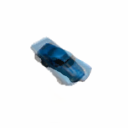
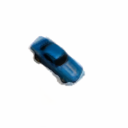
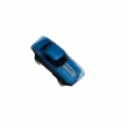
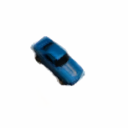
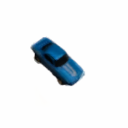
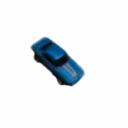
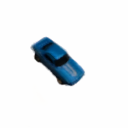
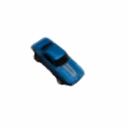
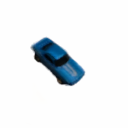
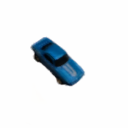
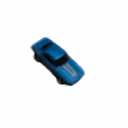

In [34]:
data = {}
for i, f in enumerate(overlay_frames):
    step = i*10
    data[f"Step {step}"] = f
media.show_images(data)